In [1]:
# 本次新人赛是Datawhale与天池联合发起的零基础入门系列赛事第七场 —— 零基础入门语义分割之地表建筑物识别挑战赛。
# 赛题以计算机视觉为背景，要求选手使用给定的航拍图像训练模型并完成地表建筑物识别任务。为更好的引导大家入门，
# 我们为本赛题定制了学习方案和学习任务，具体包括语义分割的模型和具体的应用案例。在具体任务中我们将讲解具体工具和使用和完成任务的过程。
# 通过对本方案的完整学习，可以帮助掌握语义分割基本技能。同时我们也将提供专属的视频直播学习通道。
# 新人赛的目的主要是为了更好地带动处于初学者阶段的新同学们一起玩起来，因此，我们鼓励所有选手，基于赛题发表notebook分享，
# 内容包含但不限于对赛题的理解、数据分析及可视化、算法模型的分析以及一些核心的思路等内容。

In [2]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook
# python -m pip install matplotlib if error
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

import rasterio
from rasterio.windows import Window

# rle编码和解码
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


In [3]:
# pip install torchvision=0.5.0

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

In [5]:
# 改小EPOCHES = 2BATCH_SIZE = 6 不然内存会蹦

In [5]:
EPOCHES = 1
BATCH_SIZE = 16
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
])


In [6]:
# dataset
class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [7]:
# 验证编码和解码
train_mask = pd.read_csv('./data/train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: './data/train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])

True


In [8]:
dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

In [9]:
# 要把train.zip提前下载下来，不然会报错

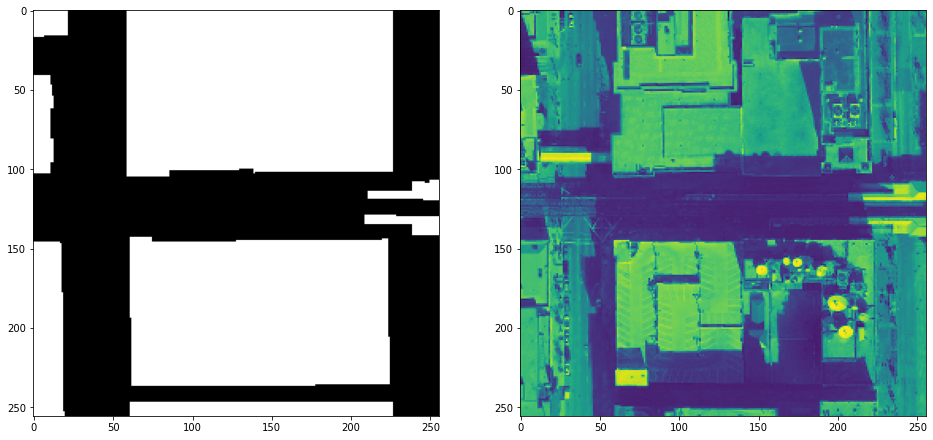

In [10]:
# 验证语义分割的正确性
image, mask = dataset[0]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);


In [11]:
# 划分训练和测试数据
valid_idx, train_idx = [], []
for i in range(len(dataset)):
    if i % 7 == 0:
        valid_idx.append(i)
#     else:
    elif i % 7 == 1:
        train_idx.append(i)
        
train_ds = D.Subset(dataset, train_idx)
valid_ds = D.Subset(dataset, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [12]:
# 把fcn_resnet50改成fcn_resnet101，就可以下载了
# 模型构建
def get_model():
#     model = torchvision.models.resnet50(pretrained=True)
#     model = torchvision.models.segmentation.fcn_resnet50(True)
    
    model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
#     pth = torch.load("../input/pretrain-coco-weights-pytorch/fcn_resnet50_coco-1167a1af.pth")
#     for key in ["aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias"]:
#         del pth[key]
    
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    return model
# 验证模型定义损失函数
@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [13]:

model = get_model()
model.to(DEVICE);
# AdamW优化
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()
# 交叉损失函数
def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

In [14]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
print(header)

EPOCHES = 1
best_loss = 10
for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm_notebook(loader):
        
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
#         with torch.no_grad():
        output = model(image)['out']
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(loss.item())
        
    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []
    
    if vloss < best_loss:
        best_loss = vloss
        
        
        torch.save(model.state_dict(), 'model_best.pth')


        Train | Valid
Epoch |  Loss |  Loss | Time, m



  0%|          | 0/268 [00:00<?, ?it/s]

     1│  0.335│  0.254│ 19.04


In [15]:
# 训练出最优模型
trfm = T.Compose([
    
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

subm = []

model.load_state_dict(torch.load("./model_best.pth"))
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [30]:
from PIL import Image

test_mask = pd.read_csv('./data/test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: './data/test_a/' + x)

for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    print(idx)
    print(name)
#     image = cv2.imread(name) 会报错，改成下面
# np.array(PIL.Image.open('000.jpg').convert('RGB'))
    image = np.array(Image.open(name).convert('RGB'))
    print(image)
    image = trfm(image)    
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)['out'][0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))

        
        # break
    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

  0%|          | 0/2500 [00:00<?, ?it/s]

0
./data/test_a/R05K5826G4.jpg
[[[132 136 145]
  [139 143 152]
  [130 133 142]
  ...
  [134 150 149]
  [104 120 119]
  [ 68  84  83]]

 [[131 135 144]
  [150 154 163]
  [112 115 124]
  ...
  [137 153 152]
  [154 170 170]
  [104 120 119]]

 [[130 137 143]
  [ 92  99 105]
  [ 95 100 106]
  ...
  [139 155 155]
  [138 153 156]
  [132 148 148]]

 ...

 [[ 89 112 104]
  [ 96 119 111]
  [ 89 112 102]
  ...
  [ 76  95  89]
  [117 136 134]
  [127 146 144]]

 [[ 90 116 107]
  [ 83 109 100]
  [ 79 105  96]
  ...
  [ 85 106  99]
  [ 96 116 114]
  [121 141 140]]

 [[ 93 119 110]
  [ 88 114 105]
  [ 80 105  99]
  ...
  [ 80 101  96]
  [108 130 127]
  [ 97 119 117]]]
1
./data/test_a/NAWXJVLK1Y.jpg
[[[125 134 129]
  [109 118 113]
  [108 115 108]
  ...
  [117 126 131]
  [123 130 136]
  [118 125 131]]

 [[120 129 124]
  [ 98 107 102]
  [105 114 109]
  ...
  [113 122 127]
  [116 123 129]
  [108 115 121]]

 [[109 120 116]
  [102 113 107]
  [107 118 112]
  ...
  [101 108 114]
  [127 135 138]
  [138 146 149

14
./data/test_a/K0C602FBCQ.jpg
[[[ 59  57  45]
  [ 64  62  50]
  [ 55  55  43]
  ...
  [179 183 182]
  [181 185 184]
  [185 189 188]]

 [[ 59  57  45]
  [ 65  63  51]
  [ 63  63  51]
  ...
  [179 183 182]
  [179 183 182]
  [182 186 185]]

 [[ 57  55  43]
  [ 66  64  52]
  [ 72  72  60]
  ...
  [180 184 183]
  [181 185 184]
  [184 188 187]]

 ...

 [[ 64  67  58]
  [ 63  66  57]
  [ 68  71  62]
  ...
  [ 70  83  65]
  [ 74  87  69]
  [ 76  89  71]]

 [[ 72  78  68]
  [ 70  76  66]
  [ 74  80  70]
  ...
  [ 67  80  63]
  [ 68  83  64]
  [ 68  83  64]]

 [[ 84  90  80]
  [ 79  85  75]
  [ 80  86  76]
  ...
  [ 65  78  61]
  [ 65  80  61]
  [ 64  79  60]]]
15
./data/test_a/NAGEJKZ2QB.jpg
[[[ 38  40  29]
  [ 83  85  74]
  [148 149 141]
  ...
  [184 195 189]
  [184 195 189]
  [187 198 192]]

 [[ 42  44  33]
  [ 39  41  30]
  [ 45  46  38]
  ...
  [185 196 190]
  [183 194 188]
  [186 197 191]]

 [[ 41  42  34]
  [ 43  44  36]
  [ 43  44  38]
  ...
  [184 195 189]
  [186 197 191]
  [184 195 1

29
./data/test_a/LRDXC0Q6ZI.jpg
[[[ 60  78  80]
  [131 149 151]
  [ 94 114 115]
  ...
  [ 44  44  34]
  [ 46  46  36]
  [ 47  47  37]]

 [[ 81  99 101]
  [ 93 111 113]
  [ 80 100 101]
  ...
  [ 44  44  34]
  [ 45  45  35]
  [ 45  45  35]]

 [[115 133 135]
  [ 96 114 116]
  [ 92 112 111]
  ...
  [ 45  45  35]
  [ 45  45  35]
  [ 44  44  34]]

 ...

 [[ 47  47  35]
  [ 46  46  34]
  [ 45  45  33]
  ...
  [ 73  72  68]
  [ 64  63  58]
  [ 71  70  65]]

 [[ 46  46  34]
  [ 45  45  33]
  [ 45  45  33]
  ...
  [ 48  47  42]
  [ 88  87  82]
  [ 45  44  39]]

 [[ 46  46  34]
  [ 45  45  33]
  [ 45  45  33]
  ...
  [115 114 109]
  [ 58  57  52]
  [ 82  81  76]]]
30
./data/test_a/42JEIO82C7.jpg
[[[100 121 114]
  [ 86 107 100]
  [ 73  90  82]
  ...
  [ 44  46  41]
  [ 87  86  81]
  [ 70  69  64]]

 [[106 127 120]
  [ 99 120 113]
  [103 123 114]
  ...
  [ 52  54  49]
  [ 77  78  72]
  [ 94  93  88]]

 [[103 126 118]
  [105 126 119]
  [122 142 133]
  ...
  [ 38  40  35]
  [ 47  48  42]
  [ 54  55  

[[[133 145 123]
  [ 87  99  77]
  [110 124 101]
  ...
  [ 90  76  50]
  [ 84  72  48]
  [ 82  70  46]]

 [[138 147 126]
  [102 114  92]
  [ 90 102  80]
  ...
  [ 90  76  50]
  [ 84  72  48]
  [ 85  73  49]]

 [[141 149 126]
  [118 128 104]
  [ 78  88  64]
  ...
  [ 88  73  50]
  [ 84  72  48]
  [ 86  74  50]]

 ...

 [[151 161 152]
  [164 174 163]
  [ 76  83  75]
  ...
  [191 187 176]
  [120 113 103]
  [ 85  76  67]]

 [[157 165 154]
  [173 181 168]
  [144 150 140]
  ...
  [176 172 163]
  [196 189 181]
  [162 155 147]]

 [[136 144 131]
  [120 128 115]
  [138 144 132]
  ...
  [166 163 156]
  [243 236 230]
  [245 238 232]]]
44
./data/test_a/WAOJZP5BIW.jpg
[[[107 126 120]
  [ 99 118 112]
  [ 95 112 106]
  ...
  [ 48  44  33]
  [ 46  42  33]
  [ 47  43  34]]

 [[106 125 119]
  [ 98 117 111]
  [ 94 111 105]
  ...
  [ 93  89  78]
  [ 75  71  62]
  [ 50  46  37]]

 [[ 93 110 104]
  [ 95 112 106]
  [ 91 108 102]
  ...
  [ 46  43  34]
  [ 45  40  34]
  [ 49  44  38]]

 ...

 [[ 93 106  97]
  [ 

59
./data/test_a/UK7X3N8CB6.jpg
[[[143 142 148]
  [ 71  70  76]
  [ 68  67  73]
  ...
  [127 143 130]
  [136 152 141]
  [134 150 139]]

 [[152 151 157]
  [110 109 115]
  [107 106 112]
  ...
  [129 145 132]
  [133 149 138]
  [130 146 135]]

 [[162 162 170]
  [156 156 164]
  [131 131 139]
  ...
  [129 145 132]
  [130 146 135]
  [134 150 139]]

 ...

 [[174 180 194]
  [181 187 201]
  [180 186 200]
  ...
  [124 113 129]
  [118 105 114]
  [ 83  68  73]]

 [[182 186 198]
  [189 193 205]
  [186 190 202]
  ...
  [174 165 182]
  [134 122 132]
  [ 84  71  78]]

 [[187 191 203]
  [182 186 198]
  [189 193 204]
  ...
  [156 147 164]
  [115 103 113]
  [ 98  85  92]]]
60
./data/test_a/3O9ONS38IN.jpg
[[[ 72  91  71]
  [ 76  95  75]
  [ 70  87  68]
  ...
  [ 84  98  99]
  [ 99 113 114]
  [ 94 108 109]]

 [[ 75  94  74]
  [ 74  93  73]
  [ 72  89  70]
  ...
  [ 74  88  89]
  [ 92 106 107]
  [ 88 102 103]]

 [[ 73  95  74]
  [ 70  89  69]
  [ 80  97  78]
  ...
  [ 79  91  91]
  [ 96 108 108]
  [ 95 107 1

76
./data/test_a/A1W97WW59C.jpg
[[[143 134 125]
  [146 137 128]
  [144 135 126]
  ...
  [112 115 122]
  [112 115 122]
  [109 112 119]]

 [[144 135 126]
  [144 135 126]
  [143 134 125]
  ...
  [113 116 123]
  [113 116 123]
  [111 114 121]]

 [[145 137 126]
  [143 135 124]
  [144 136 125]
  ...
  [112 115 122]
  [114 117 124]
  [112 115 122]]

 ...

 [[106 119 128]
  [ 83  96 104]
  [ 70  85  90]
  ...
  [142 145 150]
  [142 143 148]
  [141 142 147]]

 [[122 132 144]
  [106 118 130]
  [ 74  89  96]
  ...
  [141 144 149]
  [139 142 147]
  [139 142 147]]

 [[141 150 165]
  [137 149 161]
  [101 114 123]
  ...
  [140 143 148]
  [139 142 147]
  [139 142 147]]]
77
./data/test_a/TH698VLW4Q.jpg
[[[105 117 115]
  [ 91 103 101]
  [101 112 108]
  ...
  [ 57  63  59]
  [ 57  62  58]
  [ 59  64  58]]

 [[ 94 106 104]
  [ 97 109 107]
  [100 110 109]
  ...
  [ 65  71  69]
  [ 64  69  65]
  [ 58  63  57]]

 [[110 122 122]
  [101 113 111]
  [110 120 119]
  ...
  [ 62  68  66]
  [ 56  60  59]
  [ 65  70  

93
./data/test_a/UUTLD2WRZT.jpg
[[[138 155 162]
  [ 91 110 116]
  [ 84 103 110]
  ...
  [ 27  28  23]
  [ 81  83  78]
  [ 78  80  75]]

 [[133 150 157]
  [ 85 104 110]
  [ 84 104 111]
  ...
  [ 39  40  35]
  [ 67  69  64]
  [132 134 129]]

 [[133 150 157]
  [ 80  99 105]
  [ 87 107 114]
  ...
  [ 44  45  39]
  [131 133 128]
  [ 68  70  65]]

 ...

 [[ 42  47  43]
  [106 111 107]
  [ 47  52  48]
  ...
  [109 120 116]
  [112 123 119]
  [ 90 101  97]]

 [[ 40  45  39]
  [ 44  49  43]
  [ 41  46  40]
  ...
  [102 113 109]
  [109 120 116]
  [109 120 116]]

 [[ 45  50  44]
  [ 47  52  46]
  [ 46  51  45]
  ...
  [109 120 116]
  [ 99 110 106]
  [106 117 113]]]
94
./data/test_a/3QVL860CAI.jpg
[[[ 47  61  48]
  [ 56  70  57]
  [ 72  88  77]
  ...
  [ 37  68  62]
  [ 41  70  65]
  [ 39  66  61]]

 [[ 51  65  52]
  [ 56  70  57]
  [ 57  73  62]
  ...
  [ 84 115 109]
  [105 132 127]
  [106 133 128]]

 [[ 55  69  56]
  [ 54  68  55]
  [ 50  66  55]
  ...
  [ 99 125 122]
  [120 145 142]
  [120 145 1

111
./data/test_a/C27XNNFYCE.jpg
[[[ 74  77  50]
  [ 70  73  46]
  [ 58  58  32]
  ...
  [121 134 143]
  [126 139 148]
  [127 140 149]]

 [[ 58  61  34]
  [ 60  63  36]
  [ 61  61  35]
  ...
  [126 139 148]
  [128 141 150]
  [128 141 150]]

 [[ 58  62  35]
  [ 64  68  41]
  [ 62  65  38]
  ...
  [134 148 157]
  [130 144 153]
  [136 150 159]]

 ...

 [[ 71  81  57]
  [ 77  87  63]
  [ 81  91  66]
  ...
  [ 76  77  59]
  [ 71  74  57]
  [ 72  75  58]]

 [[ 69  79  55]
  [ 74  84  60]
  [ 73  83  58]
  ...
  [ 77  80  61]
  [ 72  75  58]
  [ 73  76  59]]

 [[ 69  79  55]
  [ 72  82  58]
  [ 67  77  52]
  ...
  [ 78  81  62]
  [ 75  78  61]
  [ 77  80  63]]]
112
./data/test_a/0QVGANY0PF.jpg
[[[149 161 149]
  [149 161 149]
  [150 160 149]
  ...
  [142 154 144]
  [150 162 152]
  [145 157 147]]

 [[148 160 148]
  [148 160 148]
  [151 161 150]
  ...
  [140 152 142]
  [146 158 148]
  [140 152 142]]

 [[149 159 148]
  [150 160 149]
  [152 162 151]
  ...
  [140 153 143]
  [145 158 148]
  [141 154

126
./data/test_a/8NJRDE5JJP.jpg
[[[107 123 110]
  [110 126 113]
  [114 130 117]
  ...
  [ 82  67  48]
  [ 81  64  46]
  [ 82  65  47]]

 [[109 125 112]
  [110 126 113]
  [112 128 115]
  ...
  [ 80  65  46]
  [ 79  62  44]
  [ 79  62  44]]

 [[110 126 113]
  [110 126 113]
  [111 127 114]
  ...
  [ 79  64  45]
  [ 80  63  45]
  [ 80  63  45]]

 ...

 [[122 143 138]
  [121 142 137]
  [120 141 136]
  ...
  [ 99 100  86]
  [102 104  91]
  [106 108  95]]

 [[117 138 133]
  [117 138 133]
  [116 137 130]
  ...
  [104 104  92]
  [103 105  92]
  [100 104  90]]

 [[112 133 128]
  [114 135 130]
  [116 137 130]
  ...
  [ 99 101  88]
  [101 103  90]
  [103 107  93]]]
127
./data/test_a/1D6CXDIDSJ.jpg
[[[ 52  27  20]
  [ 66  43  35]
  [ 56  37  31]
  ...
  [ 74  85  87]
  [ 87  97  99]
  [ 86  96  98]]

 [[ 82  57  50]
  [ 83  60  54]
  [ 60  41  35]
  ...
  [ 83  94  96]
  [ 87  97  99]
  [ 90 100 102]]

 [[ 93  70  64]
  [ 89  69  62]
  [ 62  45  38]
  ...
  [104 114 116]
  [ 78  88  89]
  [ 94 104

144
./data/test_a/1X7B84AOEU.jpg
[[[162 153 138]
  [190 181 166]
  [171 164 148]
  ...
  [147 159 173]
  [148 160 174]
  [147 159 173]]

 [[172 163 148]
  [156 149 133]
  [128 121 105]
  ...
  [145 157 171]
  [146 158 172]
  [146 158 172]]

 [[170 163 147]
  [154 148 132]
  [120 114  98]
  ...
  [145 159 172]
  [145 159 172]
  [146 160 173]]

 ...

 [[217 222 228]
  [210 215 221]
  [212 217 221]
  ...
  [107 106 104]
  [124 128 131]
  [145 150 154]]

 [[221 226 230]
  [212 217 221]
  [216 221 225]
  ...
  [118 114 113]
  [108 108 110]
  [ 99 103 106]]

 [[222 227 231]
  [216 221 225]
  [220 225 229]
  ...
  [115 110 107]
  [111 111 113]
  [101 102 106]]]
145
./data/test_a/SVSECPJ86I.jpg
[[[ 70  67  62]
  [147 144 139]
  [137 129 126]
  ...
  [ 52  51  47]
  [ 47  46  42]
  [ 51  50  46]]

 [[131 128 123]
  [178 175 170]
  [186 178 175]
  ...
  [ 53  52  48]
  [ 60  56  53]
  [ 52  51  46]]

 [[121 118 113]
  [187 184 179]
  [177 169 166]
  ...
  [ 49  46  41]
  [ 55  50  46]
  [ 50  47

157
./data/test_a/0EO0FJN9CH.jpg
[[[ 78 105  88]
  [ 86 113  96]
  [ 79 106  89]
  ...
  [ 95 113 123]
  [ 88 107 114]
  [ 81 100 107]]

 [[ 86 113  96]
  [ 76 103  86]
  [ 74 101  84]
  ...
  [ 94 112 122]
  [ 94 113 120]
  [ 88 107 114]]

 [[101 129 114]
  [ 77 105  90]
  [ 66  94  79]
  ...
  [ 90 109 116]
  [ 95 114 121]
  [ 95 114 121]]

 ...

 [[ 78 107  87]
  [ 93 122 102]
  [ 85 114  96]
  ...
  [105 114 113]
  [102 110 112]
  [ 71  79  81]]

 [[ 81 110  88]
  [ 75 104  82]
  [ 64  91  72]
  ...
  [ 73  83  84]
  [ 69  79  81]
  [ 50  60  62]]

 [[ 63  92  70]
  [ 63  92  70]
  [ 72  99  80]
  ...
  [ 29  39  40]
  [ 44  53  58]
  [ 66  75  80]]]
158
./data/test_a/CUIF6Z8XHJ.jpg
[[[63 66 47]
  [57 60 41]
  [62 65 46]
  ...
  [44 48 25]
  [50 50 26]
  [49 49 25]]

 [[64 67 50]
  [59 62 43]
  [62 65 48]
  ...
  [48 52 29]
  [49 51 27]
  [51 51 27]]

 [[66 68 54]
  [62 65 48]
  [61 65 50]
  ...
  [49 53 30]
  [47 49 27]
  [46 48 26]]

 ...

 [[57 64 46]
  [52 60 39]
  [54 62 41]
 

[[[ 88  99  91]
  [ 86  97  89]
  [ 91 101  92]
  ...
  [106 115 110]
  [136 145 142]
  [133 142 139]]

 [[ 91 101  93]
  [ 98 108 100]
  [106 116 107]
  ...
  [104 113 108]
  [133 142 139]
  [117 126 123]]

 [[112 119 112]
  [114 121 114]
  [110 117 110]
  ...
  [100 109 106]
  [115 124 123]
  [132 141 140]]

 ...

 [[139 156 164]
  [131 148 156]
  [124 143 149]
  ...
  [ 93 100  82]
  [ 90  94  79]
  [ 86  88  74]]

 [[143 161 171]
  [134 153 160]
  [122 141 147]
  ...
  [ 77  81  64]
  [ 70  72  58]
  [ 73  75  61]]

 [[154 172 182]
  [146 165 172]
  [129 148 155]
  ...
  [ 73  76  59]
  [ 66  68  54]
  [ 72  74  60]]]
173
./data/test_a/LSVNII6M3Q.jpg
[[[ 95 110 107]
  [105 120 117]
  [ 79  94  89]
  ...
  [ 48  57  54]
  [ 46  52  50]
  [102 108 106]]

 [[ 51  66  63]
  [ 83  98  95]
  [ 97 112 107]
  ...
  [ 40  49  46]
  [ 74  80  78]
  [ 99 105 103]]

 [[ 68  80  78]
  [107 119 117]
  [102 114 110]
  ...
  [ 54  65  61]
  [ 91 100  97]
  [ 88  97  94]]

 ...

 [[105 112 118]
  [

189
./data/test_a/7CCTLL8XFS.jpg
[[[119 135 132]
  [116 132 129]
  [124 136 134]
  ...
  [142 152 151]
  [141 153 151]
  [ 63  75  73]]

 [[123 139 136]
  [116 131 128]
  [137 149 147]
  ...
  [142 152 151]
  [139 151 149]
  [ 79  91  89]]

 [[123 138 135]
  [131 146 143]
  [152 164 162]
  ...
  [139 149 148]
  [141 153 151]
  [140 152 150]]

 ...

 [[134 149 146]
  [135 150 147]
  [111 126 123]
  ...
  [ 99 115 104]
  [117 130 121]
  [128 141 132]]

 [[132 147 144]
  [132 147 144]
  [126 141 136]
  ...
  [ 96 108  98]
  [ 31  41  33]
  [ 17  26  21]]

 [[116 131 128]
  [131 146 143]
  [113 128 123]
  ...
  [ 20  32  22]
  [ 31  37  33]
  [ 33  39  35]]]
190
./data/test_a/DWKIO5M0UB.jpg
[[[ 67  89  86]
  [ 62  84  81]
  [ 75  97  94]
  ...
  [ 57  73  62]
  [ 56  72  59]
  [ 61  77  64]]

 [[105 127 124]
  [122 144 141]
  [126 148 145]
  ...
  [ 51  64  54]
  [ 58  72  59]
  [ 60  76  63]]

 [[138 163 159]
  [138 163 159]
  [133 158 154]
  ...
  [ 55  67  57]
  [ 59  71  59]
  [ 57  71

[[[ 80  90  91]
  [ 67  77  78]
  [ 97 105 107]
  ...
  [151 158 150]
  [148 155 147]
  [135 142 134]]

 [[ 85  95  96]
  [ 84  94  95]
  [ 71  79  81]
  ...
  [150 157 149]
  [153 160 152]
  [147 154 146]]

 [[ 87  95  97]
  [ 77  85  87]
  [ 92 100 102]
  ...
  [154 161 153]
  [155 162 154]
  [151 158 150]]

 ...

 [[ 50  55  51]
  [158 163 159]
  [118 123 119]
  ...
  [ 86  84  85]
  [ 83  81  82]
  [ 46  44  45]]

 [[ 46  48  43]
  [165 170 164]
  [ 59  64  58]
  ...
  [ 65  64  62]
  [ 59  57  58]
  [ 71  69  70]]

 [[ 38  41  34]
  [164 167 160]
  [ 82  87  80]
  ...
  [ 67  66  64]
  [ 45  43  44]
  [ 83  81  82]]]
206
./data/test_a/8PKNFS9X2A.jpg
[[[ 51  55  54]
  [ 48  52  51]
  [ 44  46  43]
  ...
  [144 159 166]
  [136 151 158]
  [140 155 162]]

 [[ 43  47  46]
  [ 28  33  29]
  [ 40  42  39]
  ...
  [135 150 157]
  [144 159 166]
  [144 159 166]]

 [[116 122 118]
  [156 163 156]
  [108 113 107]
  ...
  [145 160 167]
  [157 172 179]
  [164 179 186]]

 ...

 [[ 79  83  84]
  [

220
./data/test_a/Z5SY0WSKTR.jpg
[[[ 55  63  42]
  [ 58  66  45]
  [ 60  69  48]
  ...
  [ 51  49  37]
  [ 63  61  49]
  [ 70  68  56]]

 [[ 53  61  40]
  [ 59  67  46]
  [ 59  68  47]
  ...
  [ 53  51  39]
  [ 61  59  47]
  [ 64  62  50]]

 [[ 57  66  47]
  [ 58  67  48]
  [ 54  63  44]
  ...
  [ 52  50  37]
  [ 56  54  42]
  [ 55  53  41]]

 ...

 [[ 77  88  80]
  [ 85  96  88]
  [ 89 100  92]
  ...
  [ 58  67  50]
  [ 75  84  67]
  [ 84  93  74]]

 [[ 84  95  87]
  [ 87  98  90]
  [ 88  99  91]
  ...
  [ 59  66  48]
  [ 60  67  49]
  [ 79  87  66]]

 [[ 79  90  82]
  [ 84  95  87]
  [ 86  97  89]
  ...
  [ 59  66  48]
  [ 62  67  47]
  [ 64  69  49]]]
221
./data/test_a/UANT32Q0ZD.jpg
[[[192 202 212]
  [195 205 215]
  [198 208 218]
  ...
  [179 188 195]
  [178 189 193]
  [183 194 198]]

 [[192 202 212]
  [195 205 215]
  [197 207 217]
  ...
  [186 195 202]
  [184 195 199]
  [185 196 200]]

 [[191 201 211]
  [191 201 211]
  [192 202 212]
  ...
  [189 198 205]
  [189 200 204]
  [188 199

238
./data/test_a/S9RG8VW1XA.jpg
[[[ 93 114 119]
  [156 177 182]
  [162 181 187]
  ...
  [105 117 129]
  [107 119 131]
  [128 140 152]]

 [[155 174 178]
  [160 179 183]
  [165 183 187]
  ...
  [ 94 106 118]
  [ 95 107 119]
  [120 132 144]]

 [[160 174 177]
  [166 180 183]
  [165 179 182]
  ...
  [ 99 109 119]
  [ 99 109 119]
  [131 141 151]]

 ...

 [[145 168 210]
  [125 149 185]
  [125 147 170]
  ...
  [115 121 121]
  [111 117 117]
  [112 120 122]]

 [[127 143 195]
  [146 163 209]
  [154 170 204]
  ...
  [ 88  94  92]
  [108 114 114]
  [119 125 125]]

 [[127 137 196]
  [154 166 218]
  [152 166 205]
  ...
  [120 125 121]
  [132 138 138]
  [126 132 132]]]
239
./data/test_a/42KA4YWMY0.jpg
[[[ 33  26  20]
  [ 30  23  17]
  [ 36  29  23]
  ...
  [ 30  26  23]
  [ 31  28  23]
  [ 32  29  24]]

 [[ 47  40  34]
  [ 43  36  30]
  [ 44  37  31]
  ...
  [ 30  26  23]
  [ 31  28  23]
  [ 32  29  24]]

 [[ 48  43  37]
  [ 46  41  35]
  [ 46  41  35]
  ...
  [ 30  26  23]
  [ 31  27  24]
  [ 32  28

253
./data/test_a/4PAJS92F6Y.jpg
[[[ 86  94  81]
  [ 96 104  91]
  [ 69  80  64]
  ...
  [ 67  78  61]
  [ 61  73  53]
  [ 80  92  72]]

 [[ 74  82  69]
  [ 75  83  70]
  [ 63  74  58]
  ...
  [ 64  76  56]
  [ 87  99  79]
  [ 84  96  76]]

 [[ 70  78  65]
  [ 72  80  67]
  [ 64  72  57]
  ...
  [ 75  84  63]
  [ 78  87  66]
  [ 77  86  65]]

 ...

 [[103 123 122]
  [108 127 125]
  [ 87 104  98]
  ...
  [ 82  89  73]
  [ 82  91  74]
  [ 80  89  72]]

 [[103 123 121]
  [106 125 121]
  [ 97 112 105]
  ...
  [ 83  90  74]
  [ 82  89  73]
  [ 80  87  71]]

 [[105 125 123]
  [113 132 128]
  [ 86 102  92]
  ...
  [ 82  89  73]
  [ 81  88  72]
  [ 79  86  70]]]
254
./data/test_a/IBLB51RJQS.jpg
[[[ 66  88  67]
  [ 74  96  75]
  [ 77  99  78]
  ...
  [ 74  95  80]
  [ 73  94  79]
  [ 75  96  81]]

 [[ 68  90  69]
  [ 73  95  74]
  [ 75  97  76]
  ...
  [ 70  91  76]
  [ 73  94  79]
  [ 77  98  83]]

 [[ 70  92  71]
  [ 72  94  73]
  [ 71  93  72]
  ...
  [ 73  96  80]
  [ 77 100  84]
  [ 80 103

[[[175 182 200]
  [175 182 198]
  [ 91  97 111]
  ...
  [175 183 194]
  [175 183 194]
  [177 185 196]]

 [[175 180 199]
  [147 153 169]
  [ 53  59  71]
  ...
  [173 181 192]
  [175 183 194]
  [171 179 190]]

 [[170 173 190]
  [ 83  86 101]
  [ 57  61  73]
  ...
  [169 177 188]
  [174 182 193]
  [167 175 186]]

 ...

 [[ 45  41  40]
  [ 51  47  46]
  [ 58  52  52]
  ...
  [ 62  75  68]
  [ 66  81  76]
  [ 74  89  84]]

 [[ 51  47  44]
  [ 56  52  49]
  [ 61  56  53]
  ...
  [ 61  76  71]
  [ 65  80  77]
  [ 69  84  81]]

 [[ 55  51  48]
  [ 54  50  47]
  [ 55  50  47]
  ...
  [ 67  82  77]
  [ 69  84  81]
  [ 72  87  84]]]
271
./data/test_a/TTUM8W2XP9.jpg
[[[111 126  95]
  [110 125  94]
  [114 127  97]
  ...
  [ 97 102  80]
  [111 119  98]
  [106 114  93]]

 [[110 125  94]
  [109 124  93]
  [112 125  95]
  ...
  [ 92  97  75]
  [110 118  97]
  [100 108  87]]

 [[117 130 100]
  [110 123  93]
  [108 121  91]
  ...
  [104 109  87]
  [ 99 107  86]
  [ 92 100  79]]

 ...

 [[ 72  56  30]
  [

288
./data/test_a/WXSTTHH0GB.jpg
[[[ 87 122  90]
  [ 71 104  73]
  [ 75 105  79]
  ...
  [107 127 102]
  [115 134 114]
  [124 143 123]]

 [[ 57  90  59]
  [ 69 102  71]
  [ 75 104  76]
  ...
  [ 94 114  89]
  [111 130 110]
  [112 131 111]]

 [[ 63  94  63]
  [ 60  91  60]
  [ 95 124  96]
  ...
  [ 95 118  92]
  [101 120 100]
  [ 98 117  97]]

 ...

 [[ 33  35  32]
  [ 54  56  53]
  [ 55  57  54]
  ...
  [ 45  65  40]
  [ 49  72  46]
  [ 97 120  94]]

 [[ 71  70  68]
  [ 84  83  81]
  [ 62  61  59]
  ...
  [ 61  85  59]
  [ 91 114  86]
  [103 126  98]]

 [[ 25  21  20]
  [ 80  76  75]
  [133 129 128]
  ...
  [ 89 115  88]
  [ 93 118  89]
  [ 96 119  91]]]
289
./data/test_a/U7MGTLPECA.jpg
[[[135 152 142]
  [105 122 112]
  [ 94 109 104]
  ...
  [ 51  51  49]
  [ 49  49  47]
  [ 60  60  58]]

 [[150 165 158]
  [ 92 107 100]
  [100 115 110]
  ...
  [ 82  82  80]
  [ 59  59  57]
  [ 55  55  53]]

 [[ 94 106 102]
  [ 71  83  81]
  [105 117 115]
  ...
  [ 71  69  70]
  [ 56  54  55]
  [ 51  49

304
./data/test_a/TC8HBMO227.jpg
[[[108 111 102]
  [105 108  99]
  [110 111 105]
  ...
  [ 86 100  85]
  [ 87  99  85]
  [ 98 110  96]]

 [[141 142 134]
  [143 144 136]
  [145 146 140]
  ...
  [ 83  97  82]
  [ 74  86  72]
  [ 82  94  80]]

 [[ 94  93  88]
  [ 90  89  84]
  [ 88  87  83]
  ...
  [ 83  97  84]
  [ 89 101  89]
  [106 118 106]]

 ...

 [[ 92  97  93]
  [111 116 112]
  [ 84  86  83]
  ...
  [ 51  51  51]
  [ 86  86  88]
  [118 118 120]]

 [[ 84  89  85]
  [ 98 103  99]
  [ 88  90  87]
  ...
  [ 62  62  62]
  [ 63  63  65]
  [114 114 116]]

 [[ 57  62  58]
  [110 115 111]
  [ 89  91  88]
  ...
  [ 60  60  60]
  [ 70  70  72]
  [ 88  88  90]]]
305
./data/test_a/RZ5K5HY5Z5.jpg
[[[118 132 133]
  [123 137 138]
  [119 133 134]
  ...
  [112 125 133]
  [117 129 141]
  [106 120 131]]

 [[116 130 131]
  [119 133 134]
  [117 131 132]
  ...
  [101 111 120]
  [100 113 122]
  [ 83  97 106]]

 [[116 130 131]
  [118 132 133]
  [115 129 130]
  ...
  [ 87  98 102]
  [ 89 100 106]
  [ 85  98

321
./data/test_a/5OUXHTPVBB.jpg
[[[113 114 116]
  [115 116 118]
  [114 115 117]
  ...
  [ 71  81  83]
  [ 53  58  61]
  [ 67  72  75]]

 [[119 120 122]
  [118 119 121]
  [116 117 119]
  ...
  [ 66  76  77]
  [ 47  55  57]
  [ 67  73  73]]

 [[121 122 124]
  [121 122 124]
  [120 121 123]
  ...
  [ 68  78  77]
  [ 42  51  50]
  [ 49  55  53]]

 ...

 [[ 93  93  91]
  [149 149 147]
  [123 125 124]
  ...
  [ 54  54  54]
  [ 54  52  53]
  [ 55  55  55]]

 [[ 94  95  90]
  [136 136 134]
  [124 126 125]
  ...
  [ 40  38  39]
  [ 60  56  57]
  [ 51  49  50]]

 [[ 95  96  91]
  [ 94  95  90]
  [110 112 111]
  ...
  [ 56  52  53]
  [ 65  61  62]
  [ 53  49  50]]]
322
./data/test_a/AKIIJCKRLR.jpg
[[[ 73  75  74]
  [107 109 108]
  [137 139 136]
  ...
  [ 47  46  41]
  [ 58  57  52]
  [ 66  65  60]]

 [[ 64  66  65]
  [194 196 195]
  [241 243 240]
  ...
  [ 42  41  36]
  [ 40  39  34]
  [ 44  43  38]]

 [[242 244 243]
  [238 240 239]
  [237 239 236]
  ...
  [ 50  47  42]
  [ 48  47  42]
  [ 37  36

337
./data/test_a/N50HVKEH66.jpg
[[[ 82  73  74]
  [ 88  79  80]
  [ 83  74  75]
  ...
  [ 62  63  67]
  [ 64  65  70]
  [ 63  64  69]]

 [[ 81  72  73]
  [ 81  72  73]
  [ 81  72  73]
  ...
  [ 64  65  69]
  [ 68  69  73]
  [ 66  67  71]]

 [[ 85  76  77]
  [ 82  73  74]
  [ 84  75  76]
  ...
  [ 67  67  69]
  [ 65  65  67]
  [ 64  64  66]]

 ...

 [[ 62  83  74]
  [ 62  83  74]
  [ 61  82  73]
  ...
  [ 72  80  82]
  [ 88  93  97]
  [102 107 111]]

 [[ 73  96  88]
  [ 69  92  82]
  [ 61  84  74]
  ...
  [ 69  79  80]
  [ 82  90  93]
  [103 111 114]]

 [[ 67  90  82]
  [ 67  90  82]
  [ 67  90  80]
  ...
  [ 56  66  67]
  [ 72  80  83]
  [ 88  96  99]]]
338
./data/test_a/POEWD9AJ7S.jpg
[[[215 222 214]
  [116 126 117]
  [ 65  75  67]
  ...
  [ 89 102  95]
  [120 135 128]
  [109 124 117]]

 [[229 236 228]
  [159 169 160]
  [ 31  42  34]
  ...
  [ 85  98  89]
  [105 118 111]
  [ 94 110 100]]

 [[231 241 233]
  [206 217 209]
  [ 19  30  24]
  ...
  [ 97 109  99]
  [103 114 106]
  [ 86  99

355
./data/test_a/RJVE3XB5J7.jpg
[[[171 178 197]
  [173 180 199]
  [167 172 191]
  ...
  [127 128 114]
  [121 119 104]
  [119 117 102]]

 [[172 179 198]
  [171 178 196]
  [169 174 193]
  ...
  [113 114 100]
  [101 102  86]
  [114 115  99]]

 [[174 181 199]
  [167 174 190]
  [163 169 185]
  ...
  [100 102  88]
  [ 92  95  78]
  [122 125 108]]

 ...

 [[147 153 153]
  [158 164 164]
  [143 152 151]
  ...
  [179 192 198]
  [189 200 206]
  [191 200 209]]

 [[142 147 150]
  [156 161 164]
  [140 148 150]
  ...
  [190 203 211]
  [198 208 218]
  [194 204 214]]

 [[137 142 145]
  [148 153 156]
  [147 155 157]
  ...
  [188 203 210]
  [202 212 224]
  [180 190 202]]]
356
./data/test_a/IKPN648RQC.jpg
[[[143 170 161]
  [135 163 151]
  [144 172 160]
  ...
  [198 200 197]
  [200 202 199]
  [201 203 200]]

 [[147 173 164]
  [151 177 166]
  [153 179 166]
  ...
  [201 203 200]
  [203 205 204]
  [203 205 202]]

 [[148 171 161]
  [143 164 155]
  [140 162 150]
  ...
  [192 196 195]
  [192 196 197]
  [197 201

[[[ 84  97  88]
  [ 89 102  93]
  [ 94 107 100]
  ...
  [115 116 111]
  [ 67  69  66]
  [127 129 126]]

 [[ 95 106  98]
  [ 98 109 101]
  [ 92 103  97]
  ...
  [122 123 118]
  [ 63  65  62]
  [129 131 128]]

 [[106 111 105]
  [ 88  93  87]
  [ 69  74  68]
  ...
  [120 121 116]
  [ 56  58  55]
  [148 150 147]]

 ...

 [[ 89  91  88]
  [ 86  88  85]
  [ 92  97  93]
  ...
  [109 112 117]
  [ 94  98 101]
  [ 85  86  88]]

 [[ 90  92  89]
  [ 90  92  89]
  [ 88  93  89]
  ...
  [140 145 149]
  [ 99 102 107]
  [ 83  87  90]]

 [[ 89  91  88]
  [ 88  93  89]
  [ 91  96  92]
  ...
  [ 82  89  95]
  [ 26  29  34]
  [116 119 124]]]
373
./data/test_a/HMKYFXY6WR.jpg
[[[ 36  52  52]
  [ 55  71  70]
  [ 44  63  57]
  ...
  [ 85 113 101]
  [ 91 117 106]
  [ 91 117 106]]

 [[ 10  26  25]
  [ 37  56  52]
  [ 68  88  79]
  ...
  [ 88 116 104]
  [ 91 117 106]
  [ 86 112 101]]

 [[ 10  30  21]
  [ 46  66  55]
  [112 132 120]
  ...
  [ 83 113 103]
  [ 87 114 105]
  [ 85 112 103]]

 ...

 [[103 131 143]
  [

389
./data/test_a/7SNZVDG409.jpg
[[[104 117 162]
  [111 125 170]
  [103 117 166]
  ...
  [ 90 102 100]
  [ 81  96  91]
  [ 64  79  74]]

 [[118 131 175]
  [113 128 171]
  [114 128 175]
  ...
  [108 120 118]
  [ 96 111 106]
  [ 64  79  74]]

 [[109 123 160]
  [ 95 110 149]
  [109 124 167]
  ...
  [ 94 106 104]
  [ 90 105 102]
  [ 72  87  84]]

 ...

 [[114 112 123]
  [111 109 120]
  [107 105 116]
  ...
  [ 70  61  62]
  [ 70  61  62]
  [ 70  61  62]]

 [[110 110 118]
  [105 105 113]
  [108 108 116]
  ...
  [ 70  61  62]
  [ 70  61  62]
  [ 70  61  62]]

 [[115 116 121]
  [116 117 122]
  [120 120 128]
  ...
  [ 70  61  62]
  [ 70  61  62]
  [ 70  61  62]]]
390
./data/test_a/D7HE55GJEM.jpg
[[[ 74 103 109]
  [ 74 103 109]
  [ 66  95 101]
  ...
  [134 144 146]
  [135 145 147]
  [135 145 147]]

 [[ 76 105 111]
  [ 81 110 116]
  [ 73 102 108]
  ...
  [134 144 146]
  [135 145 147]
  [135 145 147]]

 [[ 91 118 127]
  [ 95 122 131]
  [104 131 138]
  ...
  [134 144 145]
  [134 144 145]
  [135 145

405
./data/test_a/NNOJEWWU4B.jpg
[[[106 118 106]
  [111 123 111]
  [100 112 100]
  ...
  [148 141 133]
  [205 195 186]
  [189 179 170]]

 [[ 93 105  93]
  [118 130 118]
  [116 128 116]
  ...
  [166 159 151]
  [203 194 185]
  [181 171 162]]

 [[ 86  98  88]
  [ 94 106  96]
  [ 75  87  77]
  ...
  [190 183 175]
  [191 182 173]
  [182 173 164]]

 ...

 [[100 123 107]
  [ 74  97  81]
  [ 93 111  97]
  ...
  [ 62  72  63]
  [ 43  53  44]
  [ 79  89  80]]

 [[ 81 104  88]
  [ 97 120 104]
  [ 95 113 101]
  ...
  [ 41  53  43]
  [101 113 103]
  [121 133 123]]

 [[ 91 114  98]
  [ 84 107  91]
  [ 49  67  55]
  ...
  [ 54  66  56]
  [ 61  73  63]
  [ 80  92  82]]]
406
./data/test_a/PA7SFJJQ66.jpg
[[[42 41 20]
  [42 41 20]
  [46 45 24]
  ...
  [37 49 25]
  [32 40 17]
  [48 56 33]]

 [[47 46 25]
  [40 39 18]
  [47 46 25]
  ...
  [42 54 30]
  [47 55 32]
  [37 45 22]]

 [[44 46 24]
  [54 56 34]
  [59 61 39]
  ...
  [65 77 53]
  [53 61 38]
  [51 59 36]]

 ...

 [[48 54 28]
  [48 54 28]
  [55 61 35]
 

421
./data/test_a/VIE6GITKL5.jpg
[[[ 52  46  24]
  [ 53  47  25]
  [ 45  40  20]
  ...
  [ 83  99  89]
  [ 92 107 100]
  [ 90 105  98]]

 [[ 51  45  23]
  [ 51  45  23]
  [ 46  41  21]
  ...
  [ 84 100  90]
  [ 85 100  93]
  [ 94 109 102]]

 [[ 51  45  23]
  [ 51  45  23]
  [ 46  41  21]
  ...
  [ 81  96  89]
  [ 81  96  91]
  [ 80  95  90]]

 ...

 [[ 57  66  45]
  [ 63  75  53]
  [ 67  79  57]
  ...
  [ 88 105  87]
  [ 79  96  78]
  [ 74  91  73]]

 [[ 66  74  53]
  [ 53  62  41]
  [ 60  69  48]
  ...
  [ 85 103  87]
  [ 87 104  88]
  [ 79  96  80]]

 [[ 55  63  42]
  [ 53  61  40]
  [ 46  55  34]
  ...
  [ 81  99  83]
  [ 88 105  89]
  [ 86 103  87]]]
422
./data/test_a/KKVPNS3G0D.jpg
[[[ 90  94  97]
  [106 107 111]
  [123 123 125]
  ...
  [108 124 113]
  [ 88 106  94]
  [ 72  90  78]]

 [[111 112 116]
  [ 87  88  90]
  [133 133 135]
  ...
  [104 120 109]
  [ 89 105  94]
  [ 76  94  82]]

 [[125 125 127]
  [ 75  77  76]
  [155 155 155]
  ...
  [ 93 106  97]
  [ 70  83  74]
  [ 64  80

438
./data/test_a/HU3EG24FZT.jpg
[[[178 184 182]
  [156 162 160]
  [133 139 137]
  ...
  [105 121  95]
  [105 119  94]
  [105 119  94]]

 [[170 176 174]
  [173 179 177]
  [134 140 138]
  ...
  [107 123  97]
  [105 119  94]
  [105 119  94]]

 [[158 167 164]
  [174 183 180]
  [138 147 144]
  ...
  [109 123  98]
  [107 121  96]
  [106 120  95]]

 ...

 [[219 227 230]
  [218 226 229]
  [216 224 227]
  ...
  [106 124 100]
  [106 124 100]
  [105 123  99]]

 [[218 226 229]
  [217 225 228]
  [216 224 227]
  ...
  [109 127 103]
  [109 127 103]
  [106 124 100]]

 [[217 225 228]
  [217 225 228]
  [217 225 228]
  ...
  [113 131 107]
  [112 130 106]
  [106 124 100]]]
439
./data/test_a/R0HFOG9HNI.jpg
[[[ 59  55  43]
  [ 56  52  40]
  [ 61  57  45]
  ...
  [ 86  94  96]
  [ 98 106 108]
  [ 88  96  98]]

 [[ 81  77  65]
  [ 64  60  48]
  [ 57  53  41]
  ...
  [ 53  62  61]
  [ 58  67  66]
  [ 48  57  56]]

 [[124 120 108]
  [ 79  75  63]
  [ 52  48  36]
  ...
  [ 48  58  50]
  [ 49  58  53]
  [ 52  61

455
./data/test_a/YMLHEWLH9J.jpg
[[[209 202 184]
  [195 191 179]
  [186 185 181]
  ...
  [ 50  70  77]
  [ 30  53  61]
  [ 55  80  87]]

 [[209 202 184]
  [194 191 176]
  [189 188 184]
  ...
  [ 37  56  62]
  [ 21  42  47]
  [ 24  48  52]]

 [[196 189 170]
  [177 174 159]
  [173 172 167]
  ...
  [ 46  62  62]
  [ 44  62  62]
  [ 37  57  56]]

 ...

 [[ 91 114  98]
  [ 75  98  82]
  [ 67  90  74]
  ...
  [ 22  36  21]
  [ 50  67  51]
  [ 73  89  76]]

 [[ 89 114  95]
  [ 70  95  76]
  [ 65  89  73]
  ...
  [ 32  48  35]
  [ 33  49  38]
  [ 28  46  34]]

 [[ 84 112  90]
  [ 55  83  61]
  [ 53  77  61]
  ...
  [ 42  58  45]
  [ 15  32  22]
  [ 12  29  19]]]
456
./data/test_a/L47UW922UM.jpg
[[[ 81  96  89]
  [122 137 130]
  [130 143 136]
  ...
  [ 75  87  99]
  [ 78  90 102]
  [ 82  94 106]]

 [[ 74  89  82]
  [ 87 102  95]
  [124 137 130]
  ...
  [ 82  94 106]
  [ 84  96 108]
  [ 85  97 109]]

 [[ 72  88  78]
  [ 87 103  93]
  [107 123 113]
  ...
  [ 83  96 105]
  [ 84  96 108]
  [ 84  96

473
./data/test_a/1AHFZJ3XWQ.jpg
[[[ 60  62  49]
  [ 61  63  50]
  [ 59  61  48]
  ...
  [ 53  53  41]
  [ 55  55  43]
  [ 57  57  45]]

 [[ 57  59  46]
  [ 60  62  49]
  [ 60  62  49]
  ...
  [ 58  58  46]
  [ 56  56  44]
  [ 55  55  43]]

 [[ 57  59  46]
  [ 60  62  49]
  [ 62  64  51]
  ...
  [ 61  61  49]
  [ 55  55  43]
  [ 55  55  43]]

 ...

 [[ 96  97  92]
  [ 88  89  84]
  [ 89  91  86]
  ...
  [ 87  98 100]
  [100 111 115]
  [ 97 108 112]]

 [[ 85  88  81]
  [ 91  94  87]
  [ 93  95  90]
  ...
  [ 94 104 106]
  [ 93 102 107]
  [104 113 118]]

 [[ 74  77  70]
  [ 90  93  86]
  [ 88  90  85]
  ...
  [ 92 102 104]
  [ 88  97 102]
  [ 95 104 109]]]
474
./data/test_a/DXNWBFIGY9.jpg
[[[120 126 122]
  [111 117 113]
  [118 123 119]
  ...
  [ 78  84  72]
  [ 50  52  39]
  [ 46  48  35]]

 [[114 119 115]
  [108 113 109]
  [ 92  97  93]
  ...
  [ 63  69  57]
  [ 52  54  43]
  [ 59  61  48]]

 [[ 79  81  78]
  [ 66  68  65]
  [ 63  65  62]
  ...
  [ 76  82  70]
  [ 51  53  42]
  [ 69  71

487
./data/test_a/LX6HJVXREJ.jpg
[[[124 129 132]
  [120 124 125]
  [125 127 126]
  ...
  [207 211 210]
  [166 170 173]
  [162 167 170]]

 [[122 127 130]
  [122 126 127]
  [126 128 127]
  ...
  [218 222 223]
  [161 166 169]
  [164 169 172]]

 [[128 133 136]
  [122 126 127]
  [119 121 120]
  ...
  [221 225 226]
  [179 184 187]
  [162 170 173]]

 ...

 [[120 125 131]
  [128 133 139]
  [126 133 139]
  ...
  [122 125 130]
  [114 117 122]
  [148 151 156]]

 [[111 118 124]
  [112 119 125]
  [117 124 130]
  ...
  [109 110 115]
  [113 114 118]
  [154 155 159]]

 [[127 134 140]
  [130 137 143]
  [126 133 139]
  ...
  [105 106 111]
  [107 108 112]
  [145 146 150]]]
488
./data/test_a/P56RX5UX6J.jpg
[[[222 231 228]
  [222 231 228]
  [222 231 228]
  ...
  [145 170 175]
  [151 172 177]
  [136 157 162]]

 [[216 225 222]
  [220 229 226]
  [216 225 222]
  ...
  [148 173 178]
  [152 173 178]
  [136 157 162]]

 [[220 226 224]
  [224 230 228]
  [143 149 147]
  ...
  [145 170 175]
  [148 169 174]
  [136 157

503
./data/test_a/6MR0KHWMEV.jpg
[[[ 94 104 103]
  [110 120 119]
  [111 121 122]
  ...
  [ 58  83  77]
  [ 65  90  84]
  [ 60  85  79]]

 [[ 54  63  62]
  [ 60  70  69]
  [ 60  69  68]
  ...
  [ 51  76  70]
  [ 74  99  93]
  [ 65  90  84]]

 [[ 28  34  32]
  [ 34  43  40]
  [ 50  56  54]
  ...
  [ 69  91  88]
  [ 82 104 101]
  [ 66  88  85]]

 ...

 [[107 121 121]
  [105 119 119]
  [111 125 125]
  ...
  [100 116 116]
  [100 116 116]
  [ 99 115 115]]

 [[102 116 116]
  [106 120 120]
  [110 124 124]
  ...
  [111 125 126]
  [111 125 126]
  [111 125 126]]

 [[102 116 116]
  [109 123 123]
  [ 65  79  79]
  ...
  [109 123 124]
  [109 123 124]
  [110 124 125]]]
504
./data/test_a/ESOGMRTTWB.jpg
[[[ 74  93  73]
  [ 76  95  75]
  [ 69  91  70]
  ...
  [ 46  69  53]
  [ 50  71  54]
  [ 53  74  57]]

 [[ 77  96  76]
  [ 75  94  74]
  [ 71  93  72]
  ...
  [ 40  63  47]
  [ 55  78  60]
  [ 76  97  80]]

 [[ 86 108  87]
  [ 80 102  81]
  [ 79 101  80]
  ...
  [ 49  74  55]
  [ 52  75  57]
  [ 61  84

521
./data/test_a/VCIUN7Q1JC.jpg
[[[142 128 127]
  [135 124 122]
  [182 171 169]
  ...
  [137 142 145]
  [147 156 155]
  [152 161 160]]

 [[138 127 125]
  [135 124 122]
  [157 147 146]
  ...
  [153 158 161]
  [156 164 166]
  [150 159 158]]

 [[115 107 105]
  [116 108 106]
  [134 128 130]
  ...
  [151 156 160]
  [153 158 162]
  [151 156 159]]

 ...

 [[121 129 165]
  [119 129 164]
  [111 124 159]
  ...
  [ 74  85  71]
  [ 72  85  68]
  [ 65  78  61]]

 [[113 121 157]
  [111 121 156]
  [108 121 155]
  ...
  [ 72  83  69]
  [ 74  87  70]
  [ 69  83  66]]

 [[106 114 150]
  [110 120 155]
  [106 119 153]
  ...
  [ 69  81  67]
  [ 74  87  70]
  [ 71  85  68]]]
522
./data/test_a/WK28UVWD1C.jpg
[[[ 65  94  63]
  [ 59  88  57]
  [ 47  78  46]
  ...
  [ 72  83  85]
  [ 80  92  92]
  [ 77  89  89]]

 [[ 65  94  64]
  [ 74 103  72]
  [ 63  92  61]
  ...
  [ 71  82  84]
  [ 79  90  92]
  [ 79  91  91]]

 [[ 74 100  73]
  [ 55  84  54]
  [ 89 118  88]
  ...
  [ 62  73  75]
  [ 71  82  84]
  [ 88  99

537
./data/test_a/6E2WY3UKTT.jpg
[[[ 72  95  89]
  [ 77 100  94]
  [ 77 100  94]
  ...
  [ 81  62  48]
  [ 89  66  58]
  [ 72  49  43]]

 [[ 84 107 101]
  [ 76  99  93]
  [ 73  96  90]
  ...
  [ 83  65  53]
  [ 84  64  57]
  [ 69  49  42]]

 [[ 70  93  87]
  [ 77 100  94]
  [ 79 102  96]
  ...
  [ 76  59  49]
  [ 59  44  37]
  [ 42  27  20]]

 ...

 [[ 24  25  20]
  [ 24  25  20]
  [ 24  25  20]
  ...
  [121 137 124]
  [124 140 127]
  [116 132 119]]

 [[ 24  25  20]
  [ 24  25  20]
  [ 24  24  22]
  ...
  [122 136 123]
  [124 140 127]
  [115 131 118]]

 [[ 24  25  20]
  [ 24  25  20]
  [ 24  24  22]
  ...
  [121 135 122]
  [123 139 126]
  [115 131 118]]]
538
./data/test_a/IV7W5YLX9K.jpg
[[[ 53  55  52]
  [ 42  44  41]
  [ 36  41  37]
  ...
  [106 105 103]
  [104 100  99]
  [102  98  97]]

 [[ 64  66  61]
  [ 55  60  54]
  [ 71  76  70]
  ...
  [103 102 100]
  [103  99  98]
  [ 96  92  91]]

 [[ 41  46  39]
  [ 50  55  48]
  [ 56  61  54]
  ...
  [ 98  97  93]
  [109 105 102]
  [104 100

[[[169 180 184]
  [172 183 187]
  [172 182 184]
  ...
  [ 85 101  75]
  [ 90 108  84]
  [ 78  98  73]]

 [[171 182 186]
  [169 180 184]
  [173 184 186]
  ...
  [ 86 100  75]
  [ 91 109  85]
  [ 83 103  78]]

 [[173 184 186]
  [173 184 186]
  [171 182 186]
  ...
  [ 79  93  68]
  [ 83  98  75]
  [ 86 104  80]]

 ...

 [[ 80  93  83]
  [ 75  88  78]
  [ 85  97  87]
  ...
  [110 124 133]
  [112 126 135]
  [102 116 125]]

 [[121 137 127]
  [133 149 139]
  [136 149 142]
  ...
  [116 130 139]
  [100 114 125]
  [105 119 130]]

 [[133 148 141]
  [128 143 136]
  [135 147 143]
  ...
  [105 119 128]
  [103 117 128]
  [123 137 148]]]
554
./data/test_a/BIOY9F1T37.jpg
[[[ 70  75  69]
  [ 70  76  72]
  [ 61  69  71]
  ...
  [ 51  51  43]
  [ 79  79  71]
  [ 93  93  85]]

 [[ 57  62  56]
  [ 64  70  66]
  [ 69  78  77]
  ...
  [100 100  92]
  [134 134 126]
  [ 97  97  89]]

 [[ 53  60  53]
  [ 54  60  56]
  [ 59  68  67]
  ...
  [127 126 121]
  [115 114 109]
  [117 116 111]]

 ...

 [[ 57  56  52]
  [

571
./data/test_a/Y77U0EBL3G.jpg
[[[219 221 218]
  [221 223 220]
  [216 221 215]
  ...
  [218 220 219]
  [217 219 218]
  [217 219 218]]

 [[220 220 220]
  [222 224 221]
  [220 222 219]
  ...
  [218 220 219]
  [217 219 218]
  [217 219 218]]

 [[223 221 224]
  [217 217 217]
  [219 221 220]
  ...
  [216 218 217]
  [215 217 216]
  [215 217 216]]

 ...

 [[218 220 219]
  [216 218 217]
  [214 219 215]
  ...
  [102  90  68]
  [102  87  66]
  [126 111  90]]

 [[217 219 218]
  [216 218 217]
  [214 219 215]
  ...
  [ 85  74  54]
  [ 85  72  53]
  [115 102  83]]

 [[214 216 215]
  [216 218 217]
  [211 216 212]
  ...
  [ 86  78  57]
  [ 92  79  60]
  [110  97  78]]]
572
./data/test_a/9CW1AXSR7E.jpg
[[[111 116 110]
  [138 143 137]
  [126 131 124]
  ...
  [222 231 228]
  [233 239 237]
  [232 238 234]]

 [[ 58  63  57]
  [ 71  76  69]
  [ 56  61  54]
  ...
  [173 182 179]
  [202 211 208]
  [221 230 225]]

 [[ 82  87  80]
  [ 87  92  85]
  [ 65  70  63]
  ...
  [ 85  96  92]
  [ 82  93  89]
  [150 161

588
./data/test_a/LDQUW6C0W6.jpg
[[[103 124 105]
  [104 125 106]
  [106 127 108]
  ...
  [110 131 112]
  [108 129 110]
  [ 98 119 100]]

 [[ 97 118  99]
  [100 121 102]
  [105 126 107]
  ...
  [107 128 109]
  [104 125 106]
  [ 96 117  98]]

 [[104 123 103]
  [104 123 103]
  [106 125 105]
  ...
  [102 123 104]
  [101 122 103]
  [ 96 117  98]]

 ...

 [[108 133 104]
  [107 132 103]
  [106 131 102]
  ...
  [101 116  95]
  [103 117  94]
  [104 118  95]]

 [[106 132 103]
  [106 132 103]
  [104 130 101]
  ...
  [ 99 114  93]
  [ 99 113  90]
  [100 114  91]]

 [[105 131 102]
  [107 133 104]
  [107 133 104]
  ...
  [102 117  96]
  [101 115  92]
  [101 115  92]]]
589
./data/test_a/U1D8F26OK4.jpg
[[[127 149 137]
  [131 153 141]
  [128 150 138]
  ...
  [113 137 111]
  [111 136 107]
  [111 136 107]]

 [[141 163 151]
  [137 159 147]
  [129 151 139]
  ...
  [113 137 111]
  [110 135 106]
  [111 136 107]]

 [[146 168 156]
  [139 161 149]
  [130 152 140]
  ...
  [112 136 110]
  [109 133 107]
  [110 134

606
./data/test_a/25Y25AZGSX.jpg
[[[ 44  43  39]
  [ 40  39  37]
  [ 41  41  43]
  ...
  [ 63  94  78]
  [ 57  88  72]
  [ 64  95  79]]

 [[ 36  36  34]
  [ 39  39  37]
  [ 28  29  33]
  ...
  [ 51  82  66]
  [ 43  74  58]
  [ 47  78  62]]

 [[ 35  37  36]
  [ 30  34  33]
  [121 126 130]
  ...
  [ 47  75  60]
  [ 43  71  56]
  [ 43  71  56]]

 ...

 [[ 30  32  29]
  [ 31  33  30]
  [ 33  33  31]
  ...
  [ 74  96  94]
  [ 40  60  59]
  [ 38  56  56]]

 [[ 30  32  31]
  [ 31  33  32]
  [ 31  33  30]
  ...
  [ 43  65  63]
  [ 40  60  59]
  [ 48  68  67]]

 [[ 31  33  32]
  [ 31  33  32]
  [ 30  32  29]
  ...
  [ 41  66  63]
  [ 45  65  64]
  [ 33  53  52]]]
607
./data/test_a/UB1SBG53QN.jpg
[[[187 183 182]
  [181 177 174]
  [152 148 145]
  ...
  [126 149 133]
  [113 133 121]
  [143 160 150]]

 [[172 168 167]
  [175 171 168]
  [181 177 174]
  ...
  [105 128 112]
  [108 128 116]
  [129 146 136]]

 [[175 174 172]
  [175 174 170]
  [174 173 169]
  ...
  [118 141 125]
  [137 157 145]
  [128 148

624
./data/test_a/3LDZ12TI2Y.jpg
[[[ 83  74  67]
  [ 84  75  68]
  [ 79  70  65]
  ...
  [ 86  92  78]
  [ 87  91  77]
  [ 89  93  79]]

 [[ 80  71  64]
  [ 84  75  68]
  [ 77  68  63]
  ...
  [ 89  95  81]
  [ 91  95  81]
  [ 87  91  77]]

 [[ 81  72  65]
  [ 88  79  72]
  [ 95  84  78]
  ...
  [ 80  88  75]
  [ 91  97  83]
  [ 84  90  76]]

 ...

 [[116 117 119]
  [118 119 121]
  [114 114 116]
  ...
  [ 80  83  66]
  [ 75  78  61]
  [ 80  83  66]]

 [[ 94  95  97]
  [102 103 105]
  [114 114 116]
  ...
  [ 80  83  66]
  [ 73  76  59]
  [ 80  83  66]]

 [[ 81  82  84]
  [ 59  60  62]
  [ 72  72  74]
  ...
  [ 81  84  67]
  [ 77  80  63]
  [ 80  83  66]]]
625
./data/test_a/H2NCIW5H7U.jpg
[[[ 83  77  77]
  [ 60  54  54]
  [ 96  91  88]
  ...
  [ 91  86  82]
  [103  98  94]
  [ 90  85  81]]

 [[ 80  74  74]
  [ 90  84  84]
  [117 112 109]
  ...
  [ 81  76  72]
  [101  96  92]
  [ 95  90  86]]

 [[ 78  74  73]
  [ 62  58  57]
  [ 82  78  77]
  ...
  [ 62  57  53]
  [ 77  72  68]
  [ 72  67

642
./data/test_a/X1WAT3M6F3.jpg
[[[ 87 100  90]
  [ 69  82  72]
  [ 86  96  87]
  ...
  [ 90 109 115]
  [119 138 145]
  [ 68  88  95]]

 [[ 87 100  90]
  [ 85  98  88]
  [ 99 109 100]
  ...
  [ 98 115 122]
  [ 62  81  88]
  [ 72  92  99]]

 [[ 68  81  72]
  [ 90 103  94]
  [ 65  75  66]
  ...
  [ 81  96 101]
  [110 127 134]
  [ 95 114 120]]

 ...

 [[ 41  49  51]
  [ 67  75  77]
  [ 93  98 101]
  ...
  [164 182 184]
  [167 185 187]
  [148 166 168]]

 [[ 57  65  68]
  [ 76  84  87]
  [ 96 104 107]
  ...
  [155 173 175]
  [172 187 190]
  [121 137 137]]

 [[ 76  84  87]
  [ 84  92  95]
  [ 93 101 104]
  ...
  [170 188 190]
  [152 168 168]
  [ 35  51  51]]]
643
./data/test_a/N93AU2V2C0.jpg
[[[ 79  92 126]
  [ 96 109 141]
  [140 149 178]
  ...
  [136 147 143]
  [124 135 131]
  [124 135 131]]

 [[ 81  92 122]
  [ 97 108 136]
  [124 134 159]
  ...
  [134 145 141]
  [128 139 135]
  [123 134 130]]

 [[  8  18  43]
  [  5  13  36]
  [  8  16  35]
  ...
  [134 145 141]
  [128 139 135]
  [122 133

657
./data/test_a/FQTOM36KKA.jpg
[[[ 69  85  74]
  [ 78  94  83]
  [ 86  98  86]
  ...
  [ 74  84  75]
  [ 69  79  70]
  [ 60  70  61]]

 [[ 69  82  72]
  [ 77  90  80]
  [ 80  92  80]
  ...
  [ 74  84  75]
  [ 68  78  69]
  [ 59  69  60]]

 [[ 73  85  75]
  [ 90 102  92]
  [ 93 105  93]
  ...
  [ 71  81  72]
  [ 67  74  66]
  [ 60  67  59]]

 ...

 [[ 48  43  37]
  [ 48  43  37]
  [ 55  52  45]
  ...
  [ 62  72  63]
  [ 61  71  62]
  [ 69  79  70]]

 [[ 52  45  39]
  [ 49  44  38]
  [ 50  47  38]
  ...
  [ 61  71  63]
  [ 62  72  64]
  [ 67  77  69]]

 [[ 51  44  38]
  [ 51  46  40]
  [ 49  45  36]
  ...
  [ 65  75  67]
  [ 67  77  69]
  [ 67  77  69]]]
658
./data/test_a/04MU7G2VJ8.jpg
[[[ 78  65  46]
  [ 74  61  42]
  [ 73  58  39]
  ...
  [ 88  93  73]
  [ 91  96  76]
  [ 94 102  81]]

 [[ 77  64  45]
  [ 73  60  41]
  [ 73  58  39]
  ...
  [ 85  88  69]
  [ 92  97  77]
  [ 95 103  82]]

 [[ 77  66  46]
  [ 73  62  42]
  [ 72  59  40]
  ...
  [ 90  91  73]
  [ 97 100  81]
  [ 88  93

672
./data/test_a/H7GNZVR9CY.jpg
[[[124 142 130]
  [130 148 136]
  [137 157 145]
  ...
  [219 220 222]
  [223 223 225]
  [227 227 229]]

 [[127 144 134]
  [126 144 132]
  [132 150 138]
  ...
  [218 219 221]
  [219 219 221]
  [218 218 220]]

 [[134 149 142]
  [125 142 132]
  [125 142 132]
  ...
  [213 215 214]
  [220 222 221]
  [221 223 222]]

 ...

 [[137 150 133]
  [134 147 130]
  [127 140 123]
  ...
  [105 108 143]
  [100 100 136]
  [108 107 141]]

 [[112 127 108]
  [117 132 113]
  [114 129 110]
  ...
  [125 123 160]
  [124 120 155]
  [131 125 159]]

 [[104 121 102]
  [108 125 106]
  [109 124 105]
  ...
  [155 151 186]
  [156 150 186]
  [159 152 186]]]
673
./data/test_a/ST0LD1YNXC.jpg
[[[160 183 175]
  [161 184 176]
  [162 185 179]
  ...
  [183 197 206]
  [180 194 203]
  [180 194 203]]

 [[166 187 182]
  [164 187 181]
  [167 188 183]
  ...
  [174 188 197]
  [187 201 210]
  [194 208 217]]

 [[170 189 187]
  [173 193 191]
  [177 196 194]
  ...
  [183 200 208]
  [189 203 212]
  [179 193

688
./data/test_a/EHT55MVJLZ.jpg
[[[ 73  78  56]
  [ 74  79  57]
  [ 65  69  46]
  ...
  [183 186 175]
  [183 186 175]
  [173 176 165]]

 [[ 72  77  55]
  [ 67  72  50]
  [ 62  66  43]
  ...
  [186 190 176]
  [114 117 106]
  [  7  11   0]]

 [[ 69  72  53]
  [ 69  72  51]
  [ 72  76  53]
  ...
  [ 44  48  33]
  [ 31  35  21]
  [157 161 146]]

 ...

 [[104 116 102]
  [114 126 112]
  [107 121 106]
  ...
  [195 198 189]
  [197 200 191]
  [195 198 189]]

 [[112 124 110]
  [104 116 102]
  [103 117 102]
  ...
  [189 192 185]
  [188 191 184]
  [183 186 179]]

 [[104 116 102]
  [109 121 107]
  [103 117 102]
  ...
  [177 180 173]
  [177 180 173]
  [174 177 170]]]
689
./data/test_a/CR1S3YOOMM.jpg
[[[ 61  61  59]
  [ 74  73  69]
  [ 74  69  63]
  ...
  [158 167 172]
  [155 165 174]
  [136 149 157]]

 [[ 66  66  64]
  [ 70  69  65]
  [ 63  60  53]
  ...
  [141 150 157]
  [163 173 182]
  [138 151 159]]

 [[ 64  66  61]
  [ 61  62  57]
  [ 56  56  48]
  ...
  [130 139 146]
  [158 168 177]
  [153 163

706
./data/test_a/JCX1Y81WLX.jpg
[[[ 95 104 109]
  [ 93 102 107]
  [ 73  82  87]
  ...
  [ 90 100 102]
  [ 98 109 111]
  [ 97 108 110]]

 [[ 78  87  92]
  [ 83  92  97]
  [103 112 117]
  ...
  [ 91 102 104]
  [ 97 108 110]
  [ 97 108 110]]

 [[ 96 106 108]
  [ 87  97  99]
  [118 127 132]
  ...
  [ 93 104 106]
  [101 112 116]
  [ 92 106 109]]

 ...

 [[ 93  97  98]
  [ 83  87  88]
  [ 85  89  90]
  ...
  [110 114 115]
  [106 112 110]
  [118 124 122]]

 [[ 94  98  99]
  [ 83  87  88]
  [ 88  92  93]
  ...
  [111 117 117]
  [112 118 116]
  [110 116 114]]

 [[ 83  87  88]
  [ 79  83  84]
  [ 81  85  86]
  ...
  [121 127 127]
  [114 120 118]
  [114 120 118]]]
707
./data/test_a/N9J22WSXUU.jpg
[[[133 141 126]
  [130 138 123]
  [134 142 127]
  ...
  [ 68  91  75]
  [ 45  66  51]
  [ 97 118 103]]

 [[133 141 126]
  [132 140 125]
  [135 143 128]
  ...
  [ 73  96  80]
  [ 61  82  67]
  [ 82 103  88]]

 [[132 140 127]
  [131 139 126]
  [131 139 126]
  ...
  [ 61  84  66]
  [ 67  88  73]
  [ 69  90

724
./data/test_a/6W4BXYW1LY.jpg
[[[ 87  99  87]
  [100 112 100]
  [134 146 134]
  ...
  [137 156 150]
  [ 43  62  58]
  [ 58  79  74]]

 [[ 85  97  85]
  [ 80  92  80]
  [ 71  83  71]
  ...
  [148 163 156]
  [163 180 174]
  [117 136 130]]

 [[ 85  95  84]
  [ 90 100  89]
  [ 83  93  82]
  ...
  [ 83  94  86]
  [138 151 142]
  [162 175 166]]

 ...

 [[140 155 150]
  [140 157 151]
  [133 150 144]
  ...
  [ 74  82  71]
  [ 71  78  70]
  [ 71  78  70]]

 [[139 155 152]
  [138 154 151]
  [138 155 149]
  ...
  [ 73  83  74]
  [ 71  81  72]
  [ 73  83  74]]

 [[140 156 153]
  [138 154 151]
  [132 151 145]
  ...
  [ 72  82  73]
  [ 71  81  72]
  [ 73  83  74]]]
725
./data/test_a/JJYPKDYECN.jpg
[[[119 137 113]
  [117 135 111]
  [116 134 110]
  ...
  [143 171 149]
  [148 175 156]
  [143 170 151]]

 [[118 136 112]
  [118 136 112]
  [119 137 113]
  ...
  [133 161 139]
  [143 170 151]
  [147 174 155]]

 [[119 137 113]
  [119 137 113]
  [121 139 115]
  ...
  [127 155 133]
  [132 160 138]
  [140 168

737
./data/test_a/IJSDQS02MC.jpg
[[[159 160 154]
  [173 174 168]
  [174 177 168]
  ...
  [ 50  50  40]
  [ 48  48  38]
  [ 50  50  40]]

 [[191 192 187]
  [178 179 173]
  [169 172 165]
  ...
  [ 52  52  42]
  [ 49  49  39]
  [ 51  51  41]]

 [[204 206 203]
  [199 201 196]
  [191 192 187]
  ...
  [ 51  51  41]
  [ 49  49  39]
  [ 48  48  38]]

 ...

 [[ 13   9   0]
  [ 42  36  24]
  [ 58  50  37]
  ...
  [ 12  17  23]
  [ 34  39  45]
  [ 25  30  36]]

 [[ 32  30  18]
  [ 35  31  19]
  [ 54  46  33]
  ...
  [  4  11  17]
  [  0   3  11]
  [  5  12  20]]

 [[ 51  49  37]
  [ 43  39  27]
  [ 44  36  23]
  ...
  [114 123 128]
  [ 98 107 116]
  [ 94 103 112]]]
738
./data/test_a/JPCTJ2Y514.jpg
[[[ 93  96 103]
  [113 116 123]
  [ 91  96 102]
  ...
  [ 78  90  78]
  [ 65  77  65]
  [ 84  96  84]]

 [[ 23  26  33]
  [ 83  88  94]
  [ 90  95 101]
  ...
  [ 91 103  91]
  [ 72  84  74]
  [ 51  63  51]]

 [[ 46  51  55]
  [ 45  50  54]
  [ 83  88  92]
  ...
  [ 71  81  72]
  [ 84  94  86]
  [ 98 108

[[[ 38  47  44]
  [ 46  57  53]
  [ 59  74  69]
  ...
  [117 128 160]
  [120 130 165]
  [122 132 167]]

 [[ 45  55  47]
  [ 46  57  49]
  [ 69  85  75]
  ...
  [127 138 168]
  [123 134 166]
  [119 130 162]]

 [[ 47  58  44]
  [ 63  75  61]
  [ 87 104  88]
  ...
  [142 154 180]
  [138 149 177]
  [132 143 173]]

 ...

 [[162 163 168]
  [220 222 234]
  [244 252 255]
  ...
  [102 113 159]
  [ 99 110 156]
  [ 98 109 155]]

 [[177 172 176]
  [219 218 224]
  [246 252 255]
  ...
  [103 112 155]
  [104 111 155]
  [103 110 154]]

 [[192 186 188]
  [225 223 228]
  [251 255 255]
  ...
  [103 110 152]
  [110 115 157]
  [110 115 157]]]
752
./data/test_a/VKGJLFDAZT.jpg
[[[ 78  79  73]
  [ 53  54  48]
  [ 50  51  46]
  ...
  [162 176 179]
  [159 172 178]
  [158 171 177]]

 [[ 75  76  70]
  [ 83  84  78]
  [ 56  57  52]
  ...
  [161 175 178]
  [160 173 179]
  [156 169 175]]

 [[ 69  72  65]
  [ 63  66  59]
  [ 69  71  66]
  ...
  [159 173 176]
  [160 173 179]
  [154 167 173]]

 ...

 [[225 227 224]
  [

764
./data/test_a/RPVOMLTQPR.jpg
[[[ 80  75  69]
  [ 79  74  68]
  [ 77  72  66]
  ...
  [ 41  48  41]
  [ 42  49  42]
  [ 38  45  38]]

 [[ 80  75  69]
  [ 81  76  70]
  [ 82  77  71]
  ...
  [ 43  50  43]
  [ 42  49  42]
  [ 45  52  45]]

 [[ 81  76  70]
  [ 81  76  70]
  [ 80  75  69]
  ...
  [ 47  54  47]
  [ 38  45  38]
  [ 42  49  42]]

 ...

 [[117 123 119]
  [128 134 130]
  [135 140 136]
  ...
  [236 240 241]
  [189 193 194]
  [146 150 151]]

 [[113 119 117]
  [127 133 131]
  [134 139 135]
  ...
  [235 239 240]
  [236 237 239]
  [205 206 208]]

 [[115 121 119]
  [125 131 129]
  [131 136 132]
  ...
  [234 238 239]
  [236 237 239]
  [162 163 165]]]
765
./data/test_a/R062NLMAXQ.jpg
[[[ 49  65  54]
  [ 51  67  54]
  [ 50  68  52]
  ...
  [ 18  24  14]
  [ 13  23  15]
  [ 35  48  41]]

 [[ 76  92  81]
  [ 87 103  90]
  [ 94 112  96]
  ...
  [  1   4   0]
  [ 26  36  28]
  [ 51  62  54]]

 [[ 90 108  96]
  [ 95 113 101]
  [ 93 111  97]
  ...
  [ 28  28  20]
  [ 83  88  81]
  [112 119

781
./data/test_a/QOHF88NGVJ.jpg
[[[ 83 103  92]
  [ 82 102  91]
  [ 77  97  86]
  ...
  [ 79 110  95]
  [ 78 109  93]
  [ 82 113  97]]

 [[103 123 112]
  [ 89 109  98]
  [ 78  98  87]
  ...
  [ 80 111  96]
  [ 81 112  96]
  [ 86 117 101]]

 [[108 125 117]
  [ 90 107  99]
  [ 83 100  92]
  ...
  [ 78 109  93]
  [ 79 110  94]
  [ 83 114  98]]

 ...

 [[ 57  63  53]
  [ 57  63  53]
  [ 57  63  53]
  ...
  [122 137 142]
  [124 137 145]
  [116 129 138]]

 [[ 69  72  61]
  [ 65  68  57]
  [ 55  61  51]
  ...
  [122 137 140]
  [121 134 142]
  [117 130 139]]

 [[ 81  84  73]
  [ 78  81  70]
  [ 61  67  57]
  ...
  [119 134 137]
  [120 133 141]
  [122 135 144]]]
782
./data/test_a/2YEZYE6RX8.jpg
[[[ 53  72  53]
  [ 56  75  56]
  [ 53  70  54]
  ...
  [ 61  61  59]
  [ 81  82  77]
  [ 91  92  87]]

 [[ 52  71  52]
  [ 58  77  58]
  [ 55  72  56]
  ...
  [ 69  69  67]
  [ 68  69  64]
  [ 64  65  60]]

 [[ 45  66  47]
  [ 54  75  56]
  [ 53  71  55]
  ...
  [ 49  48  46]
  [ 62  61  57]
  [ 84  83

798
./data/test_a/6PBDL2FC0X.jpg
[[[ 71  52  35]
  [ 71  52  35]
  [ 79  58  41]
  ...
  [103  96  78]
  [ 86  75  57]
  [ 74  63  45]]

 [[ 72  53  36]
  [ 74  55  38]
  [ 77  56  39]
  ...
  [ 93  84  67]
  [ 78  67  49]
  [ 69  58  40]]

 [[ 75  56  39]
  [ 78  59  42]
  [ 75  56  39]
  ...
  [ 85  77  58]
  [ 78  67  49]
  [ 78  65  48]]

 ...

 [[101 114  96]
  [101 116  97]
  [105 120 101]
  ...
  [109 129 117]
  [112 132 120]
  [114 134 122]]

 [[106 117 101]
  [103 116  99]
  [104 117  99]
  ...
  [109 127 115]
  [111 131 119]
  [116 136 124]]

 [[104 115  99]
  [102 113  97]
  [106 119 101]
  ...
  [112 130 118]
  [110 130 118]
  [112 132 120]]]
799
./data/test_a/NWVAYOFLRV.jpg
[[[109 109 161]
  [ 95  97 146]
  [101 104 149]
  ...
  [ 59  50  43]
  [ 65  54  48]
  [ 65  54  48]]

 [[122 122 172]
  [113 115 163]
  [115 118 161]
  ...
  [ 63  54  47]
  [ 65  54  48]
  [ 64  53  47]]

 [[107 108 152]
  [104 107 150]
  [101 104 145]
  ...
  [ 64  55  48]
  [ 64  54  45]
  [ 66  56

815
./data/test_a/DKMELWEBER.jpg
[[[ 45  40  37]
  [ 34  29  25]
  [ 28  21  11]
  ...
  [123 133 134]
  [123 133 134]
  [123 133 134]]

 [[ 44  36  33]
  [ 42  35  27]
  [ 37  29  18]
  ...
  [124 134 135]
  [123 133 134]
  [123 133 134]]

 [[ 36  23  15]
  [ 41  29  17]
  [ 43  30  14]
  ...
  [125 135 136]
  [125 135 136]
  [125 135 136]]

 ...

 [[119 133 136]
  [119 133 136]
  [118 132 135]
  ...
  [ 92 111 128]
  [103 120 136]
  [123 141 155]]

 [[119 133 136]
  [119 133 136]
  [118 132 135]
  ...
  [ 92 111 126]
  [103 123 134]
  [119 139 148]]

 [[118 132 135]
  [118 132 135]
  [118 132 135]
  ...
  [ 91 110 124]
  [108 128 137]
  [113 133 140]]]
816
./data/test_a/WCSHOVSRCC.jpg
[[[ 32  34  20]
  [ 31  38  22]
  [ 32  43  26]
  ...
  [ 62  75  58]
  [ 68  82  65]
  [ 74  89  70]]

 [[ 34  38  23]
  [ 46  55  38]
  [ 37  50  32]
  ...
  [ 52  66  49]
  [ 58  73  54]
  [ 56  71  52]]

 [[ 50  61  44]
  [ 66  79  61]
  [ 38  56  34]
  ...
  [ 71  86  67]
  [ 50  65  46]
  [ 54  72

833
./data/test_a/5N8C0XZE80.jpg
[[[ 64  84  57]
  [ 56  74  48]
  [ 59  72  52]
  ...
  [ 81  81  69]
  [ 80  82  71]
  [ 70  72  61]]

 [[ 70  90  63]
  [ 72  90  66]
  [ 79  92  72]
  ...
  [ 68  68  56]
  [ 70  72  59]
  [ 67  69  56]]

 [[ 73  93  68]
  [ 76  94  70]
  [ 78  91  71]
  ...
  [ 61  62  48]
  [ 66  68  54]
  [ 67  69  55]]

 ...

 [[ 62  63  45]
  [ 60  61  43]
  [ 59  60  42]
  ...
  [ 71  83  71]
  [ 61  73  63]
  [ 86  97  89]]

 [[ 60  62  41]
  [ 61  63  42]
  [ 61  62  44]
  ...
  [ 67  77  66]
  [ 72  84  74]
  [ 79  91  81]]

 [[ 57  59  38]
  [ 60  62  41]
  [ 61  62  44]
  ...
  [ 81  92  78]
  [ 82  94  84]
  [ 95 107  97]]]
834
./data/test_a/AJPYBL5P1F.jpg
[[[ 96 103  95]
  [ 40  47  39]
  [ 43  50  42]
  ...
  [ 40  45  38]
  [ 65  70  64]
  [ 62  67  61]]

 [[ 44  51  43]
  [ 45  52  44]
  [ 46  53  45]
  ...
  [ 52  59  51]
  [ 80  85  79]
  [ 74  81  74]]

 [[ 46  53  45]
  [ 55  62  54]
  [ 52  59  51]
  ...
  [ 46  56  48]
  [ 67  74  67]
  [ 91 101

851
./data/test_a/P0VJGS22QS.jpg
[[[118 124 112]
  [110 116 104]
  [114 120 108]
  ...
  [114 135 104]
  [113 133 106]
  [118 138 111]]

 [[123 129 117]
  [119 125 113]
  [117 123 111]
  ...
  [113 133 105]
  [112 132 105]
  [117 137 110]]

 [[113 119 107]
  [121 127 115]
  [121 127 115]
  ...
  [112 132 104]
  [111 131 104]
  [116 136 109]]

 ...

 [[105 108  77]
  [ 94  95  64]
  [ 69  65  36]
  ...
  [158 167 166]
  [137 146 145]
  [121 130 129]]

 [[103 104  73]
  [113 114  83]
  [ 74  70  41]
  ...
  [153 163 164]
  [132 140 142]
  [124 132 134]]

 [[122 123  92]
  [102 101  71]
  [ 84  80  51]
  ...
  [143 153 154]
  [135 143 145]
  [129 137 139]]]
852
./data/test_a/9BNXATGBZ0.jpg
[[[ 59  57  58]
  [ 76  74  75]
  [ 62  60  61]
  ...
  [227 228 230]
  [226 227 229]
  [223 224 226]]

 [[117 115 116]
  [ 94  92  93]
  [ 89  87  88]
  ...
  [225 226 228]
  [225 226 228]
  [223 224 226]]

 [[ 77  75  76]
  [ 79  77  78]
  [ 65  64  62]
  ...
  [225 226 228]
  [226 227 229]
  [226 227

868
./data/test_a/Y6321P0ZIH.jpg
[[[129 136 144]
  [133 140 148]
  [131 138 146]
  ...
  [105 116 148]
  [109 119 146]
  [112 122 147]]

 [[124 131 139]
  [124 131 139]
  [125 132 140]
  ...
  [103 114 144]
  [105 115 140]
  [106 117 139]]

 [[129 136 144]
  [125 132 140]
  [122 129 137]
  ...
  [ 99 109 134]
  [104 115 137]
  [107 118 138]]

 ...

 [[162 168 180]
  [156 162 174]
  [119 125 137]
  ...
  [119 120 114]
  [135 136 130]
  [159 160 152]]

 [[153 160 168]
  [157 164 172]
  [150 159 168]
  ...
  [160 161 155]
  [106 109 102]
  [ 99 102  95]]

 [[143 150 156]
  [149 156 162]
  [167 176 185]
  ...
  [167 168 163]
  [111 114 107]
  [ 97 100  93]]]
869
./data/test_a/S6LCT91ZQM.jpg
[[[ 97  96  92]
  [105 104 100]
  [ 80  80  78]
  ...
  [ 98  97  93]
  [ 97  97  97]
  [ 80  80  80]]

 [[ 92  91  87]
  [ 86  87  82]
  [ 86  86  84]
  ...
  [101 100  96]
  [ 97  97  97]
  [ 76  76  76]]

 [[ 65  65  63]
  [ 92  94  91]
  [ 88  90  89]
  ...
  [103 102  98]
  [ 99  99  99]
  [ 80  80

886
./data/test_a/4KXT9LQ0HH.jpg
[[[54 57 36]
  [47 52 30]
  [50 55 33]
  ...
  [72 80 65]
  [64 75 61]
  [59 70 56]]

 [[56 58 37]
  [49 52 31]
  [49 54 32]
  ...
  [69 80 64]
  [67 78 64]
  [65 76 62]]

 [[52 51 30]
  [49 48 27]
  [47 50 29]
  ...
  [69 80 64]
  [77 88 74]
  [78 90 76]]

 ...

 [[60 65 42]
  [62 67 44]
  [62 67 44]
  ...
  [58 78 53]
  [61 80 58]
  [62 81 59]]

 [[67 75 52]
  [70 78 55]
  [68 76 53]
  ...
  [60 78 54]
  [70 89 67]
  [65 84 62]]

 [[60 68 45]
  [72 80 57]
  [61 69 46]
  ...
  [56 74 50]
  [64 83 61]
  [62 81 59]]]
887
./data/test_a/UGG4OJN5SW.jpg
[[[103  95  74]
  [104  96  75]
  [ 96  83  64]
  ...
  [ 96  88  65]
  [ 88  80  57]
  [ 64  56  33]]

 [[119 111  90]
  [108 100  79]
  [ 87  76  56]
  ...
  [ 88  80  57]
  [ 74  66  43]
  [ 82  74  51]]

 [[119 113  91]
  [108 100  79]
  [ 95  84  64]
  ...
  [ 87  79  56]
  [ 82  76  52]
  [ 92  86  62]]

 ...

 [[ 78  51  30]
  [ 80  53  32]
  [ 83  55  34]
  ...
  [110 102  89]
  [128 118 106]
  [124 1

[[[ 65  67  46]
  [ 66  68  47]
  [ 64  67  46]
  ...
  [ 51  53  31]
  [ 58  56  35]
  [ 77  75  52]]

 [[ 65  67  46]
  [ 65  68  47]
  [ 64  67  46]
  ...
  [ 53  55  33]
  [ 53  51  30]
  [ 64  62  39]]

 [[ 69  72  53]
  [ 68  73  53]
  [ 66  71  51]
  ...
  [ 57  59  37]
  [ 58  56  35]
  [ 59  57  34]]

 ...

 [[ 93 106  88]
  [ 87 100  82]
  [ 81  94  74]
  ...
  [ 69  71  47]
  [ 56  56  30]
  [ 60  60  34]]

 [[ 87 101  84]
  [ 94 109  90]
  [ 90 103  83]
  ...
  [ 68  72  47]
  [ 65  69  42]
  [ 55  58  31]]

 [[ 84  98  81]
  [ 87 102  83]
  [ 92 105  87]
  ...
  [ 58  64  38]
  [ 70  74  47]
  [ 69  73  46]]]
904
./data/test_a/ED71JR632S.jpg
[[[53 51 28]
  [49 47 24]
  [47 45 20]
  ...
  [53 61 38]
  [50 54 31]
  [54 58 35]]

 [[52 50 27]
  [49 47 24]
  [47 45 20]
  ...
  [52 57 35]
  [47 51 28]
  [49 53 30]]

 [[50 48 25]
  [48 46 23]
  [48 46 23]
  ...
  [64 69 47]
  [43 47 24]
  [46 48 26]]

 ...

 [[44 52 29]
  [65 73 50]
  [69 77 54]
  ...
  [60 73 47]
  [63 73 48]
  

919
./data/test_a/P8OYS353Y4.jpg
[[[ 58  66  69]
  [ 64  72  75]
  [ 66  74  77]
  ...
  [ 64  82  82]
  [ 53  71  71]
  [ 70  88  88]]

 [[ 61  69  72]
  [ 63  71  74]
  [ 64  72  75]
  ...
  [ 75  93  93]
  [ 48  66  66]
  [ 53  71  71]]

 [[ 60  68  71]
  [ 67  75  78]
  [ 66  74  77]
  ...
  [ 78  96  96]
  [ 55  73  73]
  [ 59  77  77]]

 ...

 [[222 228 224]
  [217 223 219]
  [207 213 209]
  ...
  [112 130 132]
  [109 127 129]
  [103 121 123]]

 [[218 222 221]
  [216 220 219]
  [215 219 218]
  ...
  [114 132 134]
  [108 126 128]
  [105 123 125]]

 [[213 217 216]
  [217 221 220]
  [214 218 217]
  ...
  [112 130 132]
  [105 123 125]
  [103 121 123]]]
920
./data/test_a/HKD5HJXTEL.jpg
[[[131 122 125]
  [137 128 131]
  [134 123 127]
  ...
  [ 69  73  58]
  [ 74  78  61]
  [ 72  76  59]]

 [[131 122 125]
  [136 127 130]
  [137 126 130]
  ...
  [ 73  77  62]
  [ 72  76  59]
  [ 68  72  55]]

 [[134 125 128]
  [133 124 127]
  [128 119 122]
  ...
  [ 70  74  57]
  [ 75  79  62]
  [ 69  73

937
./data/test_a/F8ZRQUQL2H.jpg
[[[ 64  80  70]
  [ 73  89  79]
  [ 66  79  70]
  ...
  [ 77  89  79]
  [ 84  96  86]
  [ 86  98  88]]

 [[ 86 102  92]
  [ 86 102  92]
  [ 76  89  80]
  ...
  [ 76  88  78]
  [ 82  94  84]
  [ 86  98  88]]

 [[ 85  98  89]
  [ 82  95  86]
  [ 73  84  76]
  ...
  [ 76  88  78]
  [ 77  89  79]
  [ 81  93  83]]

 ...

 [[ 57  59  48]
  [ 52  54  43]
  [ 59  62  51]
  ...
  [ 73  88  81]
  [ 82  99  93]
  [ 84 101  95]]

 [[ 58  60  49]
  [ 53  55  44]
  [ 58  59  51]
  ...
  [ 72  87  80]
  [ 75  92  86]
  [ 78  95  89]]

 [[ 53  55  44]
  [ 50  52  41]
  [ 55  56  48]
  ...
  [ 74  89  82]
  [ 70  87  81]
  [ 75  92  86]]]
938
./data/test_a/GG7L8X23W4.jpg
[[[ 77  85  87]
  [ 56  64  66]
  [101 109 112]
  ...
  [ 80  84  83]
  [105 111 111]
  [141 147 147]]

 [[ 47  52  55]
  [ 79  87  89]
  [105 113 116]
  ...
  [ 79  83  82]
  [105 111 111]
  [144 150 150]]

 [[ 74  78  79]
  [ 67  73  73]
  [ 86  91  94]
  ...
  [ 82  86  85]
  [123 129 129]
  [129 135

954
./data/test_a/P558NF0PG0.jpg
[[[162 155 137]
  [154 148 132]
  [151 148 133]
  ...
  [ 85  90 109]
  [ 86  92 108]
  [ 51  57  73]]

 [[162 155 137]
  [153 147 131]
  [145 141 129]
  ...
  [ 81  86 105]
  [ 57  63  79]
  [ 55  61  77]]

 [[160 154 138]
  [151 148 131]
  [147 145 132]
  ...
  [ 82  89 107]
  [ 55  61  77]
  [ 54  60  76]]

 ...

 [[114 125 111]
  [174 185 171]
  [ 69  76  68]
  ...
  [148 153 149]
  [143 148 144]
  [142 147 143]]

 [[148 156 143]
  [113 121 108]
  [ 75  80  73]
  ...
  [132 137 133]
  [126 131 125]
  [143 148 142]]

 [[164 172 159]
  [ 97 105  92]
  [ 85  88  81]
  ...
  [141 146 142]
  [137 142 136]
  [140 145 139]]]
955
./data/test_a/VF011E5DPL.jpg
[[[ 76  96  87]
  [ 75  95  86]
  [ 77  97  88]
  ...
  [ 49  61  61]
  [ 75  89  90]
  [144 160 160]]

 [[ 92 112 103]
  [ 71  91  82]
  [ 75  95  86]
  ...
  [110 121 123]
  [111 125 126]
  [145 161 161]]

 [[ 77  98  89]
  [ 53  74  65]
  [ 54  74  65]
  ...
  [146 160 163]
  [134 149 152]
  [146 164

971
./data/test_a/J7VEVAKMP4.jpg
[[[143 146 139]
  [147 150 143]
  [141 144 137]
  ...
  [ 74  84  86]
  [ 91 101 103]
  [101 111 113]]

 [[146 149 142]
  [147 150 143]
  [144 147 140]
  ...
  [ 85  95  97]
  [ 93 103 105]
  [ 89  99 101]]

 [[147 150 143]
  [145 148 141]
  [146 149 142]
  ...
  [ 58  68  70]
  [ 46  54  56]
  [ 41  49  51]]

 ...

 [[137 137 135]
  [135 135 133]
  [133 135 132]
  ...
  [ 55  59  60]
  [ 68  72  73]
  [ 83  89  89]]

 [[136 137 132]
  [140 141 136]
  [132 134 131]
  ...
  [ 57  57  57]
  [ 49  49  47]
  [ 51  51  49]]

 [[138 139 134]
  [135 136 131]
  [138 140 137]
  ...
  [ 55  51  50]
  [ 50  49  45]
  [ 73  72  68]]]
972
./data/test_a/GYM5OCJ5W4.jpg
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [193 204 210]
  [196 207 213]
  [197 208 214]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [184 195 201]
  [187 198 204]
  [193 204 210]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [187 198 204]
  [188 199 205]
  [189 200

988
./data/test_a/9YXY1I5JWE.jpg
[[[147 156 185]
  [145 157 181]
  [143 158 177]
  ...
  [ 24  26  25]
  [ 17  11  15]
  [ 34  23  29]]

 [[145 156 184]
  [142 156 182]
  [140 157 175]
  ...
  [ 27  28  23]
  [ 30  21  22]
  [ 39  27  29]]

 [[138 153 182]
  [138 154 180]
  [139 157 179]
  ...
  [ 36  36  24]
  [ 39  30  23]
  [ 39  26  20]]

 ...

 [[ 84  98 101]
  [ 87 101 104]
  [ 70  81  87]
  ...
  [ 73  97  73]
  [ 67  89  66]
  [ 68  91  65]]

 [[106 121 124]
  [111 126 131]
  [ 68  81  89]
  ...
  [ 74  99  77]
  [ 60  84  62]
  [ 26  50  26]]

 [[128 146 148]
  [108 126 130]
  [ 75  89  98]
  ...
  [ 75 103  81]
  [ 52  76  54]
  [ 37  61  39]]]
989
./data/test_a/FOTCS1HH2D.jpg
[[[ 56  64  49]
  [ 38  46  31]
  [ 47  57  46]
  ...
  [109 137 123]
  [ 92 120 106]
  [ 79 110  94]]

 [[ 79  87  72]
  [ 48  59  45]
  [ 91 101  90]
  ...
  [127 153 142]
  [ 94 122 108]
  [ 71  99  84]]

 [[ 94 105  91]
  [ 53  64  50]
  [111 121 112]
  ...
  [143 164 155]
  [ 76 100  87]
  [100 126

1006
./data/test_a/N62CYDM6BY.jpg
[[[111 123 123]
  [ 82  94  94]
  [ 57  71  71]
  ...
  [165 187 198]
  [168 190 201]
  [167 189 200]]

 [[105 117 117]
  [ 78  90  90]
  [ 42  56  56]
  ...
  [167 189 200]
  [167 189 200]
  [171 193 204]]

 [[103 117 117]
  [ 78  92  92]
  [ 37  51  51]
  ...
  [176 196 205]
  [175 195 204]
  [176 196 205]]

 ...

 [[ 66  73  79]
  [ 64  73  78]
  [ 76  85  90]
  ...
  [ 93  95  92]
  [ 37  37  35]
  [ 41  40  38]]

 [[109 114 118]
  [ 80  88  91]
  [120 128 131]
  ...
  [ 29  31  28]
  [ 42  42  40]
  [ 44  43  41]]

 [[125 130 134]
  [ 57  62  66]
  [ 95 103 106]
  ...
  [ 19  21  18]
  [ 41  41  39]
  [ 48  47  45]]]
1007
./data/test_a/ZCNKAO0LN7.jpg
[[[ 98  98  98]
  [107 107 107]
  [105 105 105]
  ...
  [173 188 193]
  [138 155 162]
  [ 86 103 110]]

 [[111 111 111]
  [102 102 102]
  [112 112 112]
  ...
  [ 87 102 105]
  [128 143 148]
  [167 182 187]]

 [[104 104 102]
  [104 104 102]
  [117 119 118]
  ...
  [173 184 186]
  [121 132 136]
  [140 1

1024
./data/test_a/K38J6HWKGC.jpg
[[[ 68  77  74]
  [ 66  75  72]
  [ 71  80  75]
  ...
  [ 76  98  96]
  [ 73  95  93]
  [ 68  90  88]]

 [[ 58  67  64]
  [ 54  63  60]
  [ 65  74  69]
  ...
  [ 69  91  89]
  [ 75  97  95]
  [ 71  93  91]]

 [[ 59  68  65]
  [ 70  79  76]
  [ 73  82  77]
  ...
  [ 66  88  86]
  [ 75  97  95]
  [ 76  98  96]]

 ...

 [[ 97 110 103]
  [ 72  85  78]
  [ 83  94  90]
  ...
  [ 63  82  80]
  [ 65  81  80]
  [ 67  83  82]]

 [[ 93 106  99]
  [ 85  98  91]
  [ 67  78  74]
  ...
  [ 61  80  78]
  [ 68  84  83]
  [ 72  88  87]]

 [[ 67  80  73]
  [ 63  76  69]
  [ 62  73  69]
  ...
  [ 74  93  91]
  [ 68  84  83]
  [ 68  84  83]]]
1025
./data/test_a/AYYYP3KPLW.jpg
[[[149 150 145]
  [151 152 147]
  [151 152 147]
  ...
  [131 136 139]
  [119 127 130]
  [120 128 131]]

 [[150 151 146]
  [152 153 148]
  [152 153 148]
  ...
  [110 115 118]
  [103 108 111]
  [103 111 113]]

 [[152 153 148]
  [154 155 150]
  [153 154 149]
  ...
  [ 74  80  80]
  [ 75  81  81]
  [ 95 1

1040
./data/test_a/URWCNEDRVT.jpg
[[[67 75 52]
  [78 86 63]
  [76 84 63]
  ...
  [77 89 69]
  [74 83 66]
  [68 77 60]]

 [[62 70 47]
  [62 70 47]
  [57 65 44]
  ...
  [79 91 71]
  [81 92 75]
  [61 72 55]]

 [[58 68 44]
  [56 66 42]
  [59 69 45]
  ...
  [79 92 72]
  [78 91 73]
  [71 84 66]]

 ...

 [[71 73 52]
  [62 64 43]
  [59 61 40]
  ...
  [65 73 52]
  [67 71 54]
  [69 73 56]]

 [[77 79 57]
  [66 68 46]
  [61 65 42]
  ...
  [70 79 58]
  [63 70 52]
  [63 70 52]]

 [[67 69 47]
  [59 61 39]
  [56 60 37]
  ...
  [72 81 60]
  [62 69 51]
  [62 69 51]]]
1041
./data/test_a/TV3PU1N7TA.jpg
[[[185 203 213]
  [164 183 190]
  [152 171 178]
  ...
  [149 163 164]
  [148 162 165]
  [147 161 164]]

 [[191 209 219]
  [188 207 214]
  [203 222 228]
  ...
  [153 167 168]
  [148 162 165]
  [151 165 168]]

 [[150 167 175]
  [191 208 216]
  [206 223 230]
  ...
  [146 160 163]
  [153 166 172]
  [147 160 166]]

 ...

 [[ 48  56  43]
  [ 46  57  43]
  [ 50  62  48]
  ...
  [132 136 137]
  [144 148 151]
  [178

1058
./data/test_a/NUWONKHTCQ.jpg
[[[132 134 133]
  [124 126 125]
  [111 113 112]
  ...
  [ 78  82  85]
  [ 77  80  85]
  [ 76  79  84]]

 [[123 124 126]
  [129 131 130]
  [133 134 136]
  ...
  [ 76  79  84]
  [ 73  76  81]
  [ 84  89  93]]

 [[122 126 129]
  [115 119 120]
  [119 123 126]
  ...
  [ 83  88  94]
  [ 88  93  99]
  [ 83  90  96]]

 ...

 [[119 136 144]
  [132 149 156]
  [105 122 129]
  ...
  [250 254 255]
  [246 247 251]
  [244 245 249]]

 [[157 172 179]
  [135 150 157]
  [103 118 125]
  ...
  [239 249 250]
  [238 246 248]
  [164 173 172]]

 [[147 160 168]
  [106 119 127]
  [104 119 124]
  ...
  [247 255 255]
  [179 191 189]
  [109 121 119]]]
1059
./data/test_a/ZMYQESYMLS.jpg
[[[ 51  63  41]
  [ 59  71  49]
  [ 65  76  59]
  ...
  [ 83  93  85]
  [ 77  87  79]
  [ 69  79  71]]

 [[ 58  70  48]
  [ 55  67  47]
  [ 61  72  55]
  ...
  [ 72  82  74]
  [ 71  81  73]
  [ 73  83  75]]

 [[ 58  70  50]
  [ 49  61  41]
  [ 60  71  54]
  ...
  [ 69  80  72]
  [ 70  80  72]
  [ 75  

1076
./data/test_a/HSANBDVM6P.jpg
[[[ 79  94  87]
  [ 76  91  84]
  [126 138 134]
  ...
  [120 125 119]
  [121 126 120]
  [117 122 116]]

 [[ 75  90  83]
  [ 83  98  91]
  [127 139 135]
  ...
  [120 125 119]
  [124 129 123]
  [120 125 119]]

 [[ 80  97  89]
  [ 83 100  92]
  [122 137 132]
  ...
  [124 126 121]
  [127 129 124]
  [131 133 128]]

 ...

 [[175 190 193]
  [157 172 175]
  [166 181 184]
  ...
  [185 192 185]
  [185 192 185]
  [182 189 182]]

 [[187 200 206]
  [176 189 195]
  [176 191 196]
  ...
  [179 186 179]
  [177 187 179]
  [177 187 179]]

 [[188 201 207]
  [186 199 205]
  [178 193 198]
  ...
  [178 185 178]
  [177 187 179]
  [177 187 179]]]
1077
./data/test_a/E9C0YFLDTN.jpg
[[[ 50  62  50]
  [ 56  68  56]
  [ 58  71  61]
  ...
  [160 164 163]
  [161 165 164]
  [148 152 151]]

 [[ 60  73  63]
  [ 61  74  64]
  [ 60  73  63]
  ...
  [164 168 167]
  [157 161 160]
  [149 153 152]]

 [[ 72  88  78]
  [ 67  83  73]
  [ 61  77  67]
  ...
  [172 176 175]
  [155 159 158]
  [152 1

1092
./data/test_a/CL265B5232.jpg
[[[ 71  84  64]
  [ 60  73  53]
  [ 50  63  45]
  ...
  [166 176 175]
  [171 181 180]
  [164 174 173]]

 [[ 87 100  80]
  [ 75  88  68]
  [ 60  73  55]
  ...
  [175 185 184]
  [167 177 176]
  [165 175 174]]

 [[ 53  66  46]
  [ 57  70  50]
  [ 53  64  47]
  ...
  [178 188 187]
  [164 173 172]
  [168 177 176]]

 ...

 [[ 99 113 114]
  [121 135 136]
  [101 116 119]
  ...
  [129 138 137]
  [134 143 142]
  [135 144 143]]

 [[116 132 132]
  [137 153 153]
  [126 141 144]
  ...
  [130 139 138]
  [129 138 137]
  [133 142 141]]

 [[146 162 162]
  [127 143 143]
  [149 164 167]
  ...
  [129 138 137]
  [134 143 142]
  [136 145 144]]]
1093
./data/test_a/T202YZGDJE.jpg
[[[145 152 158]
  [148 155 161]
  [149 156 164]
  ...
  [ 46  48  45]
  [ 35  37  36]
  [131 135 134]]

 [[145 152 158]
  [146 153 159]
  [147 154 162]
  ...
  [ 48  48  46]
  [ 52  54  53]
  [174 178 177]]

 [[142 151 158]
  [142 151 158]
  [145 152 160]
  ...
  [ 41  40  38]
  [ 75  75  75]
  [195 1

[[[ 66  70  73]
  [ 67  71  74]
  [ 59  63  66]
  ...
  [ 61  54  48]
  [ 61  51  49]
  [ 61  51  49]]

 [[ 78  81  86]
  [ 95  98 103]
  [ 84  87  92]
  ...
  [ 62  55  49]
  [ 62  53  48]
  [ 63  54  49]]

 [[148 153 159]
  [171 176 182]
  [110 115 121]
  ...
  [ 63  56  48]
  [ 63  56  48]
  [ 63  56  48]]

 ...

 [[123 124 152]
  [118 121 152]
  [116 121 159]
  ...
  [185 196 202]
  [183 193 202]
  [181 191 200]]

 [[128 130 151]
  [123 127 154]
  [112 120 157]
  ...
  [182 195 203]
  [181 191 200]
  [179 189 199]]

 [[130 133 152]
  [121 125 150]
  [113 121 160]
  ...
  [182 195 203]
  [181 191 201]
  [178 188 198]]]
1110
./data/test_a/XYMXVNWYYB.jpg
[[[123 139 112]
  [122 136 110]
  [115 125  98]
  ...
  [142 148 138]
  [120 125 118]
  [137 144 136]]

 [[125 141 115]
  [117 131 105]
  [112 122  97]
  ...
  [110 113 104]
  [123 128 121]
  [153 160 152]]

 [[110 124 101]
  [ 91 105  80]
  [ 84  94  69]
  ...
  [ 83  84  76]
  [ 96  99  92]
  [142 147 140]]

 ...

 [[ 97 111  78]
  

1127
./data/test_a/IDC1RZYQNU.jpg
[[[130 131 125]
  [137 138 132]
  [152 153 147]
  ...
  [ 68  81  71]
  [ 58  71  61]
  [ 53  69  58]]

 [[ 83  84  78]
  [161 162 156]
  [135 136 130]
  ...
  [ 67  79  69]
  [ 62  75  65]
  [ 70  83  73]]

 [[ 35  36  30]
  [148 149 143]
  [134 135 129]
  ...
  [ 45  55  46]
  [ 66  76  65]
  [ 71  83  71]]

 ...

 [[ 79  90  86]
  [ 82  93  89]
  [ 67  76  75]
  ...
  [ 48  49  44]
  [ 45  44  40]
  [ 51  50  46]]

 [[ 75  85  84]
  [ 78  88  87]
  [ 65  75  76]
  ...
  [ 43  45  42]
  [ 50  51  46]
  [ 42  43  38]]

 [[ 74  84  83]
  [ 75  85  84]
  [ 77  87  88]
  ...
  [ 42  47  43]
  [ 41  43  38]
  [ 48  50  45]]]
1128
./data/test_a/59I88V6EZ7.jpg
[[[110 112 111]
  [ 39  41  40]
  [ 49  48  46]
  ...
  [157 172 175]
  [162 175 181]
  [159 172 178]]

 [[113 115 114]
  [ 35  37  36]
  [ 45  44  42]
  ...
  [154 169 172]
  [152 165 171]
  [151 164 170]]

 [[ 82  84  83]
  [ 40  42  41]
  [ 50  49  47]
  ...
  [156 171 174]
  [149 164 167]
  [150 1

1143
./data/test_a/ROU8WCQ14Z.jpg
[[[ 83 111 125]
  [ 78 104 117]
  [ 82 106 116]
  ...
  [111 157 155]
  [ 67 112 115]
  [ 71 119 123]]

 [[ 80 103 117]
  [ 82 106 118]
  [102 124 135]
  ...
  [ 80 122 121]
  [ 51  95  98]
  [ 63 106 112]]

 [[ 83 101 111]
  [ 97 117 126]
  [111 131 142]
  ...
  [ 59  94  96]
  [ 58  95 103]
  [ 74 111 120]]

 ...

 [[188 197 204]
  [174 188 199]
  [ 95 117 140]
  ...
  [ 62  66  51]
  [ 62  64  50]
  [ 59  61  47]]

 [[172 182 191]
  [176 188 200]
  [126 141 162]
  ...
  [ 67  69  55]
  [ 66  66  56]
  [ 64  64  54]]

 [[158 168 177]
  [176 188 200]
  [160 171 193]
  ...
  [ 68  68  56]
  [ 67  67  57]
  [ 65  65  57]]]
1144
./data/test_a/S3ECQUCSTT.jpg
[[[ 70  95  89]
  [ 70  95  89]
  [ 72  94  91]
  ...
  [151 158 168]
  [151 153 165]
  [156 158 170]]

 [[ 70  95  89]
  [ 70  95  89]
  [ 71  93  90]
  ...
  [146 153 163]
  [152 154 166]
  [152 154 166]]

 [[ 74  96  93]
  [ 73  95  92]
  [ 72  94  91]
  ...
  [146 153 163]
  [151 153 165]
  [152 1

1160
./data/test_a/B4FCQEI6NB.jpg
[[[ 31  30  26]
  [ 37  36  32]
  [ 26  26  24]
  ...
  [ 87  76  58]
  [ 85  73  57]
  [ 86  74  58]]

 [[ 37  36  32]
  [ 29  28  24]
  [ 29  29  27]
  ...
  [ 86  75  57]
  [ 89  77  61]
  [ 81  69  53]]

 [[ 30  29  25]
  [ 34  33  29]
  [ 35  35  33]
  ...
  [ 85  77  58]
  [ 88  79  62]
  [ 77  68  51]]

 ...

 [[160 176 165]
  [159 175 164]
  [157 175 163]
  ...
  [ 28  38  29]
  [ 67  77  68]
  [ 64  76  66]]

 [[161 177 166]
  [162 178 167]
  [159 175 164]
  ...
  [ 63  73  64]
  [ 65  77  67]
  [ 53  66  56]]

 [[161 177 166]
  [162 178 167]
  [159 175 164]
  ...
  [ 70  82  72]
  [ 56  68  58]
  [ 52  65  55]]]
1161
./data/test_a/GFFQAZ37X4.jpg
[[[109 149 122]
  [ 68 108  81]
  [102 138 112]
  ...
  [ 73  66  58]
  [ 48  44  35]
  [ 52  48  39]]

 [[ 72 106  81]
  [ 89 123  98]
  [111 143 119]
  ...
  [ 78  71  63]
  [ 47  43  34]
  [ 51  47  38]]

 [[ 39  62  42]
  [118 141 121]
  [ 29  52  32]
  ...
  [ 80  73  65]
  [ 46  42  33]
  [ 48  

1177
./data/test_a/L9D16S66X9.jpg
[[[ 25  27  40]
  [ 20  26  42]
  [ 12  19  47]
  ...
  [110 123 116]
  [118 128 120]
  [125 135 127]]

 [[ 19  26  44]
  [  7  15  38]
  [  0   5  37]
  ...
  [124 137 128]
  [125 136 128]
  [120 132 122]]

 [[  4  19  48]
  [  0   9  41]
  [112 134 175]
  ...
  [120 133 123]
  [121 134 124]
  [122 136 123]]

 ...

 [[117 133 123]
  [118 134 124]
  [118 134 124]
  ...
  [103 116 109]
  [104 117 110]
  [112 125 118]]

 [[115 131 121]
  [117 133 123]
  [117 133 123]
  ...
  [115 131 121]
  [113 129 118]
  [115 131 120]]

 [[115 131 121]
  [117 133 123]
  [117 133 123]
  ...
  [117 135 123]
  [107 123 112]
  [116 132 119]]]
1178
./data/test_a/IRP6AZHHTM.jpg
[[[ 97 110 103]
  [ 95 108 101]
  [ 95 110 103]
  ...
  [ 96 119 111]
  [ 97 118 109]
  [ 98 119 110]]

 [[106 118 114]
  [ 90 105  98]
  [ 89 104  99]
  ...
  [103 126 116]
  [ 98 119 110]
  [ 97 118 109]]

 [[ 88 103 100]
  [ 91 108 102]
  [ 90 106 103]
  ...
  [ 95 116 107]
  [ 98 119 110]
  [ 99 1

1195
./data/test_a/N579US38NU.jpg
[[[ 56  76  64]
  [ 66  86  74]
  [ 70  90  78]
  ...
  [ 73  85  75]
  [ 68  80  68]
  [ 57  69  55]]

 [[ 73  93  81]
  [ 62  82  70]
  [ 53  73  61]
  ...
  [ 78  89  81]
  [ 70  82  70]
  [ 69  81  69]]

 [[ 56  74  62]
  [ 70  88  76]
  [ 61  79  67]
  ...
  [ 73  84  76]
  [ 65  76  68]
  [ 71  83  73]]

 ...

 [[ 95 102 120]
  [115 122 140]
  [115 122 140]
  ...
  [ 55  71  60]
  [ 54  70  59]
  [ 55  71  60]]

 [[117 122 141]
  [103 108 127]
  [ 93  99 115]
  ...
  [ 60  78  66]
  [ 60  78  66]
  [ 63  81  69]]

 [[ 95 100 119]
  [ 99 104 123]
  [118 124 140]
  ...
  [ 63  81  69]
  [ 61  79  67]
  [ 62  80  68]]]
1196
./data/test_a/UXMBBB4T5S.jpg
[[[ 55  57  44]
  [ 55  57  44]
  [ 50  50  38]
  ...
  [ 96 123 130]
  [ 99 124 131]
  [102 127 134]]

 [[ 57  59  46]
  [ 55  57  44]
  [ 53  53  41]
  ...
  [104 131 138]
  [107 132 139]
  [108 133 140]]

 [[ 55  57  46]
  [ 51  53  42]
  [ 51  53  42]
  ...
  [104 131 140]
  [106 130 140]
  [107 1

[[[103 120 110]
  [ 99 116 106]
  [101 118 108]
  ...
  [ 55  55  45]
  [ 56  58  47]
  [ 49  51  40]]

 [[ 94 111 101]
  [ 76  93  83]
  [111 128 118]
  ...
  [ 65  65  55]
  [ 61  63  52]
  [ 53  55  44]]

 [[ 82  99  89]
  [ 47  64  54]
  [ 65  82  72]
  ...
  [ 58  58  46]
  [ 56  58  45]
  [ 64  66  53]]

 ...

 [[ 92 122 114]
  [ 83 113 105]
  [ 82 112 104]
  ...
  [150 162 150]
  [143 155 143]
  [141 153 141]]

 [[ 85 114 109]
  [ 74 103  98]
  [ 87 117 109]
  ...
  [148 160 148]
  [142 154 142]
  [143 155 143]]

 [[ 79 108 103]
  [ 83 112 107]
  [ 80 110 102]
  ...
  [141 153 141]
  [142 154 142]
  [143 155 143]]]
1211
./data/test_a/KYHDO0PV09.jpg
[[[ 98 103  99]
  [107 112 108]
  [100 106 104]
  ...
  [ 83  83  83]
  [ 78  78  78]
  [ 74  74  74]]

 [[ 97 102  98]
  [101 106 102]
  [103 109 107]
  ...
  [ 81  81  79]
  [ 79  79  79]
  [ 79  79  77]]

 [[105 110 106]
  [103 108 104]
  [105 109 108]
  ...
  [ 78  79  74]
  [ 76  76  74]
  [ 76  77  72]]

 ...

 [[132 137 131]
  

1223
./data/test_a/EJOYT9IX32.jpg
[[[ 67  62  68]
  [ 69  64  70]
  [ 70  65  71]
  ...
  [119 115 116]
  [118 113 119]
  [115 110 116]]

 [[ 68  63  69]
  [ 70  65  71]
  [ 72  67  73]
  ...
  [119 115 116]
  [119 114 120]
  [116 111 117]]

 [[ 69  64  71]
  [ 71  66  73]
  [ 73  68  74]
  ...
  [116 114 115]
  [118 113 119]
  [117 112 118]]

 ...

 [[230 237 245]
  [226 235 242]
  [229 236 244]
  ...
  [ 71  66  62]
  [ 57  54  49]
  [ 63  60  55]]

 [[224 229 235]
  [228 235 241]
  [224 229 235]
  ...
  [ 81  72  67]
  [ 64  57  51]
  [ 58  53  47]]

 [[227 232 238]
  [225 230 236]
  [219 224 228]
  ...
  [ 90  81  74]
  [ 71  62  57]
  [ 62  55  49]]]
1224
./data/test_a/BCNL4Y4BL2.jpg
[[[102  97  91]
  [103  98  92]
  [ 89  86  81]
  ...
  [ 35  48  39]
  [108 121 114]
  [104 117 110]]

 [[102  97  91]
  [ 99  94  88]
  [ 91  88  83]
  ...
  [ 63  76  67]
  [ 99 112 105]
  [109 122 115]]

 [[103 100  93]
  [ 91  88  81]
  [ 82  79  74]
  ...
  [ 90 101  93]
  [ 97 108 100]
  [ 95 1

1238
./data/test_a/VBPQWHEMKH.jpg
[[[111 121 110]
  [118 128 117]
  [112 124 112]
  ...
  [211 225 226]
  [209 221 221]
  [205 217 217]]

 [[ 70  80  69]
  [ 58  68  57]
  [ 71  81  70]
  ...
  [209 223 224]
  [207 219 219]
  [203 215 215]]

 [[ 30  37  29]
  [ 82  89  81]
  [ 65  72  64]
  ...
  [201 215 216]
  [204 216 216]
  [202 214 214]]

 ...

 [[ 54  49  45]
  [ 52  47  43]
  [ 48  43  39]
  ...
  [ 96 113 107]
  [109 126 118]
  [106 123 115]]

 [[ 46  41  38]
  [ 49  44  41]
  [ 44  39  36]
  ...
  [107 126 120]
  [111 128 120]
  [ 73  90  82]]

 [[ 49  44  41]
  [ 50  45  42]
  [ 48  43  40]
  ...
  [ 79  98  92]
  [ 91 108 100]
  [106 123 115]]]
1239
./data/test_a/53PDY9TDW7.jpg
[[[151 124 113]
  [145 118 107]
  [144 118 105]
  ...
  [ 86 101 106]
  [136 149 157]
  [118 131 139]]

 [[141 117 107]
  [149 125 115]
  [133 109  97]
  ...
  [100 115 120]
  [ 75  88  94]
  [ 24  37  43]]

 [[142 119 113]
  [139 116 110]
  [153 130 122]
  ...
  [ 49  64  67]
  [ 35  50  53]
  [ 72  

1254
./data/test_a/1PELH5GD3N.jpg
[[[106 126 124]
  [110 130 128]
  [108 128 126]
  ...
  [ 58  71  62]
  [ 68  81  71]
  [ 60  73  63]]

 [[113 133 131]
  [106 126 124]
  [110 130 128]
  ...
  [ 81  94  85]
  [ 74  87  77]
  [ 65  78  68]]

 [[134 155 150]
  [123 144 139]
  [114 135 130]
  ...
  [ 77  90  81]
  [102 113 105]
  [ 99 110 102]]

 ...

 [[135 147 137]
  [ 84  97  87]
  [ 78  94  83]
  ...
  [ 44  50  46]
  [ 57  62  58]
  [ 37  42  38]]

 [[126 139 129]
  [ 82  98  87]
  [ 80  97  87]
  ...
  [ 65  71  67]
  [ 63  69  65]
  [ 68  74  70]]

 [[128 141 131]
  [ 88 104  93]
  [ 74  91  81]
  ...
  [ 75  81  77]
  [ 75  81  77]
  [ 73  79  75]]]
1255
./data/test_a/BT0TGLWVCN.jpg
[[[102 114 110]
  [100 112 108]
  [ 87  98  94]
  ...
  [107 124 116]
  [ 91 107 104]
  [ 94 110 107]]

 [[ 86  98  94]
  [ 86  98  94]
  [ 87  98  94]
  ...
  [160 177 171]
  [138 154 151]
  [131 147 144]]

 [[ 84  96  94]
  [ 97 109 107]
  [ 95 107 105]
  ...
  [161 180 176]
  [199 218 214]
  [188 2

1272
./data/test_a/7FY655JGBN.jpg
[[[106 101  82]
  [ 86  81  62]
  [ 78  75  56]
  ...
  [109 119  94]
  [103 111  87]
  [101 109  85]]

 [[106  99  81]
  [101  96  77]
  [100  95  76]
  ...
  [119 129 104]
  [111 119  95]
  [102 110  86]]

 [[ 70  62  43]
  [ 94  87  68]
  [100  93  75]
  ...
  [118 128 103]
  [114 124  99]
  [113 123  98]]

 ...

 [[ 82  74  61]
  [ 88  82  70]
  [ 88  82  70]
  ...
  [104 122  96]
  [109 127 101]
  [115 133 107]]

 [[ 72  63  48]
  [ 82  75  59]
  [ 79  73  59]
  ...
  [ 91 109  83]
  [ 88 108  83]
  [107 127 102]]

 [[ 76  67  50]
  [ 74  67  49]
  [ 71  63  50]
  ...
  [103 121  95]
  [ 99 119  94]
  [112 132 107]]]
1273
./data/test_a/A4L1VJMXZH.jpg
[[[131 154 138]
  [123 146 130]
  [104 129 110]
  ...
  [152 159 152]
  [128 130 127]
  [ 98 100  97]]

 [[125 148 132]
  [ 97 120 104]
  [121 146 127]
  ...
  [153 160 153]
  [142 147 143]
  [126 131 127]]

 [[115 138 122]
  [117 140 124]
  [107 132 113]
  ...
  [151 158 151]
  [153 160 153]
  [145 1

1290
./data/test_a/X7JWNFDRUT.jpg
[[[ 66  66  58]
  [ 57  57  49]
  [ 93  93  85]
  ...
  [ 47  44  37]
  [ 44  43  38]
  [ 43  42  37]]

 [[ 82  82  74]
  [ 86  86  78]
  [104 104  96]
  ...
  [ 45  42  35]
  [ 43  42  37]
  [ 44  43  38]]

 [[ 78  78  70]
  [ 89  89  81]
  [ 62  62  54]
  ...
  [ 41  40  35]
  [ 42  41  36]
  [ 43  42  37]]

 ...

 [[ 59  56  51]
  [ 66  63  58]
  [ 69  66  61]
  ...
  [119 133 136]
  [132 146 149]
  [167 181 184]]

 [[ 56  53  48]
  [ 67  64  59]
  [ 63  60  55]
  ...
  [128 142 143]
  [154 168 169]
  [167 181 182]]

 [[ 49  46  41]
  [ 56  53  48]
  [ 67  64  59]
  ...
  [136 150 151]
  [164 178 179]
  [153 167 168]]]
1291
./data/test_a/TNGY2LYUO5.jpg
[[[132 138 112]
  [123 132 105]
  [114 122  98]
  ...
  [127 147 120]
  [121 141 114]
  [116 136 109]]

 [[124 128 103]
  [137 143 117]
  [126 134 110]
  ...
  [126 146 119]
  [118 138 111]
  [114 134 107]]

 [[103 105  83]
  [120 122 100]
  [114 119  97]
  ...
  [126 146 118]
  [118 138 111]
  [115 1

1308
./data/test_a/8JYSCPVPBI.jpg
[[[125 140 143]
  [124 139 142]
  [124 139 142]
  ...
  [ 67  64  59]
  [ 67  64  59]
  [ 71  68  63]]

 [[144 159 162]
  [144 159 162]
  [147 162 165]
  ...
  [ 65  64  59]
  [ 67  63  60]
  [ 63  62  57]]

 [[149 167 169]
  [149 167 169]
  [152 170 172]
  ...
  [ 57  58  53]
  [ 64  63  61]
  [ 61  62  57]]

 ...

 [[ 33  34  29]
  [ 33  34  29]
  [ 29  30  25]
  ...
  [ 66  72  72]
  [ 63  71  73]
  [ 53  63  64]]

 [[ 26  28  23]
  [ 32  34  29]
  [ 26  27  22]
  ...
  [ 70  74  75]
  [ 61  66  69]
  [ 61  69  71]]

 [[ 29  31  26]
  [ 25  27  22]
  [ 32  33  28]
  ...
  [ 64  65  67]
  [ 65  70  73]
  [ 58  66  68]]]
1309
./data/test_a/B7QISL19RI.jpg
[[[161 168 186]
  [164 171 189]
  [161 170 185]
  ...
  [169 174 180]
  [119 119 127]
  [ 92  93  98]]

 [[159 166 184]
  [164 171 189]
  [165 174 189]
  ...
  [159 163 172]
  [157 160 167]
  [122 123 128]]

 [[162 171 188]
  [159 168 185]
  [158 167 182]
  ...
  [167 171 180]
  [166 169 178]
  [154 1

1321
./data/test_a/V1MX0UGP4I.jpg
[[[ 62  87  81]
  [ 71  96  90]
  [ 80 107 102]
  ...
  [  7  11  10]
  [ 17  16  21]
  [  1   0   4]]

 [[ 46  72  61]
  [ 16  44  32]
  [ 14  41  32]
  ...
  [  0   4   0]
  [  0   1   0]
  [  2   2   2]]

 [[ 12  41  21]
  [  0  20   0]
  [  0  11   0]
  ...
  [ 11  20   1]
  [  0   6   0]
  [  0   2   0]]

 ...

 [[111 120 129]
  [111 120 129]
  [114 123 132]
  ...
  [175 183 185]
  [174 182 184]
  [173 181 183]]

 [[113 122 129]
  [112 121 128]
  [111 120 127]
  ...
  [174 182 184]
  [174 182 184]
  [173 181 183]]

 [[111 120 127]
  [113 122 129]
  [115 124 131]
  ...
  [174 182 184]
  [173 181 183]
  [173 181 183]]]
1322
./data/test_a/FYVIYTM6TL.jpg
[[[ 59  67  52]
  [ 58  66  51]
  [ 49  57  42]
  ...
  [ 57  69  57]
  [ 72  85  75]
  [ 72  88  77]]

 [[ 61  69  54]
  [ 55  63  48]
  [ 50  58  43]
  ...
  [ 60  72  60]
  [ 71  84  74]
  [ 70  86  75]]

 [[ 69  80  64]
  [ 57  68  52]
  [ 58  66  53]
  ...
  [ 63  75  63]
  [ 73  86  76]
  [ 73  

1339
./data/test_a/CZ7JMQ6JYP.jpg
[[[ 45  62  54]
  [ 44  61  53]
  [ 52  69  61]
  ...
  [ 30  31  26]
  [ 28  29  24]
  [ 31  32  27]]

 [[ 47  64  56]
  [ 50  67  59]
  [ 48  65  57]
  ...
  [ 31  32  27]
  [ 29  30  25]
  [ 29  30  25]]

 [[ 47  64  56]
  [ 50  67  59]
  [ 43  60  52]
  ...
  [ 31  32  27]
  [ 31  32  27]
  [ 28  29  24]]

 ...

 [[130 153 147]
  [122 145 137]
  [124 149 143]
  ...
  [182 190 179]
  [178 186 175]
  [179 187 176]]

 [[118 145 136]
  [126 154 142]
  [133 160 151]
  ...
  [183 189 179]
  [179 185 175]
  [180 186 176]]

 [[125 155 143]
  [124 154 142]
  [127 157 145]
  ...
  [180 186 176]
  [180 186 176]
  [181 187 177]]]
1340
./data/test_a/TTIYQBYH7Q.jpg
[[[114 135 116]
  [108 129 110]
  [ 99 122 102]
  ...
  [ 82  84  63]
  [ 83  78  58]
  [ 81  73  54]]

 [[101 122 103]
  [ 99 120 101]
  [106 129 109]
  ...
  [ 80  82  61]
  [ 72  67  47]
  [ 77  69  50]]

 [[109 132 112]
  [102 125 105]
  [ 96 119  99]
  ...
  [ 84  86  65]
  [ 84  79  59]
  [ 84  

1355
./data/test_a/DGWLWOU7RU.jpg
[[[ 38  34  33]
  [ 36  32  31]
  [ 38  37  33]
  ...
  [ 95 100 104]
  [108 113 117]
  [115 120 124]]

 [[ 37  33  32]
  [ 36  32  31]
  [ 38  37  33]
  ...
  [104 109 113]
  [ 98 103 107]
  [108 113 117]]

 [[ 36  32  31]
  [ 36  32  31]
  [ 37  36  32]
  ...
  [114 119 122]
  [ 96 101 104]
  [ 96 101 104]]

 ...

 [[ 79  80  75]
  [ 88  89  84]
  [ 76  77  71]
  ...
  [ 83  88  84]
  [ 87  92  88]
  [ 64  69  65]]

 [[ 68  67  63]
  [ 61  62  57]
  [ 65  66  60]
  ...
  [ 75  77  74]
  [ 87  89  84]
  [ 51  53  48]]

 [[ 92  91  87]
  [ 68  67  63]
  [ 59  60  54]
  ...
  [ 69  71  68]
  [ 73  75  70]
  [ 48  50  45]]]
1356
./data/test_a/LO8X27WI61.jpg
[[[51 47 38]
  [51 47 38]
  [50 46 37]
  ...
  [66 87 68]
  [64 85 66]
  [65 86 67]]

 [[51 47 38]
  [50 46 37]
  [50 46 37]
  ...
  [66 87 68]
  [64 85 66]
  [67 88 69]]

 [[51 47 38]
  [51 47 38]
  [50 46 37]
  ...
  [66 87 68]
  [65 86 67]
  [67 88 69]]

 ...

 [[43 39 30]
  [43 39 30]
  [44 37 29]

[[[110 110 108]
  [ 93  93  91]
  [ 81  81  79]
  ...
  [113 120 128]
  [115 122 130]
  [100 107 115]]

 [[ 89  89  87]
  [ 65  65  63]
  [ 42  42  40]
  ...
  [112 119 127]
  [104 111 119]
  [123 130 138]]

 [[ 81  81  79]
  [ 73  73  71]
  [ 84  84  82]
  ...
  [103 110 118]
  [109 116 124]
  [117 124 132]]

 ...

 [[ 72  76  75]
  [ 81  85  84]
  [ 96 100  99]
  ...
  [ 99 115 112]
  [ 99 115 112]
  [ 86 102  99]]

 [[ 86  88  87]
  [ 89  91  90]
  [ 95  97  96]
  ...
  [105 121 118]
  [112 128 125]
  [100 116 113]]

 [[ 72  74  73]
  [ 78  80  79]
  [ 79  81  80]
  ...
  [ 96 112 109]
  [108 124 121]
  [129 145 142]]]
1373
./data/test_a/VM32TJP02Y.jpg
[[[ 96  96 106]
  [ 99  99 109]
  [ 97 100 107]
  ...
  [ 67  57  47]
  [ 73  60  51]
  [ 85  72  63]]

 [[ 97  97 107]
  [ 95  95 105]
  [ 90  93 100]
  ...
  [ 97  87  77]
  [108  95  86]
  [115 102  93]]

 [[ 88  91  98]
  [ 88  91  98]
  [ 86  89  96]
  ...
  [114 101  92]
  [115 102  93]
  [114 101  92]]

 ...

 [[ 83  91  78]
  

1385
./data/test_a/RAMMEADT7N.jpg
[[[125 142 158]
  [127 146 161]
  [133 152 167]
  ...
  [125 129 130]
  [126 130 131]
  [127 131 132]]

 [[129 146 162]
  [129 148 163]
  [130 152 166]
  ...
  [128 132 133]
  [130 134 135]
  [122 126 127]]

 [[127 146 161]
  [126 145 160]
  [121 143 157]
  ...
  [126 131 134]
  [124 128 131]
  [128 132 135]]

 ...

 [[ 48  51  40]
  [ 47  50  39]
  [ 53  55  44]
  ...
  [ 78  97  91]
  [ 96 112 109]
  [117 131 131]]

 [[ 51  54  45]
  [ 43  46  37]
  [ 50  53  42]
  ...
  [ 79  98  92]
  [ 97 113 110]
  [108 124 121]]

 [[ 47  50  41]
  [ 55  58  49]
  [ 46  49  38]
  ...
  [107 126 120]
  [102 118 115]
  [117 133 130]]]
1386
./data/test_a/IPLOVHX7LP.jpg
[[[173 182 181]
  [133 142 141]
  [ 61  65  64]
  ...
  [ 70  72  85]
  [ 86  83 100]
  [ 89  86 103]]

 [[172 181 180]
  [114 120 120]
  [ 52  56  55]
  ...
  [ 76  78  91]
  [ 84  83  99]
  [ 83  82  98]]

 [[172 178 178]
  [ 89  95  95]
  [ 52  56  55]
  ...
  [ 81  84  99]
  [ 81  84 101]
  [ 80  

1402
./data/test_a/K75ZFB354F.jpg
[[[ 88  97 102]
  [ 79  88  93]
  [ 77  84  90]
  ...
  [148 157 162]
  [174 185 189]
  [163 174 178]]

 [[ 81  90  97]
  [ 79  88  93]
  [ 80  87  93]
  ...
  [147 156 161]
  [175 184 189]
  [166 177 181]]

 [[ 78  85  95]
  [ 80  87  95]
  [ 84  88  97]
  ...
  [160 167 173]
  [180 187 195]
  [159 168 175]]

 ...

 [[ 80  79  77]
  [ 87  86  82]
  [ 71  68  63]
  ...
  [ 58  67  62]
  [ 67  76  71]
  [ 61  70  65]]

 [[ 87  86  82]
  [ 83  82  77]
  [ 70  67  62]
  ...
  [ 56  66  58]
  [ 54  64  56]
  [ 54  65  57]]

 [[ 78  77  72]
  [ 72  71  66]
  [ 74  71  64]
  ...
  [ 56  66  58]
  [ 59  70  62]
  [ 52  63  55]]]
1403
./data/test_a/33XTVAB4TN.jpg
[[[ 79  85  85]
  [ 42  51  50]
  [ 36  45  44]
  ...
  [ 89 102 111]
  [ 96 109 118]
  [ 97 110 119]]

 [[ 97 103 103]
  [ 93 102 101]
  [ 32  42  41]
  ...
  [ 69  83  92]
  [ 77  90  99]
  [ 74  88  97]]

 [[100 109 108]
  [ 90  99  98]
  [115 125 124]
  ...
  [ 65  82  89]
  [ 88 103 110]
  [ 95 1

1417
./data/test_a/5YZ2WTTLJW.jpg
[[[ 97  86  58]
  [106  95  67]
  [ 97  87  60]
  ...
  [114 129  98]
  [123 138 107]
  [135 152 120]]

 [[100  89  61]
  [102  93  64]
  [ 99  89  62]
  ...
  [120 133 103]
  [119 134 103]
  [133 150 118]]

 [[ 91  82  53]
  [ 99  92  63]
  [112 105  77]
  ...
  [124 137 107]
  [131 146 115]
  [132 147 116]]

 ...

 [[ 93 102  73]
  [ 98 109  79]
  [105 116  86]
  ...
  [110  88  64]
  [110  88  64]
  [117  95  71]]

 [[ 98 109  79]
  [103 114  84]
  [114 124  97]
  ...
  [106  86  61]
  [108  88  61]
  [112  92  65]]

 [[102 113  83]
  [112 123  93]
  [127 140 112]
  ...
  [106  86  61]
  [114  94  67]
  [120 100  73]]]
1418
./data/test_a/OS8LT2VS0L.jpg
[[[ 34  16   6]
  [ 33  16   8]
  [ 52  39  31]
  ...
  [ 37  40  45]
  [ 25  34  39]
  [ 21  32  38]]

 [[ 22   5   0]
  [ 39  26  17]
  [ 64  54  45]
  ...
  [ 15  19  22]
  [  0   4  10]
  [  3  14  18]]

 [[ 12   2   0]
  [ 43  37  25]
  [ 72  68  57]
  ...
  [ 18  20  19]
  [  0   2   5]
  [ 12  

1435
./data/test_a/DG28DH6W7V.jpg
[[[ 62  70  59]
  [ 65  73  62]
  [ 62  70  59]
  ...
  [ 62  65  56]
  [ 67  70  61]
  [ 60  63  54]]

 [[ 63  71  60]
  [ 62  70  59]
  [ 64  72  61]
  ...
  [ 57  60  51]
  [ 63  66  57]
  [ 58  61  52]]

 [[ 68  78  67]
  [ 67  77  66]
  [ 71  81  70]
  ...
  [ 54  57  48]
  [ 55  61  51]
  [ 49  55  45]]

 ...

 [[ 48  50  39]
  [ 48  50  39]
  [ 47  49  38]
  ...
  [ 85 103  89]
  [ 82 100  86]
  [ 72  90  76]]

 [[ 50  52  41]
  [ 53  55  44]
  [ 52  54  43]
  ...
  [ 83 104  89]
  [ 77  98  83]
  [ 68  89  74]]

 [[ 47  49  38]
  [ 49  51  40]
  [ 47  49  38]
  ...
  [ 80 101  86]
  [ 73  94  79]
  [ 67  88  73]]]
1436
./data/test_a/XX1I9TMVMI.jpg
[[[140 141 145]
  [134 135 139]
  [119 120 124]
  ...
  [138 148 175]
  [137 149 175]
  [136 148 174]]

 [[110 111 115]
  [115 119 122]
  [138 139 143]
  ...
  [138 148 175]
  [134 144 171]
  [137 149 175]]

 [[115 118 123]
  [145 150 154]
  [147 150 155]
  ...
  [131 138 166]
  [139 146 172]
  [132 1

1452
./data/test_a/7CADKK6W31.jpg
[[[ 55  54  50]
  [ 56  57  52]
  [ 58  58  58]
  ...
  [ 56  71  64]
  [ 62  81  75]
  [ 57  78  71]]

 [[ 59  58  56]
  [ 46  46  44]
  [ 56  58  57]
  ...
  [ 48  63  56]
  [ 57  76  70]
  [ 55  76  69]]

 [[ 51  51  51]
  [ 38  40  39]
  [ 46  47  51]
  ...
  [ 57  72  67]
  [ 64  81  75]
  [ 62  81  75]]

 ...

 [[ 55  54  59]
  [ 63  63  65]
  [ 60  59  64]
  ...
  [229 235 233]
  [238 242 241]
  [249 255 253]]

 [[ 63  61  64]
  [ 61  59  60]
  [ 66  64  67]
  ...
  [153 158 154]
  [141 143 140]
  [184 189 185]]

 [[ 63  61  62]
  [ 69  67  68]
  [ 62  60  61]
  ...
  [225 227 224]
  [190 192 187]
  [161 163 158]]]
1453
./data/test_a/NK66KSFWWS.jpg
[[[ 85  84  54]
  [105 104  74]
  [108 109  78]
  ...
  [ 70  43  22]
  [ 70  43  22]
  [ 71  44  23]]

 [[ 85  84  54]
  [100  99  69]
  [108 109  78]
  ...
  [ 70  43  22]
  [ 70  43  22]
  [ 70  43  22]]

 [[ 93  92  62]
  [102 101  71]
  [115 116  85]
  ...
  [ 70  43  22]
  [ 70  43  22]
  [ 69  

1468
./data/test_a/RCWCEXRF9Z.jpg
[[[ 81  90  89]
  [ 39  48  47]
  [ 91 100  97]
  ...
  [ 51  48  43]
  [ 45  42  37]
  [ 43  40  35]]

 [[ 93 102 101]
  [ 44  53  52]
  [ 68  77  74]
  ...
  [ 49  46  41]
  [ 47  44  39]
  [ 44  41  36]]

 [[ 94 103 102]
  [ 73  82  81]
  [ 42  51  48]
  ...
  [ 49  44  40]
  [ 43  40  35]
  [ 41  38  33]]

 ...

 [[167 176 175]
  [163 173 172]
  [169 179 178]
  ...
  [129 133 134]
  [ 81  85  88]
  [ 84  88  91]]

 [[134 140 140]
  [130 139 138]
  [148 156 158]
  ...
  [ 66  72  72]
  [ 48  53  56]
  [ 48  53  56]]

 [[168 174 174]
  [165 171 171]
  [150 158 160]
  ...
  [101 107 107]
  [ 43  48  51]
  [ 44  49  52]]]
1469
./data/test_a/X5M25AGL9H.jpg
[[[ 78  74 133]
  [102  97 163]
  [105 100 182]
  ...
  [100  99  94]
  [108 109 104]
  [141 142 137]]

 [[ 88  86 133]
  [ 86  83 136]
  [ 72  70 135]
  ...
  [ 85  84  79]
  [ 72  73  67]
  [ 84  85  79]]

 [[103 105 128]
  [103 104 132]
  [102 102 138]
  ...
  [ 96  96  88]
  [ 74  74  66]
  [ 76  

1483
./data/test_a/NVA1YTVQAM.jpg
[[[ 81  89  92]
  [ 68  76  79]
  [ 41  49  52]
  ...
  [126 128 127]
  [115 116 118]
  [119 120 122]]

 [[ 91  99 102]
  [104 112 115]
  [104 112 115]
  ...
  [ 91  93  92]
  [ 81  82  84]
  [129 130 132]]

 [[ 87  95  98]
  [ 96 104 107]
  [104 112 115]
  ...
  [117 117 117]
  [104 104 106]
  [125 125 127]]

 ...

 [[ 73  74  76]
  [ 99 100 102]
  [ 89  93  92]
  ...
  [ 42  47  43]
  [ 71  75  74]
  [ 86  90  89]]

 [[ 81  85  86]
  [ 92  96  97]
  [ 90  94  93]
  ...
  [ 52  54  49]
  [ 71  73  70]
  [ 96  98  95]]

 [[ 91  95  96]
  [ 99 103 104]
  [ 92  96  95]
  ...
  [ 64  66  61]
  [ 94  96  93]
  [ 97  99  96]]]
1484
./data/test_a/G2XZTQBSAI.jpg
[[[ 24  37  28]
  [ 79  92  82]
  [ 72  84  74]
  ...
  [137 141 118]
  [134 139 116]
  [124 129 106]]

 [[ 20  33  24]
  [ 87 100  90]
  [ 83  95  85]
  ...
  [126 130 107]
  [130 135 112]
  [126 131 108]]

 [[ 20  33  24]
  [ 93 106  96]
  [ 73  85  75]
  ...
  [126 130 105]
  [129 133 110]
  [126 1

[[[189 191 186]
  [188 190 185]
  [175 177 172]
  ...
  [ 44  40  39]
  [ 35  34  30]
  [ 26  25  21]]

 [[194 196 191]
  [189 191 186]
  [194 196 191]
  ...
  [ 35  31  30]
  [ 42  41  37]
  [ 19  18  14]]

 [[193 195 190]
  [203 205 200]
  [197 199 194]
  ...
  [ 46  42  41]
  [ 34  33  29]
  [ 58  57  53]]

 ...

 [[ 84  83  79]
  [ 76  75  71]
  [ 77  76  72]
  ...
  [ 93 108 105]
  [103 120 114]
  [ 92 109 103]]

 [[ 77  76  74]
  [ 77  76  74]
  [ 86  85  83]
  ...
  [ 78  93  90]
  [ 96 111 106]
  [ 85 100  95]]

 [[ 77  76  74]
  [ 81  80  78]
  [ 84  83  81]
  ...
  [ 80  95  92]
  [ 84  99  94]
  [ 79  94  89]]]
1499
./data/test_a/ZPXZ7V5FG1.jpg
[[[102 125  97]
  [103 126  98]
  [103 126  98]
  ...
  [ 71  50  29]
  [ 70  48  25]
  [ 71  46  24]]

 [[102 125  97]
  [102 125  97]
  [102 125  97]
  ...
  [ 66  48  26]
  [ 68  46  23]
  [ 70  45  23]]

 [[103 126  98]
  [103 126  98]
  [103 126  98]
  ...
  [ 66  48  26]
  [ 66  44  21]
  [ 69  47  24]]

 ...

 [[ 89  86  67]
  

1515
./data/test_a/SKMOVG5Q33.jpg
[[[ 97 124 119]
  [ 80 107 102]
  [ 64  91  86]
  ...
  [ 44  64  55]
  [ 81  98  90]
  [ 15  32  24]]

 [[ 71  96  92]
  [ 85 110 106]
  [ 81 106 102]
  ...
  [ 81 101  92]
  [ 58  75  67]
  [ 39  56  48]]

 [[103 126 120]
  [111 134 128]
  [ 96 119 113]
  ...
  [ 69  86  80]
  [ 62  77  70]
  [ 57  72  65]]

 ...

 [[ 57  60  51]
  [ 75  78  69]
  [ 69  72  63]
  ...
  [120 138 126]
  [121 139 127]
  [123 141 129]]

 [[ 64  65  57]
  [ 52  53  45]
  [ 72  73  65]
  ...
  [117 135 123]
  [119 137 125]
  [123 141 129]]

 [[ 51  52  44]
  [ 35  36  28]
  [ 44  45  37]
  ...
  [121 139 127]
  [122 140 128]
  [124 142 130]]]
1516
./data/test_a/CW3RHUFYVE.jpg
[[[128 142 145]
  [155 169 172]
  [181 190 195]
  ...
  [202 213 219]
  [199 212 220]
  [196 209 217]]

 [[ 84  95  99]
  [ 74  85  87]
  [ 99 108 113]
  ...
  [202 213 219]
  [198 211 219]
  [199 212 220]]

 [[ 94 104 106]
  [ 94 104 105]
  [ 93 101 104]
  ...
  [206 217 223]
  [200 213 221]
  [202 2

1530
./data/test_a/PG93CME4K2.jpg
[[[148 160 160]
  [148 160 160]
  [154 165 169]
  ...
  [ 87  93  89]
  [ 75  81  77]
  [ 89  95  91]]

 [[151 163 163]
  [147 159 159]
  [150 161 165]
  ...
  [ 83  89  85]
  [ 67  73  69]
  [ 84  90  86]]

 [[151 163 163]
  [146 158 158]
  [151 162 166]
  ...
  [ 85  91  87]
  [ 72  81  76]
  [ 75  84  79]]

 ...

 [[142 154 154]
  [147 159 159]
  [146 158 158]
  ...
  [113 133 132]
  [109 127 129]
  [ 97 115 117]]

 [[143 155 155]
  [147 159 159]
  [146 156 157]
  ...
  [108 128 127]
  [110 128 130]
  [ 93 111 113]]

 [[145 157 157]
  [145 157 157]
  [142 152 153]
  ...
  [101 123 121]
  [ 97 115 117]
  [ 98 116 118]]]
1531
./data/test_a/QCCI3YPALG.jpg
[[[126 140 141]
  [127 141 142]
  [127 141 142]
  ...
  [139 150 156]
  [140 151 157]
  [140 151 157]]

 [[126 140 141]
  [127 141 142]
  [127 141 142]
  ...
  [138 151 157]
  [138 151 157]
  [139 152 158]]

 [[127 141 142]
  [127 141 142]
  [127 141 142]
  ...
  [136 151 156]
  [137 152 157]
  [137 1

1547
./data/test_a/VJIT6HK5BI.jpg
[[[ 58  63  67]
  [ 48  53  57]
  [ 38  46  48]
  ...
  [ 91 124 115]
  [ 95 130 123]
  [106 141 134]]

 [[ 65  72  78]
  [ 60  68  71]
  [ 57  65  68]
  ...
  [ 84 117 110]
  [ 95 130 123]
  [ 96 131 124]]

 [[ 90  99 106]
  [ 96 105 112]
  [ 73  82  87]
  ...
  [ 79 111 106]
  [ 85 120 114]
  [ 85 120 114]]

 ...

 [[ 66  87  72]
  [ 49  72  56]
  [ 61  85  69]
  ...
  [ 65  83  71]
  [ 46  66  54]
  [ 47  67  55]]

 [[ 67  90  74]
  [ 47  70  54]
  [ 35  59  43]
  ...
  [ 73  91  79]
  [ 61  81  69]
  [ 68  88  76]]

 [[ 85 108  92]
  [ 54  78  62]
  [ 35  59  43]
  ...
  [ 71  89  77]
  [ 54  74  62]
  [ 74  94  82]]]
1548
./data/test_a/EW35KQ34I9.jpg
[[[ 97 107  99]
  [117 127 119]
  [ 64  76  66]
  ...
  [119 121 120]
  [ 90  92  91]
  [100 104 103]]

 [[102 109 102]
  [ 51  61  53]
  [ 29  39  30]
  ...
  [ 72  74  73]
  [ 76  78  77]
  [ 66  70  69]]

 [[ 37  42  35]
  [ 29  34  27]
  [ 43  50  42]
  ...
  [ 67  69  66]
  [ 71  73  72]
  [ 55  

1565
./data/test_a/V8EHXO6CVQ.jpg
[[[117 128 132]
  [116 127 131]
  [119 130 136]
  ...
  [116 130 133]
  [117 131 134]
  [118 132 135]]

 [[135 146 148]
  [118 129 131]
  [118 129 133]
  ...
  [117 131 134]
  [119 133 136]
  [117 131 134]]

 [[170 181 177]
  [159 169 168]
  [130 140 141]
  ...
  [116 130 133]
  [117 131 134]
  [116 130 133]]

 ...

 [[ 12  24  24]
  [ 27  39  37]
  [ 60  71  65]
  ...
  [ 89 106 114]
  [ 90 107 117]
  [ 93 110 120]]

 [[  0   7   9]
  [  3  13  14]
  [ 14  25  19]
  ...
  [ 95 112 122]
  [ 96 113 123]
  [ 97 114 124]]

 [[ 21  31  33]
  [ 11  21  22]
  [  9  20  14]
  ...
  [102 119 129]
  [100 117 127]
  [ 96 113 123]]]
1566
./data/test_a/J7CTT3VY43.jpg
[[[171 180 189]
  [113 122 131]
  [111 120 129]
  ...
  [ 65  65  63]
  [ 57  59  56]
  [ 60  62  59]]

 [[102 111 120]
  [109 118 127]
  [ 78  87  96]
  ...
  [ 83  83  81]
  [ 44  44  42]
  [ 84  86  83]]

 [[ 63  73  82]
  [165 175 184]
  [ 87  97 106]
  ...
  [ 52  52  50]
  [ 56  56  54]
  [ 22  

1583
./data/test_a/8O8OF75VPZ.jpg
[[[ 92 114 112]
  [ 86 108 106]
  [ 93 113 112]
  ...
  [115 143 144]
  [120 146 147]
  [121 147 148]]

 [[ 91 113 111]
  [ 88 110 108]
  [104 124 123]
  ...
  [120 148 149]
  [124 150 151]
  [122 148 149]]

 [[100 122 119]
  [101 123 120]
  [ 92 114 111]
  ...
  [118 144 145]
  [121 147 148]
  [119 145 146]]

 ...

 [[ 65  84  64]
  [ 72  91  71]
  [ 73  92  73]
  ...
  [ 81  90  85]
  [ 94 103 102]
  [ 91 100  99]]

 [[ 73  92  73]
  [ 72  91  72]
  [ 83 100  84]
  ...
  [ 76  85  80]
  [ 71  81  80]
  [ 79  89  88]]

 [[ 76  95  76]
  [ 69  88  69]
  [ 78  95  79]
  ...
  [ 64  73  68]
  [ 77  87  86]
  [ 77  87  86]]]
1584
./data/test_a/MHTF5D630J.jpg
[[[142 155 163]
  [142 155 163]
  [142 155 163]
  ...
  [ 65  67  53]
  [ 66  67  53]
  [ 67  68  54]]

 [[142 155 163]
  [142 155 163]
  [142 155 163]
  ...
  [ 63  65  51]
  [ 67  68  54]
  [ 65  66  52]]

 [[147 160 168]
  [145 158 166]
  [142 155 163]
  ...
  [ 65  66  52]
  [ 63  64  50]
  [ 67  

1599
./data/test_a/BRYFVBLGN3.jpg
[[[ 66  70  55]
  [ 68  72  57]
  [ 66  73  55]
  ...
  [ 52  51  33]
  [ 55  56  38]
  [ 55  56  38]]

 [[ 65  69  54]
  [ 67  71  56]
  [ 66  73  55]
  ...
  [ 56  55  37]
  [ 55  56  38]
  [ 52  53  35]]

 [[ 61  65  48]
  [ 65  69  52]
  [ 67  71  54]
  ...
  [ 59  60  42]
  [ 57  58  40]
  [ 50  51  33]]

 ...

 [[ 53  55  33]
  [ 53  55  33]
  [ 51  53  31]
  ...
  [149 165 178]
  [152 168 181]
  [154 170 183]]

 [[ 56  58  34]
  [ 54  56  32]
  [ 52  54  30]
  ...
  [150 167 177]
  [151 167 180]
  [150 166 179]]

 [[ 55  57  33]
  [ 53  55  31]
  [ 51  53  29]
  ...
  [150 167 177]
  [148 164 177]
  [145 161 174]]]
1600
./data/test_a/8FXPPYAZQN.jpg
[[[113 124 128]
  [120 131 133]
  [121 129 132]
  ...
  [ 73  76 107]
  [ 60  63  94]
  [ 86  89 120]]

 [[131 142 146]
  [129 138 143]
  [135 143 146]
  ...
  [ 91  95 133]
  [ 65  69 104]
  [ 45  50  82]]

 [[139 148 153]
  [131 140 145]
  [123 131 134]
  ...
  [113 116 169]
  [118 123 165]
  [ 46  

1612
./data/test_a/1CSYAIQSYP.jpg
[[[135 150 145]
  [128 143 138]
  [124 139 136]
  ...
  [ 42  61  39]
  [ 35  52  34]
  [ 68  82  65]]

 [[132 147 142]
  [127 142 137]
  [124 139 136]
  ...
  [  5  24   2]
  [ 39  56  37]
  [ 37  54  35]]

 [[127 144 138]
  [125 142 136]
  [125 140 137]
  ...
  [ 21  43  20]
  [ 29  48  26]
  [ 32  51  29]]

 ...

 [[ 33  25  23]
  [ 33  25  23]
  [ 47  39  37]
  ...
  [ 70 103  84]
  [ 66  99  82]
  [ 78 111  92]]

 [[ 37  32  29]
  [ 39  34  31]
  [ 43  38  35]
  ...
  [ 58  91  70]
  [ 67 100  81]
  [ 59  92  71]]

 [[ 32  27  24]
  [ 38  33  30]
  [ 39  34  31]
  ...
  [ 62  95  74]
  [ 58  91  70]
  [ 63  96  75]]]
1613
./data/test_a/D3GJAZM4XR.jpg
[[[ 64  67  60]
  [ 58  61  54]
  [ 65  70  64]
  ...
  [ 54  62  38]
  [ 56  61  38]
  [ 57  62  39]]

 [[ 65  68  61]
  [ 73  76  69]
  [ 63  68  62]
  ...
  [ 54  62  38]
  [ 57  62  39]
  [ 58  63  40]]

 [[ 69  72  63]
  [ 67  70  61]
  [ 70  73  66]
  ...
  [ 55  63  39]
  [ 58  63  40]
  [ 59  

1629
./data/test_a/EK3DE8230E.jpg
[[[ 79  99  87]
  [ 88 108  96]
  [ 83 103  94]
  ...
  [239 237 238]
  [236 235 233]
  [237 236 234]]

 [[ 72  92  80]
  [ 63  83  71]
  [ 75  95  86]
  ...
  [237 235 236]
  [235 234 232]
  [239 238 236]]

 [[ 55  75  63]
  [ 47  67  55]
  [ 50  67  59]
  ...
  [239 237 238]
  [238 237 235]
  [237 236 234]]

 ...

 [[148 159 155]
  [144 155 151]
  [139 149 148]
  ...
  [ 33  32  27]
  [ 35  32  25]
  [ 40  37  30]]

 [[125 137 135]
  [132 144 142]
  [144 156 156]
  ...
  [ 35  34  29]
  [ 38  35  30]
  [ 37  34  29]]

 [[157 171 171]
  [151 165 165]
  [150 164 165]
  ...
  [ 32  31  26]
  [ 37  34  29]
  [ 35  32  27]]]
1630
./data/test_a/73ALQFYMMA.jpg
[[[ 85  74  54]
  [ 82  71  51]
  [ 84  72  56]
  ...
  [ 98 113  94]
  [100 113  93]
  [102 115  95]]

 [[ 89  78  58]
  [ 82  71  51]
  [ 85  73  57]
  ...
  [ 98 113  94]
  [101 114  94]
  [103 116  96]]

 [[ 92  81  61]
  [ 83  72  52]
  [ 86  74  58]
  ...
  [ 99 114  95]
  [101 116  95]
  [102 1

1646
./data/test_a/WB19A4B7TZ.jpg
[[[ 59  56  49]
  [ 51  48  41]
  [ 45  42  35]
  ...
  [105 117 117]
  [103 115 115]
  [ 45  57  57]]

 [[ 55  52  47]
  [ 53  50  43]
  [ 58  55  48]
  ...
  [112 124 124]
  [113 125 125]
  [ 81  93  93]]

 [[ 52  51  47]
  [ 47  46  41]
  [ 54  53  48]
  ...
  [113 123 122]
  [113 123 122]
  [114 124 123]]

 ...

 [[151 162 164]
  [148 159 161]
  [152 162 164]
  ...
  [102 112 111]
  [ 80  92  90]
  [ 61  76  73]]

 [[156 167 169]
  [156 167 169]
  [153 164 166]
  ...
  [ 77  87  88]
  [ 90 102 100]
  [ 75  87  85]]

 [[157 168 170]
  [162 173 175]
  [158 169 171]
  ...
  [ 83  93  94]
  [ 95 105 104]
  [ 88 100  98]]]
1647
./data/test_a/9M642TYODG.jpg
[[[131 155 131]
  [122 146 122]
  [117 140 114]
  ...
  [143 164 149]
  [152 168 158]
  [131 147 137]]

 [[129 153 129]
  [120 144 120]
  [117 139 116]
  ...
  [131 147 136]
  [147 160 151]
  [132 145 136]]

 [[131 153 132]
  [120 142 119]
  [117 139 116]
  ...
  [138 150 140]
  [141 151 143]
  [131 1

1663
./data/test_a/5RXCRAV34H.jpg
[[[168 176 189]
  [166 175 184]
  [154 163 168]
  ...
  [163 163 161]
  [161 161 159]
  [159 159 157]]

 [[159 167 180]
  [181 191 201]
  [183 192 199]
  ...
  [163 163 161]
  [160 160 158]
  [156 156 154]]

 [[142 151 166]
  [182 194 206]
  [195 205 217]
  ...
  [158 158 156]
  [156 156 156]
  [155 155 155]]

 ...

 [[217 233 230]
  [134 150 147]
  [119 134 131]
  ...
  [204 220 236]
  [198 217 234]
  [197 216 233]]

 [[144 163 157]
  [126 145 139]
  [116 133 127]
  ...
  [199 218 233]
  [201 220 235]
  [196 218 232]]

 [[ 85 104  98]
  [102 121 115]
  [115 132 126]
  ...
  [193 212 227]
  [195 217 231]
  [196 218 232]]]
1664
./data/test_a/3J2M6RY3U0.jpg
[[[157 144 136]
  [108  95  87]
  [ 75  62  54]
  ...
  [132 136 137]
  [100 104 103]
  [136 140 139]]

 [[ 89  78  72]
  [183 172 166]
  [121 110 104]
  ...
  [110 114 115]
  [118 122 121]
  [152 156 155]]

 [[ 88  81  75]
  [245 238 232]
  [252 245 239]
  ...
  [110 111 113]
  [138 142 143]
  [144 1

1681
./data/test_a/6C32H17Z5O.jpg
[[[ 90  86  85]
  [122 118 117]
  [ 75  71  70]
  ...
  [ 92 109 116]
  [128 143 150]
  [115 130 137]]

 [[ 65  61  60]
  [112 108 107]
  [ 73  69  68]
  ...
  [ 72  87  94]
  [ 58  73  80]
  [ 73  88  93]]

 [[ 97  93  92]
  [ 75  71  70]
  [ 70  66  67]
  ...
  [ 49  62  68]
  [102 115 121]
  [107 121 124]]

 ...

 [[ 52  53  47]
  [ 55  56  50]
  [ 50  51  45]
  ...
  [ 54  54  42]
  [ 56  58  45]
  [ 56  58  45]]

 [[ 57  56  51]
  [ 56  55  50]
  [ 53  52  47]
  ...
  [ 54  56  43]
  [ 50  52  39]
  [ 57  59  46]]

 [[ 56  55  50]
  [ 49  48  43]
  [ 56  55  50]
  ...
  [ 56  58  45]
  [ 53  55  42]
  [ 54  56  43]]]
1682
./data/test_a/L25EDMAFQZ.jpg
[[[ 77  61  38]
  [ 73  57  34]
  [ 74  58  35]
  ...
  [ 91  89  68]
  [ 82  80  57]
  [ 86  84  61]]

 [[ 75  59  36]
  [ 69  53  30]
  [ 73  57  34]
  ...
  [ 95  93  72]
  [ 83  81  58]
  [ 81  79  56]]

 [[ 71  56  33]
  [ 74  59  36]
  [ 75  60  37]
  ...
  [ 93  93  69]
  [ 82  80  57]
  [ 76  

1698
./data/test_a/SCNDD94FI9.jpg
[[[139 154 133]
  [130 145 124]
  [132 147 126]
  ...
  [143 138 132]
  [214 207 199]
  [218 211 203]]

 [[130 145 124]
  [133 148 127]
  [141 156 135]
  ...
  [210 205 199]
  [180 173 165]
  [125 118 110]]

 [[136 151 130]
  [134 149 128]
  [131 146 125]
  ...
  [159 154 148]
  [117 113 104]
  [139 135 126]]

 ...

 [[244 254 243]
  [227 239 227]
  [138 152 137]
  ...
  [168 179 207]
  [137 147 174]
  [157 167 194]]

 [[246 255 248]
  [221 235 222]
  [148 162 147]
  ...
  [100 112 136]
  [ 52  63  85]
  [105 113 134]]

 [[211 224 214]
  [138 152 139]
  [127 143 130]
  ...
  [ 55  68  87]
  [ 77  85 106]
  [144 152 171]]]
1699
./data/test_a/CP3CSAAIS7.jpg
[[[ 73  98  79]
  [ 72  97  78]
  [ 72  97  78]
  ...
  [ 56  81  75]
  [ 29  55  52]
  [ 49  78  76]]

 [[ 74  99  80]
  [ 73  98  79]
  [ 73  98  79]
  ...
  [ 51  76  72]
  [ 28  54  53]
  [ 40  69  67]]

 [[ 75  98  80]
  [ 75  98  80]
  [ 74  97  79]
  ...
  [ 40  61  62]
  [ 29  53  55]
  [ 40  

1716
./data/test_a/F9Z3R10FJL.jpg
[[[ 55  45  43]
  [ 59  49  47]
  [ 58  50  47]
  ...
  [ 90 108 120]
  [ 92 111 125]
  [ 94 113 127]]

 [[ 56  46  44]
  [ 58  50  47]
  [ 77  69  66]
  ...
  [ 93 111 123]
  [ 95 114 128]
  [ 96 115 129]]

 [[ 55  47  45]
  [ 93  88  85]
  [201 196 193]
  ...
  [ 99 117 129]
  [ 99 117 129]
  [ 99 117 129]]

 ...

 [[133 138 144]
  [133 138 144]
  [132 137 143]
  ...
  [155 162 170]
  [155 162 170]
  [155 162 170]]

 [[150 155 161]
  [137 142 148]
  [126 131 137]
  ...
  [155 162 170]
  [154 161 169]
  [154 161 169]]

 [[173 178 184]
  [143 148 154]
  [124 129 135]
  ...
  [158 165 173]
  [155 162 170]
  [153 160 168]]]
1717
./data/test_a/EUOUP4UHHI.jpg
[[[ 84 101  85]
  [ 77  94  78]
  [ 77  95  81]
  ...
  [105 135 111]
  [ 99 124 102]
  [ 84 109  87]]

 [[ 74  91  75]
  [ 87 104  88]
  [ 82 100  86]
  ...
  [ 75 105  81]
  [ 70  98  75]
  [ 81 106  84]]

 [[ 85 104  85]
  [ 85 104  85]
  [ 75  93  77]
  ...
  [ 59  89  65]
  [ 75 103  80]
  [ 99 1

1730
./data/test_a/YJHLZ8ON45.jpg
[[[113 131 117]
  [114 132 118]
  [117 135 121]
  ...
  [135 159 159]
  [133 157 157]
  [131 155 155]]

 [[111 129 115]
  [114 132 118]
  [118 136 122]
  ...
  [134 158 158]
  [133 157 157]
  [132 156 156]]

 [[114 132 118]
  [115 133 119]
  [116 134 120]
  ...
  [136 160 160]
  [133 158 155]
  [130 155 152]]

 ...

 [[ 81  92  76]
  [ 91 102  86]
  [103 109  95]
  ...
  [113 130 124]
  [113 128 123]
  [114 129 124]]

 [[ 85  96  79]
  [100 111  94]
  [111 118 102]
  ...
  [114 129 124]
  [116 128 124]
  [118 130 126]]

 [[101 113  93]
  [102 114  94]
  [102 109  93]
  ...
  [113 128 123]
  [113 125 121]
  [115 127 123]]]
1731
./data/test_a/1UW5C3FP4Y.jpg
[[[127 122 116]
  [ 65  60  54]
  [101  96  93]
  ...
  [ 81  86  82]
  [100 105 101]
  [ 74  79  75]]

 [[114 109 103]
  [ 57  52  46]
  [107 102  98]
  ...
  [100 105 101]
  [ 89  94  90]
  [121 126 122]]

 [[109 104  98]
  [ 57  52  46]
  [118 113 109]
  ...
  [ 96 101  97]
  [ 71  73  70]
  [201 2

1748
./data/test_a/TAFLW4P4MN.jpg
[[[66 79 53]
  [62 75 49]
  [64 74 49]
  ...
  [58 68 43]
  [50 58 34]
  [49 57 33]]

 [[71 84 58]
  [70 83 57]
  [68 81 55]
  ...
  [54 64 39]
  [59 67 43]
  [59 67 43]]

 [[76 90 65]
  [78 92 67]
  [77 91 66]
  ...
  [57 65 42]
  [59 64 42]
  [57 62 40]]

 ...

 [[71 78 60]
  [64 72 51]
  [62 70 49]
  ...
  [68 76 53]
  [65 73 50]
  [65 73 50]]

 [[69 78 57]
  [61 70 49]
  [58 67 46]
  ...
  [67 77 53]
  [60 73 47]
  [56 69 43]]

 [[62 71 50]
  [55 64 43]
  [54 64 40]
  ...
  [64 76 52]
  [59 73 47]
  [54 68 42]]]
1749
./data/test_a/094PUQKUFY.jpg
[[[ 94 127 120]
  [ 92 125 118]
  [ 92 121 116]
  ...
  [170 181 177]
  [170 180 182]
  [174 183 188]]

 [[ 92 125 118]
  [ 88 121 114]
  [ 84 115 109]
  ...
  [171 181 180]
  [173 183 185]
  [172 181 186]]

 [[ 95 128 121]
  [ 90 123 116]
  [ 82 113 107]
  ...
  [153 163 165]
  [162 169 175]
  [172 179 185]]

 ...

 [[ 72 103  88]
  [ 76 107  92]
  [ 77 108  92]
  ...
  [ 85 117 106]
  [ 71 102  94]
  [ 70

1766
./data/test_a/WOAN56FEX6.jpg
[[[145 159 170]
  [143 157 168]
  [138 151 167]
  ...
  [ 98 125 132]
  [ 96 123 134]
  [ 89 116 127]]

 [[142 156 167]
  [141 155 166]
  [137 151 164]
  ...
  [ 81 108 115]
  [ 78 105 116]
  [ 82 109 120]]

 [[145 159 170]
  [145 159 170]
  [142 156 169]
  ...
  [ 81 108 115]
  [ 83 110 121]
  [ 89 116 127]]

 ...

 [[ 32  29  24]
  [ 14  14   6]
  [ 58  60  47]
  ...
  [ 62  99  92]
  [ 71 111 102]
  [ 83 123 114]]

 [[ 22  24  19]
  [  7  10   3]
  [ 34  40  26]
  ...
  [ 23  62  57]
  [ 40  80  71]
  [ 71 113 101]]

 [[ 44  49  43]
  [ 32  39  31]
  [ 18  26  11]
  ...
  [ 35  74  69]
  [ 46  88  78]
  [ 74 116 102]]]
1767
./data/test_a/ICEVGKBD6W.jpg
[[[ 96 104 107]
  [103 111 114]
  [106 114 116]
  ...
  [ 85  70  63]
  [184 164 155]
  [135 113 100]]

 [[ 96 101 105]
  [ 91  99 101]
  [104 109 112]
  ...
  [206 191 184]
  [233 215 205]
  [229 209 198]]

 [[ 95  99 102]
  [ 88  93  96]
  [ 94  98  99]
  ...
  [210 200 191]
  [232 218 209]
  [255 2

1784
./data/test_a/6H6V91E3YZ.jpg
[[[148 161 151]
  [152 165 155]
  [151 165 152]
  ...
  [ 61  67  67]
  [ 65  69  70]
  [ 57  61  62]]

 [[148 161 151]
  [145 158 148]
  [142 155 145]
  ...
  [ 69  78  77]
  [ 74  80  80]
  [ 61  67  67]]

 [[140 153 144]
  [138 151 142]
  [127 140 131]
  ...
  [ 27  37  36]
  [ 39  47  49]
  [ 34  42  44]]

 ...

 [[ 65  74  79]
  [ 61  70  75]
  [ 65  74  79]
  ...
  [149 168 162]
  [151 172 165]
  [146 167 160]]

 [[ 81  92  96]
  [ 74  85  89]
  [ 89 100 104]
  ...
  [151 170 164]
  [149 170 163]
  [138 161 153]]

 [[ 70  81  85]
  [ 69  80  84]
  [ 92 103 107]
  ...
  [152 171 165]
  [150 171 164]
  [147 170 162]]]
1785
./data/test_a/QJD2Z9TZSZ.jpg
[[[171 175 174]
  [172 176 175]
  [176 180 179]
  ...
  [240 239 237]
  [235 231 228]
  [202 198 195]]

 [[179 183 182]
  [136 140 139]
  [195 199 198]
  ...
  [217 216 214]
  [222 218 215]
  [232 228 225]]

 [[178 180 179]
  [117 119 118]
  [152 154 153]
  ...
  [219 218 214]
  [218 217 213]
  [213 2

1800
./data/test_a/6WQVXI4OPT.jpg
[[[ 31  42  28]
  [ 31  42  28]
  [ 31  37  27]
  ...
  [151 160 155]
  [150 159 156]
  [150 159 156]]

 [[ 93 104  90]
  [ 53  64  50]
  [ 43  51  40]
  ...
  [145 154 149]
  [141 150 147]
  [149 158 155]]

 [[ 56  69  52]
  [ 59  72  55]
  [ 70  81  67]
  ...
  [159 168 163]
  [157 163 161]
  [163 169 167]]

 ...

 [[ 68  79  71]
  [ 87  99  89]
  [ 92 103  89]
  ...
  [ 29  22  16]
  [ 45  36  31]
  [ 62  53  48]]

 [[ 54  64  56]
  [ 73  83  74]
  [ 50  61  47]
  ...
  [ 35  32  27]
  [ 44  36  33]
  [ 59  51  48]]

 [[ 76  83  76]
  [ 57  67  58]
  [ 37  48  34]
  ...
  [ 53  50  45]
  [ 61  56  52]
  [ 66  58  55]]]
1801
./data/test_a/NIYJ6Y0B0L.jpg
[[[ 72  84  84]
  [ 63  75  75]
  [ 63  73  72]
  ...
  [164 183 187]
  [176 197 200]
  [179 200 201]]

 [[ 99 111 111]
  [ 90 102 102]
  [ 78  88  87]
  ...
  [164 183 187]
  [165 186 189]
  [191 212 213]]

 [[ 87  99  99]
  [ 91 103 103]
  [118 130 128]
  ...
  [176 195 199]
  [170 191 194]
  [116 1

1817
./data/test_a/3MZMOW7WO7.jpg
[[[ 62  80  64]
  [ 65  82  66]
  [ 83  97  84]
  ...
  [107 115 118]
  [109 117 120]
  [113 121 124]]

 [[ 71  89  75]
  [ 77  95  81]
  [ 82  96  83]
  ...
  [108 116 119]
  [112 120 123]
  [117 125 128]]

 [[ 76  96  84]
  [ 66  86  74]
  [ 72  88  77]
  ...
  [111 119 122]
  [116 124 127]
  [122 130 133]]

 ...

 [[169 175 175]
  [178 184 184]
  [112 121 118]
  ...
  [108 121 140]
  [ 74  87 103]
  [ 33  47  60]]

 [[170 181 177]
  [179 190 186]
  [139 150 146]
  ...
  [ 58  69  87]
  [ 27  39  53]
  [ 37  49  61]]

 [[169 181 177]
  [179 191 187]
  [146 158 154]
  ...
  [ 34  45  63]
  [ 53  63  75]
  [ 69  79  89]]]
1818
./data/test_a/38WPBOL5AE.jpg
[[[ 46  45  41]
  [ 42  41  37]
  [ 43  42  38]
  ...
  [ 52  54  51]
  [ 88  90  85]
  [ 61  63  58]]

 [[ 50  49  45]
  [ 50  49  45]
  [ 40  39  35]
  ...
  [ 49  54  50]
  [ 60  62  57]
  [100 105  99]]

 [[ 50  49  44]
  [ 47  46  41]
  [ 47  46  42]
  ...
  [ 76  82  78]
  [ 51  56  52]
  [ 64  

1835
./data/test_a/LSD67ZLEOU.jpg
[[[ 98 114 104]
  [100 116 106]
  [ 71  87  77]
  ...
  [ 79 101  80]
  [ 79 100  81]
  [ 90 111  92]]

 [[107 123 113]
  [ 85 101  91]
  [ 84 100  90]
  ...
  [ 97 119  98]
  [ 78  99  80]
  [ 83 104  85]]

 [[ 92 108  98]
  [ 87 103  93]
  [ 87 103  93]
  ...
  [ 87 109  88]
  [ 86 107  88]
  [ 78  99  80]]

 ...

 [[122 137 142]
  [118 133 138]
  [134 147 153]
  ...
  [113 124 126]
  [117 128 132]
  [125 136 140]]

 [[124 139 142]
  [124 139 142]
  [128 142 145]
  ...
  [114 125 129]
  [110 124 127]
  [113 127 130]]

 [[140 155 158]
  [131 146 149]
  [125 139 142]
  ...
  [122 133 137]
  [118 132 135]
  [119 133 136]]]
1836
./data/test_a/E8TXLP7IFV.jpg
[[[117  98  92]
  [113  96  89]
  [115  98  91]
  ...
  [118 131 105]
  [128 142 116]
  [127 143 116]]

 [[121 102  96]
  [125 106 100]
  [123 106  99]
  ...
  [121 134 106]
  [129 143 117]
  [129 145 116]]

 [[125 106  99]
  [122 103  96]
  [122 105  97]
  ...
  [119 132 102]
  [128 143 114]
  [137 1

1853
./data/test_a/M8KW25NSEO.jpg
[[[ 85  79  89]
  [ 87  81  91]
  [ 83  77  87]
  ...
  [ 54  43  37]
  [ 54  43  37]
  [ 56  45  39]]

 [[ 78  72  82]
  [ 92  86  96]
  [ 89  83  93]
  ...
  [ 53  42  36]
  [ 54  43  37]
  [ 55  44  38]]

 [[ 80  74  84]
  [ 85  79  89]
  [ 82  79  88]
  ...
  [ 51  40  36]
  [ 52  41  35]
  [ 53  42  36]]

 ...

 [[ 40  49  58]
  [110 119 126]
  [ 90  99 106]
  ...
  [102 107 113]
  [129 136 144]
  [172 179 187]]

 [[ 80  90 100]
  [146 156 165]
  [135 145 154]
  ...
  [128 135 141]
  [141 148 156]
  [174 181 189]]

 [[174 187 196]
  [186 199 208]
  [165 175 184]
  ...
  [117 124 130]
  [151 158 166]
  [166 173 181]]]
1854
./data/test_a/L8AS82105R.jpg
[[[ 42  42  30]
  [ 42  42  30]
  [ 42  42  30]
  ...
  [ 31  33  22]
  [ 38  38  30]
  [ 32  32  24]]

 [[ 41  41  29]
  [ 41  41  29]
  [ 41  41  29]
  ...
  [ 35  38  27]
  [ 28  29  21]
  [ 39  40  32]]

 [[ 41  41  29]
  [ 41  41  29]
  [ 41  41  29]
  ...
  [ 62  70  57]
  [ 51  59  48]
  [ 30  

[[[120 154 140]
  [115 149 135]
  [104 134 126]
  ...
  [ 27   3   3]
  [ 30   4   5]
  [ 29   0   2]]

 [[114 148 134]
  [102 136 122]
  [ 82 114 103]
  ...
  [ 27   1   0]
  [ 30   0   0]
  [ 34   4   4]]

 [[ 98 135 118]
  [ 90 124 110]
  [ 72 104  93]
  ...
  [ 38   4   3]
  [ 33   0   0]
  [ 32   0   0]]

 ...

 [[ 51  72  73]
  [ 35  57  55]
  [ 68  91  85]
  ...
  [ 71  97  88]
  [ 86 112 103]
  [ 78 105  96]]

 [[ 76 104 105]
  [ 26  55  53]
  [ 40  66  65]
  ...
  [ 84 112  98]
  [ 86 114 100]
  [ 56  87  72]]

 [[ 80 110 110]
  [ 53  83  83]
  [ 37  65  66]
  ...
  [ 53  81  66]
  [ 63  94  78]
  [ 57  88  72]]]
1867
./data/test_a/3JOU41CVRU.jpg
[[[118 138 145]
  [119 139 146]
  [121 141 148]
  ...
  [ 98 113 118]
  [110 125 130]
  [106 121 126]]

 [[119 139 146]
  [121 141 148]
  [122 142 149]
  ...
  [ 96 111 116]
  [106 121 126]
  [111 126 131]]

 [[117 137 144]
  [120 140 147]
  [121 141 148]
  ...
  [ 90 107 114]
  [ 92 109 116]
  [104 121 128]]

 ...

 [[ 93 102  99]
  

1881
./data/test_a/YV8KVZZVUX.jpg
[[[210 212 233]
  [143 149 173]
  [129 142 174]
  ...
  [100 103 118]
  [103 109 125]
  [101 107 123]]

 [[205 210 229]
  [166 174 195]
  [134 148 175]
  ...
  [102 105 120]
  [101 107 121]
  [102 108 122]]

 [[200 212 226]
  [193 205 221]
  [150 162 184]
  ...
  [ 99 103 115]
  [ 93  97 109]
  [ 99 103 115]]

 ...

 [[107 115 152]
  [109 117 154]
  [114 122 161]
  ...
  [ 64  55  50]
  [ 64  55  50]
  [ 66  57  52]]

 [[114 120 156]
  [114 119 157]
  [113 121 160]
  ...
  [ 61  54  48]
  [ 61  54  46]
  [ 61  54  46]]

 [[118 124 160]
  [116 122 158]
  [106 114 153]
  ...
  [ 65  58  52]
  [ 64  57  49]
  [ 61  54  46]]]
1882
./data/test_a/OLAC2SI4EC.jpg
[[[ 81  96  93]
  [ 91 106 103]
  [ 88 103 100]
  ...
  [142 156 159]
  [143 157 160]
  [142 156 159]]

 [[ 84  99  96]
  [ 93 108 105]
  [ 87 102  99]
  ...
  [137 151 154]
  [150 164 167]
  [139 153 156]]

 [[ 85 100  97]
  [ 92 107 104]
  [ 85 100  95]
  ...
  [143 157 160]
  [138 152 155]
  [144 1

1899
./data/test_a/ZWGPXP2PX6.jpg
[[[ 65  73  96]
  [ 37  45  66]
  [ 42  47  69]
  ...
  [148 158 185]
  [146 155 186]
  [129 138 171]]

 [[129 137 158]
  [ 83  89 111]
  [ 53  58  78]
  ...
  [113 123 148]
  [137 146 177]
  [137 146 179]]

 [[177 184 203]
  [159 166 184]
  [109 115 131]
  ...
  [107 118 140]
  [135 144 173]
  [138 147 178]]

 ...

 [[ 68  74  88]
  [109 115 127]
  [123 127 139]
  ...
  [ 70  87  79]
  [ 64  79  72]
  [ 60  75  68]]

 [[ 88  92 104]
  [123 127 138]
  [121 125 136]
  ...
  [ 68  85  77]
  [ 67  82  75]
  [ 63  78  71]]

 [[103 107 118]
  [127 131 142]
  [119 123 132]
  ...
  [ 70  87  79]
  [ 75  90  83]
  [ 71  86  79]]]
1900
./data/test_a/PSQTLC95YD.jpg
[[[128 115  96]
  [105  94  74]
  [ 88  77  59]
  ...
  [150 173 157]
  [148 168 157]
  [146 163 153]]

 [[ 79  66  47]
  [ 79  68  48]
  [ 74  66  47]
  ...
  [170 194 178]
  [177 197 185]
  [176 194 182]]

 [[ 72  61  43]
  [ 85  74  56]
  [ 80  71  54]
  ...
  [150 174 158]
  [153 174 159]
  [147 1

1917
./data/test_a/PGF5AXWRUV.jpg
[[[ 75  92  76]
  [ 69  86  70]
  [ 63  80  62]
  ...
  [238 238 238]
  [234 234 234]
  [236 236 236]]

 [[ 73  90  74]
  [ 64  81  65]
  [ 68  85  67]
  ...
  [231 231 231]
  [234 234 234]
  [239 239 239]]

 [[ 80  97  81]
  [ 84 101  85]
  [ 87 104  88]
  ...
  [234 234 234]
  [236 236 236]
  [235 235 235]]

 ...

 [[234 235 230]
  [209 210 205]
  [216 216 214]
  ...
  [158 178 189]
  [158 178 189]
  [155 175 186]]

 [[238 241 234]
  [237 239 234]
  [237 237 235]
  ...
  [154 174 183]
  [152 170 180]
  [147 165 175]]

 [[238 241 234]
  [239 242 235]
  [240 240 238]
  ...
  [154 174 181]
  [151 169 179]
  [149 167 177]]]
1918
./data/test_a/B29XP6C8J9.jpg
[[[122 134 120]
  [ 99 111  97]
  [101 113  99]
  ...
  [ 67  76  71]
  [ 51  60  55]
  [ 67  76  71]]

 [[116 128 114]
  [116 128 114]
  [115 127 113]
  ...
  [ 61  70  65]
  [ 44  53  50]
  [ 65  76  70]]

 [[116 130 115]
  [102 116 101]
  [120 134 119]
  ...
  [ 66  77  73]
  [ 50  60  59]
  [ 69  

1933
./data/test_a/5OJFA4BNHU.jpg
[[[112 111 107]
  [122 121 117]
  [116 112 109]
  ...
  [245 225 174]
  [254 233 186]
  [250 232 186]]

 [[120 119 115]
  [115 114 110]
  [123 119 116]
  ...
  [126 103  51]
  [213 191 141]
  [248 228 178]]

 [[114 113 108]
  [120 119 114]
  [113 110 105]
  ...
  [163 137  80]
  [146 119  64]
  [154 129  73]]

 ...

 [[ 92 108  97]
  [ 80  98  86]
  [ 66  84  72]
  ...
  [132 150 154]
  [129 144 149]
  [116 131 136]]

 [[ 82 100  88]
  [112 130 118]
  [ 80  98  86]
  ...
  [107 125 129]
  [113 128 135]
  [116 131 138]]

 [[106 124 112]
  [ 90 108  96]
  [ 76  96  84]
  ...
  [133 151 155]
  [ 97 112 119]
  [106 121 128]]]
1934
./data/test_a/KMGW9RH70C.jpg
[[[106 129 135]
  [121 144 150]
  [114 134 143]
  ...
  [ 70  72  67]
  [ 65  66  60]
  [ 65  66  60]]

 [[115 135 142]
  [127 147 154]
  [117 137 144]
  ...
  [ 62  65  58]
  [ 61  62  56]
  [ 64  65  57]]

 [[115 134 140]
  [114 133 139]
  [114 133 140]
  ...
  [ 61  62  54]
  [ 64  64  56]
  [ 67  

1950
./data/test_a/QJUUOFM7WH.jpg
[[[ 69  67  55]
  [ 63  61  49]
  [ 60  56  45]
  ...
  [ 52  52  40]
  [ 50  48  36]
  [ 50  48  36]]

 [[ 61  59  47]
  [ 57  55  43]
  [ 57  53  42]
  ...
  [ 52  52  40]
  [ 60  58  46]
  [ 66  64  52]]

 [[ 53  51  39]
  [ 52  50  38]
  [ 55  51  40]
  ...
  [ 58  56  44]
  [ 67  65  53]
  [ 73  71  59]]

 ...

 [[ 55  57  54]
  [ 58  60  57]
  [ 60  62  59]
  ...
  [103 124 129]
  [100 121 126]
  [ 97 118 123]]

 [[ 56  58  55]
  [ 66  68  65]
  [ 62  64  61]
  ...
  [100 121 126]
  [ 99 120 125]
  [ 98 119 124]]

 [[ 67  69  66]
  [ 76  78  75]
  [ 66  68  65]
  ...
  [101 122 127]
  [100 121 126]
  [100 121 126]]]
1951
./data/test_a/HTXB119631.jpg
[[[ 56  54  31]
  [ 55  53  30]
  [ 55  53  30]
  ...
  [103 121 123]
  [106 121 124]
  [102 117 120]]

 [[ 57  55  32]
  [ 56  54  31]
  [ 55  53  30]
  ...
  [ 89 107 109]
  [ 74  89  92]
  [ 85 100 103]]

 [[ 57  55  32]
  [ 57  55  32]
  [ 57  55  32]
  ...
  [123 141 145]
  [ 74  89  94]
  [ 93 1

1965
./data/test_a/BOIG118HKH.jpg
[[[240 235 239]
  [237 232 236]
  [240 235 239]
  ...
  [109 128 126]
  [118 137 135]
  [109 128 126]]

 [[238 233 237]
  [240 235 239]
  [240 235 239]
  ...
  [108 127 125]
  [108 127 125]
  [109 128 126]]

 [[235 229 233]
  [238 232 236]
  [243 237 241]
  ...
  [117 136 134]
  [107 126 122]
  [101 120 116]]

 ...

 [[113 128 121]
  [115 130 123]
  [121 136 129]
  ...
  [ 87 111  97]
  [ 38  65  50]
  [ 39  67  52]]

 [[114 129 122]
  [102 117 110]
  [100 115 108]
  ...
  [ 47  71  57]
  [ 68  96  81]
  [ 50  81  65]]

 [[105 120 113]
  [ 93 108 101]
  [101 116 109]
  ...
  [ 41  68  53]
  [ 81 109  94]
  [ 54  85  69]]]
1966
./data/test_a/8HCTXU8IOD.jpg
[[[ 75  95  93]
  [ 27  47  45]
  [ 52  72  70]
  ...
  [112 127 122]
  [111 123 123]
  [105 117 117]]

 [[ 72  92  90]
  [ 46  66  64]
  [ 82 102 100]
  ...
  [112 127 124]
  [111 123 123]
  [104 116 116]]

 [[ 71  94  88]
  [ 65  88  82]
  [ 86 109 103]
  ...
  [111 126 123]
  [110 122 122]
  [102 1

1982
./data/test_a/NCHW4XANLP.jpg
[[[124 155 137]
  [135 167 146]
  [141 168 149]
  ...
  [135 160 141]
  [138 161 141]
  [147 170 150]]

 [[119 150 132]
  [122 154 133]
  [128 157 135]
  ...
  [112 137 118]
  [134 157 139]
  [150 173 153]]

 [[123 155 134]
  [122 154 133]
  [129 158 136]
  ...
  [125 150 131]
  [157 180 162]
  [163 186 168]]

 ...

 [[208 213 209]
  [205 210 206]
  [202 204 203]
  ...
  [163 157 157]
  [163 157 157]
  [162 156 156]]

 [[199 203 202]
  [202 206 205]
  [202 204 203]
  ...
  [165 159 159]
  [164 158 158]
  [164 158 158]]

 [[200 204 203]
  [200 204 203]
  [204 206 205]
  ...
  [165 159 159]
  [165 159 159]
  [164 158 158]]]
1983
./data/test_a/J0P1R4DX0W.jpg
[[[ 62  71  66]
  [ 53  62  57]
  [ 45  55  47]
  ...
  [ 35  36  28]
  [ 23  24  18]
  [ 25  26  20]]

 [[ 41  48  41]
  [ 58  68  60]
  [ 31  41  33]
  ...
  [ 24  25  17]
  [ 23  24  18]
  [ 25  26  20]]

 [[107 112 105]
  [112 119 111]
  [133 140 132]
  ...
  [ 35  36  28]
  [ 27  28  22]
  [ 21  

1998
./data/test_a/18TMXY8IOX.jpg
[[[ 72  59  42]
  [ 82  71  53]
  [ 84  72  56]
  ...
  [105 122 114]
  [102 119 113]
  [107 124 118]]

 [[ 82  69  52]
  [ 93  82  64]
  [ 98  86  70]
  ...
  [103 120 112]
  [103 120 114]
  [110 127 121]]

 [[ 70  57  40]
  [ 66  55  37]
  [ 74  62  46]
  ...
  [103 120 112]
  [106 123 117]
  [113 130 124]]

 ...

 [[113 129 118]
  [111 127 116]
  [103 119 108]
  ...
  [ 98 116 102]
  [ 99 117 103]
  [100 118 104]]

 [[103 120 110]
  [102 119 109]
  [100 118 106]
  ...
  [ 94 112  98]
  [ 97 115 101]
  [102 120 106]]

 [[111 128 118]
  [105 122 112]
  [102 120 108]
  ...
  [ 95 113  99]
  [ 97 115 101]
  [102 120 106]]]
1999
./data/test_a/QC0YS98TSP.jpg
[[[ 42  43  35]
  [ 44  45  37]
  [ 43  43  35]
  ...
  [154 160 156]
  [157 164 157]
  [158 165 158]]

 [[ 40  41  33]
  [ 44  45  37]
  [ 46  46  38]
  ...
  [ 38  45  38]
  [ 30  37  29]
  [ 31  38  30]]

 [[ 44  45  37]
  [ 48  49  41]
  [ 51  51  43]
  ...
  [ 67  73  61]
  [ 75  81  69]
  [ 74  

2016
./data/test_a/A8UWSUOTX5.jpg
[[[124 141 122]
  [122 139 120]
  [127 145 123]
  ...
  [210 212 211]
  [207 211 210]
  [212 216 215]]

 [[138 155 136]
  [127 144 125]
  [120 138 116]
  ...
  [206 208 207]
  [207 211 210]
  [207 211 210]]

 [[151 166 147]
  [127 142 123]
  [115 133 111]
  ...
  [204 205 207]
  [207 208 210]
  [209 210 212]]

 ...

 [[121 134 104]
  [143 154 124]
  [ 76  82  56]
  ...
  [184 187 192]
  [187 190 195]
  [185 188 193]]

 [[122 137 106]
  [136 149 119]
  [112 121  94]
  ...
  [186 191 195]
  [187 192 196]
  [184 189 193]]

 [[116 131 100]
  [137 150 120]
  [141 149 125]
  ...
  [188 193 197]
  [186 191 195]
  [183 188 192]]]
2017
./data/test_a/LUHHDFTK5O.jpg
[[[ 53  58  38]
  [ 52  57  37]
  [ 63  70  52]
  ...
  [ 63  76  50]
  [ 66  76  51]
  [ 57  67  42]]

 [[ 54  59  39]
  [ 60  68  47]
  [ 57  64  46]
  ...
  [ 80  93  67]
  [ 70  83  57]
  [ 57  70  44]]

 [[ 61  69  48]
  [ 62  70  49]
  [ 64  71  53]
  ...
  [ 73  87  61]
  [ 67  81  55]
  [ 54  

2032
./data/test_a/4CNP0AQWPQ.jpg
[[[ 73 100  83]
  [ 72  99  82]
  [ 78 102  86]
  ...
  [142 158 157]
  [139 157 157]
  [143 161 161]]

 [[ 61  88  71]
  [ 74 101  84]
  [ 70  94  78]
  ...
  [141 157 156]
  [141 159 159]
  [143 161 161]]

 [[ 70  94  78]
  [ 81 105  89]
  [ 71  95  79]
  ...
  [137 153 152]
  [140 158 158]
  [142 160 160]]

 ...

 [[ 95 120 114]
  [123 148 142]
  [ 35  58  52]
  ...
  [ 67  81  82]
  [ 89 103 104]
  [ 97 113 113]]

 [[ 69  96  87]
  [133 160 151]
  [ 96 121 115]
  ...
  [ 26  36  38]
  [ 33  42  47]
  [ 32  41  46]]

 [[ 55  85  75]
  [ 67  97  87]
  [114 139 133]
  ...
  [ 23  28  32]
  [ 25  32  38]
  [ 27  34  40]]]
2033
./data/test_a/6B4G1QS2IJ.jpg
[[[ 90 111 104]
  [ 91 112 107]
  [110 132 129]
  ...
  [ 96 127 112]
  [ 81 112  97]
  [ 57  88  73]]

 [[ 47  64  56]
  [ 47  64  58]
  [ 53  72  68]
  ...
  [ 90 121 106]
  [ 81 112  97]
  [ 62  93  78]]

 [[ 18  25  17]
  [ 10  20  12]
  [ 13  24  18]
  ...
  [ 90 122 109]
  [ 92 124 111]
  [ 80 1

[[[ 59  54  51]
  [ 67  62  59]
  [ 87  82  79]
  ...
  [146 161 168]
  [142 155 163]
  [160 173 181]]

 [[ 56  51  48]
  [ 62  57  54]
  [ 94  89  86]
  ...
  [148 163 170]
  [150 163 171]
  [157 170 178]]

 [[ 78  73  70]
  [ 69  64  61]
  [ 63  59  56]
  ...
  [180 193 201]
  [169 182 188]
  [172 185 191]]

 ...

 [[237 238 240]
  [238 239 241]
  [235 237 236]
  ...
  [ 75  79  78]
  [ 73  77  78]
  [ 58  62  63]]

 [[240 241 243]
  [241 242 244]
  [237 239 238]
  ...
  [ 42  47  43]
  [ 49  55  53]
  [ 80  86  84]]

 [[239 240 242]
  [235 236 238]
  [223 225 224]
  ...
  [103 108 104]
  [124 130 128]
  [ 50  56  54]]]
2049
./data/test_a/VR1BCU6HY8.jpg
[[[176 186 195]
  [168 178 187]
  [169 179 189]
  ...
  [167 180 186]
  [159 172 178]
  [153 166 172]]

 [[190 200 209]
  [193 203 212]
  [186 196 206]
  ...
  [163 176 182]
  [166 177 183]
  [163 176 182]]

 [[183 192 199]
  [188 197 206]
  [193 201 212]
  ...
  [161 172 178]
  [170 179 186]
  [173 184 190]]

 ...

 [[233 244 238]
  

2062
./data/test_a/AVI735PK1S.jpg
[[[ 14  32  20]
  [ 12  30  18]
  [ 20  33  23]
  ...
  [ 57  54  49]
  [ 50  47  40]
  [ 50  47  40]]

 [[ 45  62  52]
  [ 20  38  26]
  [ 18  34  24]
  ...
  [ 56  53  48]
  [ 49  46  39]
  [ 49  46  39]]

 [[ 73  93  84]
  [ 83 103  92]
  [ 62  79  71]
  ...
  [ 57  54  49]
  [ 50  47  40]
  [ 49  46  39]]

 ...

 [[ 60  87  78]
  [ 52  79  70]
  [ 74 101  92]
  ...
  [ 99 113 114]
  [105 119 120]
  [108 122 123]]

 [[ 54  79  73]
  [ 38  63  57]
  [ 50  75  69]
  ...
  [ 97 111 112]
  [103 117 118]
  [106 120 121]]

 [[ 36  61  55]
  [ 49  74  68]
  [ 49  74  68]
  ...
  [ 96 110 111]
  [103 117 118]
  [107 121 122]]]
2063
./data/test_a/M6RASNTHS6.jpg
[[[174 184 193]
  [170 180 189]
  [171 180 187]
  ...
  [128 119 110]
  [153 144 135]
  [129 120 111]]

 [[163 174 180]
  [162 173 179]
  [160 169 174]
  ...
  [145 136 127]
  [137 128 119]
  [125 116 107]]

 [[ 90 101 103]
  [ 94 105 107]
  [102 112 114]
  ...
  [142 135 125]
  [137 130 120]
  [130 1

2080
./data/test_a/NGLM0Z4E6Q.jpg
[[[100 119 134]
  [100 119 134]
  [103 120 136]
  ...
  [120 123 128]
  [107 111 120]
  [126 133 141]]

 [[101 120 135]
  [ 97 116 131]
  [ 95 112 128]
  ...
  [183 186 191]
  [115 120 126]
  [119 126 134]]

 [[ 96 115 130]
  [ 97 116 131]
  [100 117 133]
  ...
  [184 187 192]
  [130 135 141]
  [138 145 151]]

 ...

 [[152 169 177]
  [166 181 188]
  [169 182 188]
  ...
  [ 67  76  71]
  [ 64  71  63]
  [ 54  60  50]]

 [[148 165 172]
  [162 177 182]
  [167 181 184]
  ...
  [ 71  80  75]
  [ 74  81  74]
  [ 52  59  51]]

 [[127 145 149]
  [145 163 165]
  [163 177 180]
  ...
  [ 84  95  89]
  [ 82  89  82]
  [ 62  69  61]]]
2081
./data/test_a/UF3ZNKXFIS.jpg
[[[150 147 140]
  [150 147 140]
  [151 148 141]
  ...
  [197 204 210]
  [176 183 189]
  [ 95 102 108]]

 [[151 148 141]
  [151 148 141]
  [151 148 141]
  ...
  [153 160 166]
  [139 146 152]
  [ 95 102 108]]

 [[151 148 141]
  [152 149 142]
  [151 148 141]
  ...
  [ 78  85  91]
  [ 75  82  88]
  [ 63  

2094
./data/test_a/MXVVE5DOBK.jpg
[[[132 130 118]
  [131 129 117]
  [128 128 116]
  ...
  [ 91  98  90]
  [113 121 110]
  [ 46  54  43]]

 [[131 129 117]
  [124 124 112]
  [130 130 118]
  ...
  [ 50  55  48]
  [ 62  68  58]
  [ 18  24  14]]

 [[129 129 119]
  [132 134 123]
  [124 126 115]
  ...
  [ 39  40  34]
  [ 28  29  23]
  [ 32  33  27]]

 ...

 [[ 23  23  25]
  [ 42  42  42]
  [ 42  42  42]
  ...
  [ 29  31  26]
  [ 48  49  44]
  [ 51  52  47]]

 [[ 27  25  26]
  [ 34  32  33]
  [ 42  40  41]
  ...
  [ 55  56  51]
  [ 31  32  27]
  [ 33  34  29]]

 [[ 30  28  29]
  [ 37  35  36]
  [ 39  35  34]
  ...
  [ 63  64  59]
  [ 58  59  54]
  [ 64  65  60]]]
2095
./data/test_a/FOAN4PMWG3.jpg
[[[ 44  53  50]
  [ 43  52  47]
  [ 49  58  53]
  ...
  [104 126 140]
  [112 133 152]
  [109 130 149]]

 [[ 51  60  57]
  [ 50  59  56]
  [ 48  57  52]
  ...
  [107 129 143]
  [106 127 144]
  [ 97 120 138]]

 [[ 55  64  61]
  [ 54  63  60]
  [ 47  58  52]
  ...
  [102 125 139]
  [101 124 140]
  [ 91 1

2110
./data/test_a/KIKDO4JFQQ.jpg
[[[157 168 172]
  [138 149 153]
  [140 149 154]
  ...
  [ 80  94  94]
  [ 80  95  92]
  [ 79  94  91]]

 [[145 156 160]
  [155 166 170]
  [152 161 166]
  ...
  [ 75  89  89]
  [ 78  93  90]
  [ 75  90  87]]

 [[158 167 174]
  [149 158 165]
  [156 165 172]
  ...
  [ 91 103 103]
  [ 72  86  86]
  [ 77  91  91]]

 ...

 [[237 236 241]
  [245 244 249]
  [188 188 190]
  ...
  [ 90  91  93]
  [120 121 123]
  [142 143 145]]

 [[141 142 146]
  [251 252 255]
  [228 229 231]
  ...
  [ 52  52  52]
  [ 57  57  57]
  [118 118 118]]

 [[170 174 177]
  [153 157 160]
  [243 244 246]
  ...
  [ 62  62  60]
  [ 67  66  64]
  [ 97  96  94]]]
2111
./data/test_a/23O4XZBNF8.jpg
[[[ 63  70  62]
  [ 62  69  61]
  [ 77  84  76]
  ...
  [ 86  73  67]
  [ 92  81  75]
  [ 87  76  70]]

 [[ 62  69  61]
  [ 74  81  73]
  [ 78  85  77]
  ...
  [ 93  80  74]
  [ 80  69  63]
  [ 73  62  56]]

 [[ 72  80  69]
  [ 78  86  75]
  [ 67  75  64]
  ...
  [ 78  67  61]
  [ 71  60  54]
  [ 72  

2128
./data/test_a/VMW2HPO6TU.jpg
[[[ 96 100  99]
  [ 91  95  94]
  [104 108 109]
  ...
  [114 119 113]
  [ 75  80  76]
  [ 64  69  65]]

 [[ 91  95  94]
  [ 92  96  95]
  [113 117 118]
  ...
  [ 94  99  93]
  [ 73  78  74]
  [ 76  81  77]]

 [[116 121 117]
  [128 133 129]
  [120 124 123]
  ...
  [103 108 104]
  [ 94  99  95]
  [ 93  98  94]]

 ...

 [[ 67  90  70]
  [ 68  91  71]
  [ 72  94  73]
  ...
  [168 174 170]
  [154 161 154]
  [152 159 151]]

 [[ 74  96  75]
  [ 71  93  72]
  [ 80  99  80]
  ...
  [176 181 177]
  [171 178 171]
  [169 176 168]]

 [[ 76  98  77]
  [ 73  95  74]
  [ 72  91  72]
  ...
  [184 189 185]
  [180 187 180]
  [183 190 182]]]
2129
./data/test_a/OMS2HLFFP4.jpg
[[[ 57  48  49]
  [ 54  44  43]
  [ 63  45  41]
  ...
  [121 127  99]
  [120 129 108]
  [114 125 108]]

 [[ 68  62  62]
  [ 64  56  53]
  [ 70  57  51]
  ...
  [146 152 124]
  [135 144 125]
  [109 120 104]]

 [[ 58  57  53]
  [ 58  55  48]
  [ 68  59  50]
  ...
  [156 160 133]
  [119 127 112]
  [ 69  

2146
./data/test_a/ORBLXL5IG6.jpg
[[[ 51  59  46]
  [ 41  49  36]
  [ 44  52  39]
  ...
  [147 155 168]
  [132 139 155]
  [132 139 155]]

 [[ 45  53  40]
  [ 48  56  43]
  [ 43  51  38]
  ...
  [134 142 155]
  [131 138 154]
  [139 146 162]]

 [[ 54  62  49]
  [ 53  61  48]
  [ 45  53  40]
  ...
  [136 144 157]
  [143 151 164]
  [155 163 176]]

 ...

 [[141 145 157]
  [143 150 160]
  [138 147 154]
  ...
  [ 98 116 128]
  [ 87 105 117]
  [ 88 106 118]]

 [[144 146 161]
  [138 141 156]
  [139 145 157]
  ...
  [ 86 104 116]
  [ 91 111 122]
  [ 94 114 125]]

 [[138 139 157]
  [138 141 158]
  [141 144 159]
  ...
  [100 118 130]
  [ 97 117 128]
  [ 95 115 126]]]
2147
./data/test_a/VW2RGMN0YW.jpg
[[[ 42  66  53]
  [ 52  76  63]
  [ 56  77  68]
  ...
  [  5   6   0]
  [  2   4   0]
  [ 31  33  19]]

 [[ 25  49  36]
  [ 39  63  50]
  [ 52  73  64]
  ...
  [  4   6   0]
  [ 41  44  27]
  [ 86  89  72]]

 [[ 35  56  47]
  [ 44  65  56]
  [ 56  77  70]
  ...
  [ 36  39  22]
  [ 82  85  66]
  [116 1

2164
./data/test_a/OGXKFN0WBI.jpg
[[[ 82 104  83]
  [ 91 113  92]
  [ 90 109  89]
  ...
  [ 86 104  92]
  [119 137 125]
  [117 135 123]]

 [[ 78 100  79]
  [ 90 112  91]
  [ 92 111  91]
  ...
  [ 88 106  94]
  [105 123 111]
  [106 124 112]]

 [[ 82 104  81]
  [ 86 108  85]
  [ 88 107  87]
  ...
  [104 122 110]
  [ 95 112 102]
  [ 94 111 101]]

 ...

 [[ 87 104  96]
  [ 94 111 101]
  [ 96 112 101]
  ...
  [109 124 129]
  [105 122 129]
  [105 122 129]]

 [[ 82 102  91]
  [ 83 103  91]
  [ 93 111  97]
  ...
  [108 123 130]
  [111 128 136]
  [109 126 134]]

 [[ 73  93  81]
  [ 81 101  89]
  [ 88 106  92]
  ...
  [111 126 133]
  [111 128 136]
  [112 129 137]]]
2165
./data/test_a/6V03OF23PM.jpg
[[[ 83  88  82]
  [ 95 100  94]
  [ 56  61  57]
  ...
  [144 153 158]
  [128 137 144]
  [117 126 133]]

 [[ 69  74  68]
  [ 55  60  54]
  [ 81  86  82]
  ...
  [137 146 151]
  [134 143 150]
  [136 145 152]]

 [[ 82  89  82]
  [105 112 105]
  [ 78  83  79]
  ...
  [129 140 144]
  [135 146 150]
  [142 1

2181
./data/test_a/5XSWOAGZV1.jpg
[[[ 78  66  42]
  [ 91  79  55]
  [103  93  68]
  ...
  [111 114  93]
  [116 121  99]
  [116 121  99]]

 [[ 86  74  50]
  [ 87  75  51]
  [ 92  82  57]
  ...
  [116 121  99]
  [125 130 108]
  [121 129 106]]

 [[ 86  74  50]
  [ 88  76  52]
  [ 92  80  56]
  ...
  [127 132 112]
  [132 140 119]
  [128 137 116]]

 ...

 [[107 120 100]
  [122 137 116]
  [130 145 122]
  ...
  [132 153 136]
  [136 157 140]
  [139 160 143]]

 [[112 127 106]
  [121 136 115]
  [117 132 109]
  ...
  [138 156 142]
  [144 162 148]
  [144 162 148]]

 [[112 127 106]
  [130 145 124]
  [131 149 125]
  ...
  [135 153 139]
  [141 159 147]
  [145 163 151]]]
2182
./data/test_a/59BFNRJYSB.jpg
[[[ 96 113 103]
  [ 76  92  82]
  [ 61  74  67]
  ...
  [198 209 215]
  [195 206 210]
  [188 199 203]]

 [[ 85 101  91]
  [ 55  71  61]
  [ 56  67  61]
  ...
  [193 204 210]
  [181 192 196]
  [141 152 156]]

 [[ 69  82  72]
  [ 66  79  70]
  [ 54  63  58]
  ...
  [166 179 185]
  [125 139 142]
  [102 1

2198
./data/test_a/3JAUJ3JU68.jpg
[[[ 34  29  35]
  [ 31  26  32]
  [ 31  24  31]
  ...
  [ 95 121 112]
  [ 85 113 101]
  [ 82 110  98]]

 [[ 30  25  31]
  [ 28  23  29]
  [ 29  22  29]
  ...
  [ 96 122 113]
  [ 87 115 103]
  [ 82 110  98]]

 [[ 31  26  32]
  [ 29  24  30]
  [ 30  25  31]
  ...
  [ 95 121 112]
  [ 98 126 114]
  [ 96 124 112]]

 ...

 [[ 47  49  46]
  [ 79  81  78]
  [179 181 178]
  ...
  [218 220 219]
  [246 246 248]
  [132 130 133]]

 [[153 155 152]
  [179 181 178]
  [180 185 181]
  ...
  [ 97 101 100]
  [170 174 173]
  [  1   5   4]]

 [[176 178 175]
  [185 187 184]
  [187 192 188]
  ...
  [139 143 142]
  [153 159 157]
  [158 164 162]]]
2199
./data/test_a/LZRXOV65Q8.jpg
[[[233 232 228]
  [232 231 227]
  [229 228 224]
  ...
  [206 208 205]
  [189 191 188]
  [182 184 181]]

 [[213 212 208]
  [216 215 211]
  [209 208 204]
  ...
  [205 207 204]
  [193 195 192]
  [192 194 191]]

 [[205 202 197]
  [210 207 202]
  [207 206 201]
  ...
  [197 202 198]
  [201 203 200]
  [182 1

2215
./data/test_a/SDV4OYUFQM.jpg
[[[100  93  75]
  [ 87  80  62]
  [ 88  83  64]
  ...
  [110 118 107]
  [ 92  98  88]
  [ 96 102  92]]

 [[107  98  81]
  [100  93  74]
  [105  98  80]
  ...
  [103 111 100]
  [ 78  84  74]
  [100 106  96]]

 [[ 99  88  70]
  [ 95  87  66]
  [101  93  74]
  ...
  [ 91  99  88]
  [ 96 104  93]
  [108 116 105]]

 ...

 [[ 94  96  83]
  [119 121 107]
  [114 116 103]
  ...
  [ 98 108  97]
  [ 89  97  86]
  [ 74  82  71]]

 [[ 88  86  73]
  [107 105  90]
  [ 94  95  81]
  ...
  [104 116 106]
  [ 97 107  98]
  [ 80  90  81]]

 [[ 71  68  53]
  [ 93  90  75]
  [ 88  86  71]
  ...
  [107 119 109]
  [110 120 111]
  [ 96 106  97]]]
2216
./data/test_a/GSXA9BPEDQ.jpg
[[[ 66  87  68]
  [ 57  78  59]
  [ 81  98  80]
  ...
  [ 70  69  65]
  [ 74  73  69]
  [ 70  69  65]]

 [[ 69  90  71]
  [ 56  77  58]
  [ 56  73  55]
  ...
  [ 76  75  71]
  [ 74  73  69]
  [ 69  68  64]]

 [[ 63  84  65]
  [ 53  74  55]
  [ 53  70  52]
  ...
  [ 69  68  64]
  [ 73  72  68]
  [ 69  

2232
./data/test_a/MR40BYNLCI.jpg
[[[124 122 123]
  [129 127 128]
  [121 121 121]
  ...
  [121 135 148]
  [143 155 169]
  [156 168 182]]

 [[122 120 121]
  [116 114 115]
  [130 128 129]
  ...
  [ 90 104 117]
  [106 118 132]
  [121 133 147]]

 [[127 123 124]
  [121 117 118]
  [124 120 121]
  ...
  [ 89 102 118]
  [ 89 103 116]
  [ 85  99 112]]

 ...

 [[ 89  76  67]
  [151 138 129]
  [139 126 117]
  ...
  [ 38  35  28]
  [ 38  35  28]
  [ 39  36  29]]

 [[ 99  86  77]
  [122 109 100]
  [111  98  89]
  ...
  [ 54  54  46]
  [ 60  57  52]
  [ 40  37  32]]

 [[ 94  81  72]
  [120 107  98]
  [118 105  96]
  ...
  [ 54  54  46]
  [ 53  50  45]
  [ 49  46  41]]]
2233
./data/test_a/3B91P7LDVK.jpg
[[[ 86 110  96]
  [ 67  91  77]
  [ 63  87  73]
  ...
  [ 61  56  53]
  [ 68  59  50]
  [ 61  53  40]]

 [[ 85 109  95]
  [ 83 107  93]
  [ 82 106  92]
  ...
  [ 60  55  51]
  [ 70  64  52]
  [ 68  61  45]]

 [[ 64  86  74]
  [ 63  85  73]
  [ 72  94  82]
  ...
  [ 63  59  50]
  [ 62  56  40]
  [ 62  

2247
./data/test_a/TFNL8W774N.jpg
[[[118 130 120]
  [125 137 127]
  [115 127 117]
  ...
  [115 131 121]
  [116 132 122]
  [117 133 123]]

 [[107 119 109]
  [115 127 117]
  [112 124 114]
  ...
  [118 134 124]
  [119 135 125]
  [121 137 127]]

 [[105 117 107]
  [115 127 117]
  [120 132 122]
  ...
  [116 132 122]
  [118 134 124]
  [120 136 126]]

 ...

 [[140 156 156]
  [146 162 162]
  [135 149 150]
  ...
  [187 192 188]
  [188 190 189]
  [188 190 189]]

 [[155 169 170]
  [184 198 199]
  [176 190 190]
  ...
  [177 183 181]
  [180 184 183]
  [182 186 185]]

 [[159 173 174]
  [208 222 223]
  [204 218 218]
  ...
  [180 186 184]
  [182 186 185]
  [182 186 185]]]
2248
./data/test_a/T7BQH4KMQC.jpg
[[[121 125 126]
  [119 123 124]
  [119 123 124]
  ...
  [116 134 182]
  [108 125 177]
  [109 126 180]]

 [[103 107 108]
  [ 93  97  96]
  [ 90  94  95]
  ...
  [107 125 173]
  [110 128 178]
  [110 127 179]]

 [[ 61  63  62]
  [ 63  65  62]
  [ 52  54  53]
  ...
  [114 132 178]
  [114 132 180]
  [115 1

2264
./data/test_a/MQ4ROR6BCD.jpg
[[[ 49  84  62]
  [ 56  91  69]
  [ 64  99  79]
  ...
  [ 58  89  81]
  [ 30  63  54]
  [ 27  60  51]]

 [[ 68 103  81]
  [ 59  94  72]
  [ 63  98  78]
  ...
  [ 88 121 112]
  [ 95 128 119]
  [ 75 111 101]]

 [[ 78 111  90]
  [ 62  95  74]
  [ 60  95  75]
  ...
  [116 152 140]
  [118 154 144]
  [ 94 132 121]]

 ...

 [[139 147 160]
  [155 163 176]
  [149 159 171]
  ...
  [132 151 165]
  [128 147 162]
  [119 138 153]]

 [[ 83  91 104]
  [134 142 155]
  [152 162 174]
  ...
  [135 155 166]
  [121 141 152]
  [111 131 142]]

 [[  5  13  26]
  [ 76  84  97]
  [126 136 148]
  ...
  [126 146 155]
  [116 136 145]
  [120 140 149]]]
2265
./data/test_a/DZ97DQFFZO.jpg
[[[ 63  53  44]
  [ 67  58  51]
  [ 57  53  50]
  ...
  [ 42  72  62]
  [ 56  87  72]
  [ 84 117  98]]

 [[ 61  54  46]
  [ 58  53  47]
  [ 55  54  50]
  ...
  [ 58  88  78]
  [ 73 104  89]
  [ 95 128 109]]

 [[ 57  58  53]
  [ 51  53  48]
  [ 51  58  51]
  ...
  [ 73 103  93]
  [102 133 118]
  [ 94 1

2279
./data/test_a/Z866KP37EY.jpg
[[[101 129 107]
  [115 143 121]
  [103 131 109]
  ...
  [103 120 112]
  [116 136 125]
  [103 123 112]]

 [[ 79 106  87]
  [101 130 110]
  [ 74 101  82]
  ...
  [ 95 115 106]
  [102 124 112]
  [106 128 116]]

 [[ 38  67  49]
  [ 71 102  84]
  [ 62  91  73]
  ...
  [ 78 102  89]
  [ 70  96  83]
  [ 86 112  99]]

 ...

 [[ 78  99  92]
  [ 89 110 103]
  [ 98 119 110]
  ...
  [ 41  29  17]
  [ 42  30  18]
  [ 40  28  16]]

 [[ 96 117 112]
  [106 127 122]
  [110 131 124]
  ...
  [ 41  29  15]
  [ 44  30  17]
  [ 44  30  17]]

 [[103 123 121]
  [114 135 130]
  [119 140 135]
  ...
  [ 47  35  21]
  [ 48  34  21]
  [ 49  35  22]]]
2280
./data/test_a/62CP0YSHCX.jpg
[[[ 58  57  52]
  [ 58  57  52]
  [ 52  51  46]
  ...
  [116 116 114]
  [100 102  99]
  [ 43  45  42]]

 [[ 53  52  47]
  [ 59  58  53]
  [ 53  52  47]
  ...
  [ 55  56  51]
  [ 48  50  47]
  [ 45  47  42]]

 [[ 53  52  47]
  [ 58  57  52]
  [ 56  55  51]
  ...
  [ 36  37  31]
  [ 41  42  37]
  [ 50  

2296
./data/test_a/HRO5HRQK3T.jpg
[[[166 166 166]
  [165 165 165]
  [165 165 165]
  ...
  [ 70  61  54]
  [ 72  63  58]
  [ 73  64  59]]

 [[158 158 158]
  [163 163 163]
  [163 163 163]
  ...
  [ 71  64  58]
  [ 73  64  59]
  [ 72  64  61]]

 [[159 159 159]
  [163 163 163]
  [159 159 159]
  ...
  [ 70  65  61]
  [ 70  62  60]
  [ 67  62  59]]

 ...

 [[105 103 104]
  [103 101 102]
  [103  99 100]
  ...
  [144 149 155]
  [128 131 138]
  [101 104 111]]

 [[102 100 101]
  [103 101 102]
  [104 102 103]
  ...
  [131 134 139]
  [146 147 152]
  [122 123 128]]

 [[ 98  96  97]
  [102 100 101]
  [113 111 112]
  ...
  [125 129 132]
  [151 152 157]
  [140 141 146]]]
2297
./data/test_a/2VT5E9749T.jpg
[[[157 163 151]
  [156 164 153]
  [156 168 158]
  ...
  [108 120 110]
  [ 93 107  94]
  [111 125 112]]

 [[151 157 147]
  [143 151 140]
  [156 168 158]
  ...
  [100 112 100]
  [110 124 111]
  [127 141 128]]

 [[136 143 135]
  [125 135 126]
  [136 147 139]
  ...
  [110 122 110]
  [129 143 130]
  [121 1

2314
./data/test_a/LXWK54JT76.jpg
[[[126 137 133]
  [129 140 136]
  [105 115 114]
  ...
  [ 83  88  92]
  [114 119 123]
  [104 109 113]]

 [[117 128 124]
  [112 123 119]
  [ 98 108 107]
  ...
  [ 97 102 106]
  [106 111 115]
  [ 66  71  75]]

 [[ 94 105 101]
  [ 90 101  97]
  [102 113 109]
  ...
  [127 132 135]
  [110 115 118]
  [136 141 144]]

 ...

 [[ 36  42  40]
  [ 79  88  85]
  [ 88  97  94]
  ...
  [128 133 136]
  [122 130 133]
  [130 138 141]]

 [[ 41  47  47]
  [ 71  80  79]
  [109 118 115]
  ...
  [ 69  74  77]
  [ 86  91  95]
  [128 133 137]]

 [[ 21  27  27]
  [ 51  60  59]
  [111 120 117]
  ...
  [145 150 153]
  [100 105 109]
  [127 132 136]]]
2315
./data/test_a/5OOPNL3CT4.jpg
[[[103 122 136]
  [101 120 134]
  [ 97 116 130]
  ...
  [ 56  60  45]
  [ 57  61  44]
  [ 56  60  43]]

 [[101 120 134]
  [103 122 136]
  [ 97 116 130]
  ...
  [ 56  60  43]
  [ 59  63  46]
  [ 58  62  45]]

 [[ 97 115 127]
  [101 119 131]
  [ 99 117 129]
  ...
  [ 54  58  41]
  [ 61  65  48]
  [ 62  

2331
./data/test_a/00PF8NTYTY.jpg
[[[126 147 142]
  [125 146 141]
  [131 152 147]
  ...
  [ 84 110 123]
  [ 68  95 104]
  [177 204 211]]

 [[129 150 145]
  [134 155 150]
  [132 153 148]
  ...
  [ 92 116 128]
  [ 67  92  99]
  [174 199 204]]

 [[126 145 141]
  [134 153 149]
  [131 150 146]
  ...
  [100 120 127]
  [ 69  90  93]
  [174 195 196]]

 ...

 [[ 97 102  98]
  [154 161 154]
  [103 113 105]
  ...
  [ 14  28  13]
  [ 62  79  61]
  [ 72  89  71]]

 [[168 174 172]
  [165 171 167]
  [173 184 176]
  ...
  [ 20  34  19]
  [ 48  65  47]
  [ 49  68  48]]

 [[163 169 167]
  [152 161 156]
  [164 175 169]
  ...
  [ 20  34  17]
  [ 69  86  68]
  [ 81 100  80]]]
2332
./data/test_a/DO6NJZ5ZCG.jpg
[[[ 97 114 104]
  [143 163 152]
  [ 93 113 101]
  ...
  [ 13  19  15]
  [ 26  28  25]
  [ 31  33  28]]

 [[107 124 114]
  [148 168 157]
  [ 95 117 104]
  ...
  [ 27  31  30]
  [ 30  32  29]
  [ 30  32  29]]

 [[ 53  73  62]
  [ 60  82  70]
  [104 126 113]
  ...
  [ 46  50  53]
  [ 32  33  35]
  [ 36  

2349
./data/test_a/ME10V86N4K.jpg
[[[ 90  82  79]
  [ 80  75  72]
  [115 111 110]
  ...
  [145 171 158]
  [143 170 155]
  [142 169 154]]

 [[ 99  91  89]
  [ 80  75  72]
  [114 112 113]
  ...
  [143 169 156]
  [141 168 153]
  [140 167 152]]

 [[ 91  85  85]
  [ 84  80  81]
  [121 120 125]
  ...
  [138 164 151]
  [136 162 149]
  [136 162 149]]

 ...

 [[124 149 117]
  [122 147 115]
  [122 146 114]
  ...
  [125 146 137]
  [135 156 147]
  [140 161 152]]

 [[115 142 109]
  [120 147 114]
  [126 151 119]
  ...
  [135 156 147]
  [138 159 150]
  [141 162 153]]

 [[113 140 107]
  [128 155 122]
  [133 158 126]
  ...
  [139 160 151]
  [140 161 152]
  [142 163 154]]]
2350
./data/test_a/5NL5812DEM.jpg
[[[ 81  95  82]
  [ 72  86  73]
  [ 71  87  74]
  ...
  [ 78  90  90]
  [ 78  90  88]
  [ 79  91  89]]

 [[ 80  94  81]
  [ 75  89  76]
  [ 71  87  74]
  ...
  [ 73  85  85]
  [ 72  84  82]
  [ 77  89  87]]

 [[ 84  98  85]
  [ 85  99  86]
  [ 80  97  81]
  ...
  [ 73  85  85]
  [ 68  80  78]
  [ 67  

2367
./data/test_a/ZG4N7FZIW4.jpg
[[[119 139 127]
  [120 140 128]
  [122 142 130]
  ...
  [ 84  75  58]
  [ 90  83  67]
  [ 98  91  75]]

 [[120 140 128]
  [120 140 128]
  [119 139 127]
  ...
  [ 91  82  65]
  [ 92  85  69]
  [ 98  91  75]]

 [[122 142 130]
  [122 142 130]
  [120 140 128]
  ...
  [ 93  86  68]
  [ 94  87  71]
  [ 95  88  72]]

 ...

 [[115 134 128]
  [113 132 126]
  [111 132 125]
  ...
  [ 75  59  43]
  [ 76  60  44]
  [ 80  64  48]]

 [[114 133 127]
  [113 132 126]
  [112 133 126]
  ...
  [ 77  61  45]
  [ 78  62  46]
  [ 82  66  50]]

 [[117 136 130]
  [116 135 129]
  [114 135 128]
  ...
  [ 76  60  44]
  [ 78  62  46]
  [ 80  64  48]]]
2368
./data/test_a/PPGSK9DF3B.jpg
[[[ 58  62  45]
  [ 58  62  45]
  [ 63  66  49]
  ...
  [107 122 125]
  [ 97 115 115]
  [ 97 115 115]]

 [[ 72  76  59]
  [ 72  76  59]
  [ 56  59  42]
  ...
  [107 122 125]
  [108 124 124]
  [ 97 115 115]]

 [[ 64  71  53]
  [ 73  80  62]
  [ 60  64  49]
  ...
  [ 97 111 114]
  [110 124 125]
  [102 1

2383
./data/test_a/I1M8JZE4QU.jpg
[[[107 119 117]
  [ 65  77  75]
  [ 82  96  96]
  ...
  [100 108 111]
  [ 97 102 108]
  [106 111 117]]

 [[100 112 110]
  [ 82  94  92]
  [ 73  88  85]
  ...
  [104 112 115]
  [100 105 111]
  [ 85  90  96]]

 [[ 70  82  78]
  [ 79  91  87]
  [108 123 120]
  ...
  [ 80  88  90]
  [ 95 100 104]
  [ 72  77  81]]

 ...

 [[112 132 133]
  [106 126 127]
  [ 58  76  78]
  ...
  [ 74  79  85]
  [ 64  69  75]
  [ 83  88  94]]

 [[141 160 164]
  [113 132 136]
  [ 67  85  87]
  ...
  [ 85  88  93]
  [ 88  91  96]
  [121 124 129]]

 [[143 162 166]
  [ 81 100 104]
  [100 118 120]
  ...
  [114 118 121]
  [101 104 109]
  [ 74  77  82]]]
2384
./data/test_a/35GTJVFUR6.jpg
[[[146 147 151]
  [147 148 152]
  [148 147 152]
  ...
  [156 166 175]
  [140 149 158]
  [141 150 159]]

 [[154 155 159]
  [122 123 127]
  [123 122 127]
  ...
  [134 144 153]
  [130 139 148]
  [129 138 147]]

 [[116 117 119]
  [126 127 129]
  [112 113 117]
  ...
  [122 132 141]
  [116 125 134]
  [121 1

[[[155 179 183]
  [151 175 179]
  [150 173 179]
  ...
  [115 133 133]
  [131 149 149]
  [128 146 146]]

 [[154 178 182]
  [155 179 183]
  [153 176 182]
  ...
  [122 140 140]
  [126 144 144]
  [129 147 147]]

 [[155 179 183]
  [155 179 183]
  [146 170 174]
  ...
  [127 143 143]
  [121 139 139]
  [133 151 151]]

 ...

 [[142 160 164]
  [142 162 163]
  [142 160 162]
  ...
  [121 127 127]
  [124 130 130]
  [127 133 133]]

 [[147 166 172]
  [147 168 171]
  [148 167 171]
  ...
  [122 128 128]
  [125 131 131]
  [128 134 134]]

 [[147 168 173]
  [148 169 174]
  [149 170 173]
  ...
  [122 128 128]
  [125 131 131]
  [128 134 134]]]
2401
./data/test_a/FZGGG6FJNE.jpg
[[[70 76 64]
  [68 76 63]
  [63 71 58]
  ...
  [59 51 40]
  [60 52 41]
  [60 52 41]]

 [[70 76 64]
  [76 84 71]
  [77 88 74]
  ...
  [59 51 40]
  [59 51 40]
  [60 52 41]]

 [[45 53 40]
  [49 60 46]
  [74 84 73]
  ...
  [60 52 41]
  [60 52 41]
  [60 52 41]]

 ...

 [[77 88 74]
  [54 65 51]
  [68 79 65]
  ...
  [66 67 69]
  [64 64 62]
 

2416
./data/test_a/PUANPMOILD.jpg
[[[135 138 143]
  [142 145 150]
  [144 148 157]
  ...
  [109 131 108]
  [106 125 103]
  [101 120  98]]

 [[129 132 137]
  [140 145 149]
  [147 152 158]
  ...
  [107 129 106]
  [104 123 101]
  [102 121  99]]

 [[123 128 131]
  [138 143 147]
  [147 152 158]
  ...
  [105 127 104]
  [102 121  99]
  [104 123 101]]

 ...

 [[110 126 123]
  [111 127 124]
  [114 131 125]
  ...
  [114 123 104]
  [123 130 112]
  [120 127 109]]

 [[107 123 120]
  [109 125 122]
  [111 128 122]
  ...
  [114 121 103]
  [121 126 106]
  [110 115  95]]

 [[110 126 123]
  [111 127 124]
  [110 127 121]
  ...
  [ 99 106  88]
  [101 104  85]
  [ 83  86  67]]]
2417
./data/test_a/MMLTIF7XRF.jpg
[[[114 139 133]
  [117 142 136]
  [117 143 134]
  ...
  [110 133 107]
  [110 133 107]
  [109 132 106]]

 [[117 142 136]
  [122 147 141]
  [121 147 138]
  ...
  [109 132 106]
  [111 134 108]
  [110 133 107]]

 [[119 145 136]
  [123 149 140]
  [124 150 141]
  ...
  [111 134 108]
  [112 135 109]
  [113 1

2432
./data/test_a/Z5XCL9XUC0.jpg
[[[135 153 153]
  [136 154 154]
  [139 157 157]
  ...
  [110 129 125]
  [120 141 136]
  [117 138 133]]

 [[139 157 157]
  [146 164 164]
  [139 157 157]
  ...
  [105 124 120]
  [116 137 132]
  [109 130 125]]

 [[136 154 154]
  [134 152 152]
  [138 156 156]
  ...
  [118 137 133]
  [113 132 130]
  [108 127 125]]

 ...

 [[ 95 107 107]
  [130 144 144]
  [156 172 171]
  ...
  [126 145 141]
  [ 92 111 107]
  [102 121 117]]

 [[189 199 200]
  [207 219 219]
  [201 215 215]
  ...
  [110 129 123]
  [105 124 120]
  [105 124 120]]

 [[205 215 216]
  [190 202 202]
  [190 204 204]
  ...
  [105 124 118]
  [116 135 131]
  [107 126 122]]]
2433
./data/test_a/YKUQ2C7BPY.jpg
[[[ 52  38  35]
  [ 55  44  40]
  [ 49  41  38]
  ...
  [ 87 122 116]
  [ 99 133 132]
  [108 142 141]]

 [[ 61  50  46]
  [ 57  48  43]
  [ 46  43  38]
  ...
  [ 94 126 121]
  [102 134 133]
  [115 147 146]]

 [[ 52  48  39]
  [ 49  46  37]
  [ 42  44  39]
  ...
  [101 132 127]
  [109 139 139]
  [118 1

2449
./data/test_a/P73K62B5PK.jpg
[[[ 92  98  96]
  [ 95 101  99]
  [ 51  55  56]
  ...
  [ 82  85  90]
  [ 94  99 105]
  [138 143 149]]

 [[ 87  93  91]
  [ 91  97  95]
  [ 70  74  75]
  ...
  [ 60  63  68]
  [ 88  91  98]
  [109 114 120]]

 [[ 61  65  64]
  [ 78  82  81]
  [ 62  66  67]
  ...
  [ 77  80  85]
  [ 95  98 105]
  [ 95  98 105]]

 ...

 [[130 131 133]
  [130 131 133]
  [134 138 141]
  ...
  [ 66  62  63]
  [ 57  53  54]
  [ 65  61  62]]

 [[133 134 136]
  [136 137 139]
  [119 123 126]
  ...
  [ 97  93  94]
  [103  97  99]
  [ 82  76  78]]

 [[142 143 145]
  [119 120 122]
  [120 124 127]
  ...
  [ 66  62  63]
  [ 79  73  75]
  [ 83  77  79]]]
2450
./data/test_a/SIDTFUQR4F.jpg
[[[ 69  69  59]
  [ 70  70  60]
  [ 68  68  56]
  ...
  [171 181 183]
  [169 178 183]
  [170 179 184]]

 [[ 72  72  62]
  [ 70  70  60]
  [ 67  67  55]
  ...
  [172 182 184]
  [170 180 182]
  [160 170 172]]

 [[ 74  71  62]
  [ 73  70  61]
  [ 68  68  58]
  ...
  [165 173 175]
  [150 158 160]
  [125 1

2466
./data/test_a/H1LK3QIKHS.jpg
[[[241 243 240]
  [185 190 186]
  [180 184 185]
  ...
  [132 141 180]
  [107 116 159]
  [ 94 103 146]]

 [[235 237 234]
  [187 191 190]
  [180 184 185]
  ...
  [157 167 203]
  [148 157 196]
  [144 153 192]]

 [[219 221 218]
  [172 176 175]
  [181 185 186]
  ...
  [176 187 219]
  [179 190 222]
  [180 191 223]]

 ...

 [[ 63  84  75]
  [ 69  90  81]
  [ 74  94  85]
  ...
  [ 86  85  93]
  [ 86  85  93]
  [ 92  91  99]]

 [[ 73  94  87]
  [ 75  96  89]
  [ 77  98  91]
  ...
  [ 91  89 100]
  [ 89  87 100]
  [ 92  90 103]]

 [[ 76  97  90]
  [ 76  97  90]
  [ 79 100  93]
  ...
  [ 92  90 103]
  [ 88  86 100]
  [ 84  82  96]]]
2467
./data/test_a/PE48RD4REG.jpg
[[[ 94  94 104]
  [127 130 139]
  [152 156 168]
  ...
  [117 139 118]
  [117 139 118]
  [113 135 114]]

 [[107 107 117]
  [133 135 147]
  [159 163 175]
  ...
  [117 139 118]
  [114 136 115]
  [114 136 115]]

 [[122 122 134]
  [146 148 160]
  [170 174 186]
  ...
  [119 138 118]
  [114 133 113]
  [118 1

2483
./data/test_a/UOQF6WKK7O.jpg
[[[207 224 234]
  [179 193 204]
  [160 173 182]
  ...
  [ 91 104  97]
  [ 81  97  87]
  [ 78  95  85]]

 [[203 220 230]
  [163 177 188]
  [172 185 194]
  ...
  [ 99 112 105]
  [ 70  85  78]
  [ 63  80  72]]

 [[174 188 199]
  [199 213 224]
  [196 209 218]
  ...
  [118 130 126]
  [ 76  91  86]
  [ 75  92  86]]

 ...

 [[125 130 159]
  [120 126 152]
  [ 98 103 132]
  ...
  [245 247 255]
  [242 245 254]
  [242 245 252]]

 [[146 151 181]
  [138 143 172]
  [109 114 144]
  ...
  [214 220 236]
  [228 236 247]
  [182 191 200]]

 [[ 75  80 110]
  [ 85  90 120]
  [138 143 173]
  ...
  [137 144 162]
  [145 155 167]
  [147 157 167]]]
2484
./data/test_a/FN04NPA8RJ.jpg
[[[123 142 123]
  [106 125 106]
  [ 92 113  94]
  ...
  [152 168 139]
  [128 149 118]
  [129 154 122]]

 [[120 139 119]
  [117 136 116]
  [105 127 106]
  ...
  [117 132 103]
  [136 155 125]
  [122 146 114]]

 [[119 139 114]
  [112 132 107]
  [ 99 118  96]
  ...
  [ 94 104  77]
  [128 143 114]
  [134 1

In [31]:
subm = pd.DataFrame(subm)
subm.to_csv('./tmp.csv', index=None, header=None, sep='\t')

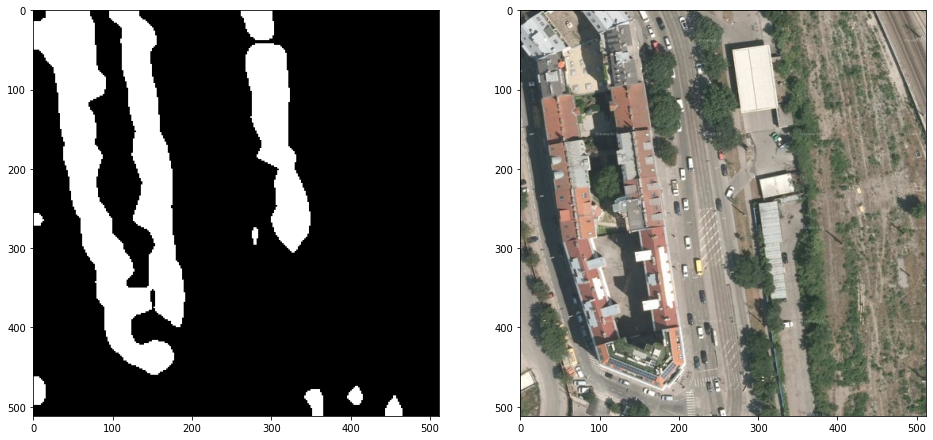

In [32]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(rle_decode(subm[1].fillna('').iloc[0]), cmap='gray')
plt.subplot(122)
plt.imshow(cv2.imread('./data/test_a/' + subm[0].iloc[0]));


In [33]:
a  = '''alabaster
argh
asn1crypto
astroid
astropy
atomicwrites
attrs
autopep8
Babel
backcall
backports.functools-lru-cache
backports.shutil-get-terminal-size
backports.tempfile
backports.weakref
beautifulsoup4
bitarray
bkcharts
bleach
bokeh
boto
Bottleneck
brotlipy
certifi
cffi
chardet
click
cloudpickle
clyent
colorama
contextlib2
cryptography
cycler
Cython
cytoolz
dask
decorator
defusedxml
diff-match-patch
distributed
docutils
entrypoints
et-xmlfile
fastcache
filelock
flake8
Flask
fsspec
future
gevent
glob2
gmpy2
greenlet
h5py
HeapDict
html5lib
idna
imageio
imagesize
importlib-metadata
intervaltree
ipykernel
ipython
ipython-genutils
ipywidgets
isort
itsdangerous
jdcal
jedi
jeepney
Jinja2
joblib
json5
jsonschema
keyring
kiwisolver
lazy-object-proxy
libarchive-c
llvmlite
locket
lxml
MarkupSafe
matplotlib
mccabe
mistune
mkl-fft
mkl-random
mkl-service
mock
more-itertools
mpmath
msgpack
multipledispatch
navigator-updater
nbconvert
nbformat
nose
numba
numexpr
numpy
numpydoc
olefile
openpyxl
packaging
pandas
pandocfilters
parso
partd
path
pathlib2
pathtools
patsy
pep8
pexpect
pickleshare
Pillow
pkginfo
pluggy
ply
prometheus-client
prompt-toolkit
psutil
ptyprocess
pycodestyle
pycosat
pycparser
pycurl
pydocstyle
pyflakes
Pygments
pylint
pyodbc
pyOpenSSL
pyparsing
pyrsistent
PySocks
pytest
python-dateutil
python-jsonrpc-server
python-language-server
pytz
PyWavelets
pyxdg
PyYAML
pyzmq
regex
requests
rope
Rtree
ruamel-yaml
scikit-image
scikit-learn
scipy
seaborn
SecretStorage
Send2Trash
simplegeneric
singledispatch
sip
six
snowballstemmer
sortedcollections
sortedcontainers
soupsieve
spyder-kernels
statsmodels
sympy
tables
tblib
terminado
testpath
threadpoolctl
toml
toolz
tornado
tqdm
traitlets
typing-extensions
ujson
unicodecsv
urllib3
watchdog
wcwidth
webencodings
Werkzeug
widgetsnbextension
wrapt
wurlitzer
xlrd
XlsxWriter
xlwt
xmltodict
yapf
zict
zipp
zope.event
zope.interface
'''.split('\n')

In [34]:
print('\n'.join(['pip3 install ' + x for x in a]))

pip3 install alabaster
pip3 install argh
pip3 install asn1crypto
pip3 install astroid
pip3 install astropy
pip3 install atomicwrites
pip3 install attrs
pip3 install autopep8
pip3 install Babel
pip3 install backcall
pip3 install backports.functools-lru-cache
pip3 install backports.shutil-get-terminal-size
pip3 install backports.tempfile
pip3 install backports.weakref
pip3 install beautifulsoup4
pip3 install bitarray
pip3 install bkcharts
pip3 install bleach
pip3 install bokeh
pip3 install boto
pip3 install Bottleneck
pip3 install brotlipy
pip3 install certifi
pip3 install cffi
pip3 install chardet
pip3 install click
pip3 install cloudpickle
pip3 install clyent
pip3 install colorama
pip3 install contextlib2
pip3 install cryptography
pip3 install cycler
pip3 install Cython
pip3 install cytoolz
pip3 install dask
pip3 install decorator
pip3 install defusedxml
pip3 install diff-match-patch
pip3 install distributed
pip3 install docutils
pip3 install entrypoints
pip3 install et-xmlfile
pip3 in